In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import ee
import geemap
import time
import os
from scipy.signal import savgol_filter
import calendar
import json
import csv
import joblib

# Suppress TensorFlow INFO messages (needs to be before tf import)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Configuration & Constants ---
try:
    ee.Initialize(project='positive-tempo-456012-d8')
    print("Earth Engine Initialized successfully.")
except Exception as e_init:
    print("Earth Engine not initialized. Attempting authentication...")
    try:
        ee.Authenticate()
        ee.Initialize(project='positive-tempo-456012-d8')
        print("Earth Engine Authenticated and Initialized successfully.")
    except Exception as e_auth:
        print(f"CRITICAL: GEE init/auth failed: {e_auth}. Original: {e_init}.")


CROP_DATA_CSV = "/content/final.csv" # YOUR CSV PATH
SAVED_MODEL_DIR = "saved_models"
MODEL_SAVE_PATH_TEMPLATE = os.path.join(SAVED_MODEL_DIR, "{crop_name}_yield_model.keras")
SCALERS_SAVE_PATH_TEMPLATE = os.path.join(SAVED_MODEL_DIR, "{crop_name}_scalers.joblib")


KARNATAKA_DISTRICTS_FC_PATH = "FAO/GAUL/2015/level2"

NASA_POWER_PARAMS_DICT = {
    "T2M": "Temp_2m_C", "T2M_MAX": "Temp_Max_2m_C", "T2M_MIN": "Temp_Min_2m_C",
    "PRECTOTCORR": "Precip_mm_day", "RH2M": "RelHum_2m_percent", "WS2M": "WindSpeed_2m_mps",
    "ALLSKY_SFC_SW_DWN": "SolarRad_AllSky_WM2",
}
NASA_POWER_PARAMS_LIST = list(NASA_POWER_PARAMS_DICT.keys())

S2_BANDS_FOR_VIS = ['B2', 'B3', 'B4', 'B8']
S2_QA_BAND = 'QA60'
S2_CLOUD_BIT_MASK = 1 << 10
S2_CIRRUS_BIT_MASK = 1 << 11

MODIS_VI_COLLECTION = 'MODIS/006/MOD13A1'
MODIS_NDVI_BAND = 'NDVI'
MODIS_EVI_BAND = 'EVI'
MODIS_VI_SCALE_FACTOR = 0.0001

SENTINEL2_START_YEAR = 2016

GROWING_SEASON_START_MONTH = 6
GROWING_SEASON_END_MONTH = 11
NUM_MONTHLY_TIMESTEPS = (GROWING_SEASON_END_MONTH - GROWING_SEASON_START_MONTH) + 1
VI_LIST_S2 = ['NDVI', 'EVI', 'SAVI']
VI_LIST_MODIS = ['NDVI', 'EVI']
VI_FEATURE_SUPERSET = VI_LIST_S2 # Model input shape will be based on this (widest possible set of VIs)


# --- 1. CSV Parsing (Revised for final.csv) ---
def parse_crop_data_from_file(csv_path):
    if not os.path.exists(csv_path):
        print(f"Error: Crop data CSV not found at {csv_path}")
        return pd.DataFrame()
    try:
        # final.csv appears to be a standard CSV with one header row
        df = pd.read_csv(csv_path, quotechar='"', encoding='utf-8', on_bad_lines='warn')

        # Clean column names: "Crop Name - Metric (Unit)" -> "CropName_Metric_Unit"
        # Example: "Arecanut - Area (Hectare)" -> "Arecanut_Area_Hectare"
        # "Cotton(lint) - Yield (Bales/Hectare)" -> "Cottonlint_Yield_BalesperHectare"
        new_column_names = {}
        for original_col_name in df.columns:
            clean_name = original_col_name.replace(" - ", "_")
            clean_name = clean_name.replace(" (", "_")
            clean_name = clean_name.replace(")", "")
            clean_name = clean_name.replace("/", "per")
            clean_name = clean_name.replace(" ", "") # Remove all remaining spaces
            new_column_names[original_col_name] = clean_name

        df.rename(columns=new_column_names, inplace=True)

        # Parse year (assuming 'Year' column might be like 'YYYY - YYYY' or just 'YYYY')
        def parse_year(year_str):
            if isinstance(year_str, str) and ' - ' in year_str:
                return int(year_str.split(' - ')[0])
            try:
                return int(year_str)
            except (ValueError, TypeError): # Handle cases where year might already be int or NaN
                if pd.isna(year_str): return np.nan
                return int(float(year_str)) # Try converting to float then int if it's a numeric string
        df['Year'] = df['Year'].apply(parse_year)

        # Convert potential numeric columns to numeric, coercing errors
        for col in df.columns:
            if col not in ['State', 'District', 'Year']: # Keep these as object/string for now
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df.dropna(subset=['Year'], inplace=True) # Remove rows where year couldn't be parsed
        df['Year'] = df['Year'].astype(int)

        # Clean district and state names by removing leading numbers like "1. Bagalkot"
        # and ensure they are strings
        df['District'] = df['District'].astype(str).str.replace(r'^\d+\.\s*', '', regex=True).str.strip()
        df['State'] = df['State'].astype(str).str.replace(r'^\d+\.\s*', '', regex=True).str.strip()

        print(f"Successfully parsed CSV. Shape: {df.shape}. Columns example: {df.columns.tolist()[:5]}...")
        return df
    except Exception as e:
        print(f"Error parsing CSV from file '{csv_path}': {type(e)._name_} - {e}")
        return pd.DataFrame()


# --- 2. Data Acquisition (No changes from previous working version) ---
def fetch_monthly_nasa_power_data(lat, lon, year, start_month, end_month, parameters):
    start_date_dt = datetime(year, start_month, 1)
    end_day_of_end_month = calendar.monthrange(year, end_month)[1]
    end_date_dt = datetime(year, end_month, end_day_of_end_month)
    params_str = ",".join(parameters)
    url = (f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={params_str}"
           f"&community=AG&longitude={lon}&latitude={lat}&start={start_date_dt.strftime('%Y%m%d')}"
           f"&end={end_date_dt.strftime('%Y%m%d')}&format=JSON")
    monthly_features = {}
    for p in parameters:
        p_label = NASA_POWER_PARAMS_DICT.get(p, p)
        monthly_features[f'{p_label}_mean_monthly'] = [np.nan] * NUM_MONTHLY_TIMESTEPS
        if 'PREC' in p.upper() or 'SOLAR' in p.upper() or 'ALLSKY' in p.upper():
             monthly_features[f'{p_label}_sum_monthly'] = [np.nan] * NUM_MONTHLY_TIMESTEPS
    try:
        resp = requests.get(url, timeout=60)
        resp.raise_for_status()
        data_json = resp.json()
        if "properties" not in data_json or "parameter" not in data_json["properties"]: return monthly_features
        time_series = data_json["properties"]["parameter"]
        if not time_series or not parameters or parameters[0] not in time_series or not time_series[parameters[0]]: return monthly_features
        dates_str = list(time_series[parameters[0]].keys())
        df_data = []
        for date_str_item in dates_str:
            row = {"Date": datetime.strptime(date_str_item, "%Y%m%d")}
            for pk, pv in time_series.items(): row[pk] = float(pv.get(date_str_item, np.nan)) if pv.get(date_str_item, np.nan) != -999 else np.nan
            df_data.append(row)
        daily_df = pd.DataFrame(df_data)
        if daily_df.empty: return monthly_features
        daily_df['Month'] = daily_df['Date'].dt.month
        for i, month_num in enumerate(range(start_month, end_month + 1)):
            month_df = daily_df[daily_df['Month'] == month_num]
            if not month_df.empty:
                for p in parameters:
                    p_label = NASA_POWER_PARAMS_DICT.get(p,p)
                    mean_col, sum_col = f'{p_label}_mean_monthly', f'{p_label}_sum_monthly'
                    if p in month_df.columns and not month_df[p].isnull().all():
                        monthly_features[mean_col][i] = month_df[p].mean()
                        if sum_col in monthly_features: monthly_features[sum_col][i] = month_df[p].sum()
        return monthly_features
    except requests.exceptions.RequestException as e: print(f"NASA POWER Error for ({lat},{lon}) year {year}: {e}")
    except KeyError as e_key: print(f"KeyError in NASA POWER processing for year {year}, param {e_key}.")
    return monthly_features

def mask_s2_clouds_gee(image):
    qa = image.select(S2_QA_BAND)
    cloud_mask = qa.bitwiseAnd(S2_CLOUD_BIT_MASK).eq(0)
    cirrus_mask = qa.bitwiseAnd(S2_CIRRUS_BIT_MASK).eq(0)
    return image.updateMask(cloud_mask).updateMask(cirrus_mask).select(S2_BANDS_FOR_VIS).divide(10000.0)

def calculate_s2_vis_gee(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    evi = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1.0))', {'NIR': image.select('B8'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}).rename('EVI')
    savi = image.expression('((NIR - RED) / (NIR + RED + 0.5)) * (1.5)', {'NIR': image.select('B8'), 'RED': image.select('B4')}).rename('SAVI')
    return image.addBands([ndvi, evi, savi])

def get_monthly_gee_satellite_features(aoi_geometry, year, start_month, end_month):
    use_modis = year < SENTINEL2_START_YEAR
    vi_list_for_sensor = VI_LIST_MODIS if use_modis else VI_LIST_S2
    monthly_vi_features = {f'{vi}_monthly_series': [np.nan] * NUM_MONTHLY_TIMESTEPS for vi in VI_FEATURE_SUPERSET}
    sensor_name = "MODIS" if use_modis else "Sentinel-2"
    # print(f"    Fetching VIs using {sensor_name} for year {year} ({', '.join(vi_list_for_sensor)}).")
    current_month_num_for_error = "N/A"
    try:
        for i, month_num in enumerate(range(start_month, end_month + 1)):
            current_month_num_for_error = month_num
            month_start_str = f"{year}-{str(month_num).zfill(2)}-01"
            month_end_day = calendar.monthrange(year, month_num)[1]
            month_end_str = f"{year}-{str(month_num).zfill(2)}-{str(month_end_day).zfill(2)}"
            image_collection = None
            if use_modis:
                image_collection = ee.ImageCollection(MODIS_VI_COLLECTION).filterBounds(aoi_geometry).filterDate(ee.Date(month_start_str), ee.Date(month_end_str).advance(1, 'day')).select([MODIS_NDVI_BAND, MODIS_EVI_BAND], vi_list_for_sensor)
                def scale_modis_vis(image): return image.multiply(MODIS_VI_SCALE_FACTOR).copyProperties(image, ['system:time_start'])
                image_collection = image_collection.map(scale_modis_vis)
            else:
                image_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(aoi_geometry).filterDate(ee.Date(month_start_str), ee.Date(month_end_str).advance(1, 'day')).map(mask_s2_clouds_gee).map(calculate_s2_vis_gee).select(vi_list_for_sensor)

            collection_size = image_collection.size().getInfo()
            if collection_size > 0:
                mean_monthly_image = image_collection.mean()
                vi_means_dict = mean_monthly_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_geometry, scale=500, maxPixels=1e10, bestEffort=True).getInfo()
                for vi_name_from_sensor in vi_list_for_sensor:
                    if vi_means_dict and vi_means_dict.get(vi_name_from_sensor) is not None:
                         monthly_vi_features[f'{vi_name_from_sensor}_monthly_series'][i] = vi_means_dict.get(vi_name_from_sensor)
            # else: print(f"  No {sensor_name} images for {year}-{str(month_num).zfill(2)}.") # Less verbose to speed up

        for vi_super in VI_FEATURE_SUPERSET:
            series = np.array(monthly_vi_features[f'{vi_super}_monthly_series'])
            valid_points = series[~np.isnan(series)]
            if len(valid_points) > 0:
                monthly_vi_features[f'{vi_super}_peak'] = np.nanmax(series)
                monthly_vi_features[f'{vi_super}_auc'] = np.trapezoid(valid_points) if len(valid_points) > 1 else np.nan
            else: monthly_vi_features[f'{vi_super}_peak'], monthly_vi_features[f'{vi_super}_auc'] = np.nan, np.nan
        return monthly_vi_features
    except ee.EEException as e: print(f"GEE Error (get_monthly_gee_satellite_features) for {year}-{str(current_month_num_for_error).zfill(2)}: {e}")
    except Exception as e: print(f"General Error (get_monthly_gee_satellite_features): {type(e)._name_} - {e}")
    return monthly_vi_features

# --- 3. District Mapping & AOI ---
def get_district_geometry_and_centroid(district_name_str, state_name_str='Karnataka'):
    try:
        clean_district_name = district_name_str.split('. ')[-1].strip() if '. ' in district_name_str else district_name_str.strip()
        fc = ee.FeatureCollection(KARNATAKA_DISTRICTS_FC_PATH).filter(ee.Filter.eq('ADM1_NAME', state_name_str))
        district_feature = fc.filter(ee.Filter.eq('ADM2_NAME', clean_district_name)).first()
        feature_info = district_feature.getInfo()
        if not feature_info or not feature_info.get('geometry'):
            title_case_name = clean_district_name.title()
            if title_case_name != clean_district_name:
                # print(f"Direct match failed for '{clean_district_name}'. Trying title case '{title_case_name}'...")
                district_feature = fc.filter(ee.Filter.eq('ADM2_NAME', title_case_name)).first()
                feature_info = district_feature.getInfo()
        if not feature_info or not feature_info.get('geometry'):
            print(f"Warning: District '{clean_district_name}' not found or no geometry in GEE for '{state_name_str}'.")
            return None, None
        geometry = district_feature.geometry()
        try: centroid_coords = geometry.centroid(maxError=1).coordinates().getInfo()
        except ee.EEException: centroid_coords = geometry.simplify(maxError=100).centroid(maxError=1).coordinates().getInfo()
        return geometry, {'longitude': centroid_coords[0], 'latitude': centroid_coords[1]}
    except Exception as e:
        print(f"Error getting district geometry for {district_name_str}: {type(e)._name_} - {e}")
        return None, None

# --- 4. Data Preparation ---
def prepare_monthly_training_data(crop_df, target_crop_keyword, target_year_for_training, max_districts=None):
    master_data = []
    crop_keyword_cleaned = target_crop_keyword.replace(" ", "") # "Sugarcane"
    # Potential yield column names based on the parser's cleaning logic
    # "Sugarcane_Yield_Tonne_per_Hectare"
    # "Sugarcane_Yield_tha" (if "t/ha" was present)
    # "Sugarcane_Yield_Nuts_per_Hectare" etc.

    # Try the most specific one first
    yield_col_name = f"{crop_keyword_cleaned}_Yield_Tonne_per_Hectare"
    if yield_col_name not in crop_df.columns:
        # Fallback to find any yield column for that crop
        potential_cols = [col for col in crop_df.columns if crop_keyword_cleaned.lower() in col.lower() and "yield" in col.lower()]
        if not potential_cols:
            print(f"Error: No yield column found for crop keyword '{target_crop_keyword}'. Searched for '{yield_col_name}' and generic patterns.")
            return pd.DataFrame()
        yield_col_name = potential_cols[0] # Take the first match
        print(f"Warning: Using fallback yield column: {yield_col_name} for {target_crop_keyword}")

    print(f"Using yield column: {yield_col_name} for {target_crop_keyword}")

    year_filtered_df = crop_df[crop_df['Year'] == target_year_for_training].copy()
    year_filtered_df.dropna(subset=[yield_col_name], inplace=True)
    year_filtered_df = year_filtered_df[year_filtered_df[yield_col_name] > 0]
    if year_filtered_df.empty: print(f"No data for {target_crop_keyword} in {target_year_for_training}."); return pd.DataFrame()
    unique_districts_in_year = year_filtered_df['District'].unique()
    districts_to_process = unique_districts_in_year[:max_districts] if max_districts else unique_districts_in_year
    print(f"Processing {len(districts_to_process)} districts for year {target_year_for_training}.")

    for i, district_name_loop in enumerate(districts_to_process):
        district_geom, district_centroid = get_district_geometry_and_centroid(district_name_loop)
        if not district_geom or not district_centroid: print(f"Skipping district {district_name_loop}, missing GEE geometry."); continue

        # Ensure there's data for this specific district in the filtered year_df
        district_year_data = year_filtered_df[year_filtered_df['District'] == district_name_loop]
        if district_year_data.empty:
            # This should not happen if unique_districts_in_year came from year_filtered_df
            print(f"No data for district {district_name_loop} in year {target_year_for_training} after initial filter. Skipping.")
            continue
        row_series = district_year_data.iloc[0]
        yield_value = row_series[yield_col_name]

        print(f"\nProcessing District: {district_name_loop} ({i+1}/{len(districts_to_process)}), Year: {target_year_for_training}, Yield: {yield_value:.2f}")
        # print(f"    Fetching Monthly NASA POWER..."); # Less verbose
        monthly_weather = fetch_monthly_nasa_power_data(district_centroid['latitude'], district_centroid['longitude'], target_year_for_training, GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH, NASA_POWER_PARAMS_LIST); time.sleep(0.05)
        # print(f"    Fetching Monthly GEE VI..."); # Less verbose
        monthly_vi = get_monthly_gee_satellite_features(district_geom, target_year_for_training, GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH); time.sleep(0.05)

        vi_check_list = VI_LIST_MODIS if target_year_for_training < SENTINEL2_START_YEAR else VI_LIST_S2
        valid_sat = monthly_vi and all(
            (f'{v}_monthly_series' in monthly_vi and
             isinstance(monthly_vi[f'{v}_monthly_series'], list) and
             len(monthly_vi[f'{v}_monthly_series']) == NUM_MONTHLY_TIMESTEPS and
             (not np.all(np.isnan(monthly_vi[f'{v}_monthly_series'])) if v in vi_check_list else True)
            ) for v in VI_FEATURE_SUPERSET
        )
        if not all(not np.all(np.isnan(monthly_vi.get(f'{v}_monthly_series', [np.nan]*NUM_MONTHLY_TIMESTEPS))) for v in vi_check_list if f'{v}_monthly_series' in monthly_vi):
            valid_sat = False

        if not valid_sat: print(f"    Skipping {district_name_loop}, {target_year_for_training} due to invalid/missing GEE monthly VI data for expected VIs."); continue
        master_data.append({'District': district_name_loop, 'Year': target_year_for_training, 'Yield': yield_value, **monthly_weather, **monthly_vi})
    return pd.DataFrame(master_data)

# --- 5. Model Definition ---
def build_monthly_yield_prediction_model(monthly_vi_series_shape, vi_scalar_shape, monthly_weather_series_shape, l2_reg=0.005):
    monthly_vi_input = tf.keras.Input(shape=monthly_vi_series_shape, name='monthly_vi_input')
    lstm_vi = tf.keras.layers.LSTM(48, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(monthly_vi_input)
    lstm_vi = tf.keras.layers.BatchNormalization()(lstm_vi); lstm_vi = tf.keras.layers.Dropout(0.3)(lstm_vi)
    lstm_vi = tf.keras.layers.LSTM(24, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(lstm_vi)
    lstm_vi = tf.keras.layers.BatchNormalization()(lstm_vi)
    vi_scalar_input = tf.keras.Input(shape=vi_scalar_shape, name='vi_scalar_input')
    dense_vi_scalar = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(vi_scalar_input)
    dense_vi_scalar = tf.keras.layers.BatchNormalization()(dense_vi_scalar)
    monthly_weather_input = tf.keras.Input(shape=monthly_weather_series_shape, name='monthly_weather_input')
    lstm_weather = tf.keras.layers.LSTM(48, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(monthly_weather_input)
    lstm_weather = tf.keras.layers.BatchNormalization()(lstm_weather); lstm_weather = tf.keras.layers.Dropout(0.3)(lstm_weather)
    lstm_weather = tf.keras.layers.LSTM(24, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(lstm_weather)
    lstm_weather = tf.keras.layers.BatchNormalization()(lstm_weather)
    merged = tf.keras.layers.Concatenate()([lstm_vi, dense_vi_scalar, lstm_weather])
    final_dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged)
    final_dense = tf.keras.layers.BatchNormalization()(final_dense); final_dense = tf.keras.layers.Dropout(0.4)(final_dense)
    output = tf.keras.layers.Dense(1, activation='linear', name='yield_output')(final_dense)
    model = tf.keras.Model(inputs=[monthly_vi_input, vi_scalar_input, monthly_weather_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# --- 6. Training and Evaluation ---
def train_and_evaluate_monthly_model(model_builder_fn, X_mvi_s, X_vi_sc, X_mw_s, y, n_splits=5, epochs=50, batch_size=4):
    if len(y) < 2: print("Not enough data (less than 2 samples) for training."); return None, {}, pd.DataFrame()
    if len(y) < n_splits: n_splits = len(y)
    if n_splits < 2 and len(y) >= 2 : n_splits = 2
    elif n_splits < 2 and len(y) < 2:
        print("Dataset too small for K-Fold. Training on all data without validation.")
        scaler_mvi_s = MinMaxScaler().fit(X_mvi_s.reshape(-1, X_mvi_s.shape[-1] if X_mvi_s.ndim > 2 else 1))
        X_mvi_s_sc = scaler_mvi_s.transform(X_mvi_s.reshape(-1, X_mvi_s.shape[-1] if X_mvi_s.ndim > 2 else 1)).reshape(X_mvi_s.shape)
        scaler_vi_sc = MinMaxScaler().fit(X_vi_sc); X_vi_sc_sc = scaler_vi_sc.transform(X_vi_sc)
        scaler_mw_s = StandardScaler().fit(X_mw_s.reshape(-1, X_mw_s.shape[-1] if X_mw_s.ndim > 2 else 1))
        X_mw_s_sc = scaler_mw_s.transform(X_mw_s.reshape(-1, X_mw_s.shape[-1] if X_mw_s.ndim > 2 else 1)).reshape(X_mw_s.shape)
        scaler_y = MinMaxScaler().fit(y.reshape(-1,1)); y_sc = scaler_y.transform(y.reshape(-1,1))
        model = model_builder_fn((X_mvi_s_sc.shape[1],X_mvi_s_sc.shape[2]),(X_vi_sc_sc.shape[1],),(X_mw_s_sc.shape[1],X_mw_s_sc.shape[2]))
        model.fit([X_mvi_s_sc,X_vi_sc_sc,X_mw_s_sc],y_sc,epochs=epochs,batch_size=batch_size,verbose=1)
        return model, {'mvi_s':scaler_mvi_s,'vi_sc':scaler_vi_sc,'mw_s':scaler_mw_s,'y':scaler_y}, pd.DataFrame()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics, trained_models = [], []
    scaler_mvi_s = MinMaxScaler().fit(X_mvi_s.reshape(-1, X_mvi_s.shape[-1]))
    X_mvi_s_sc = scaler_mvi_s.transform(X_mvi_s.reshape(-1, X_mvi_s.shape[-1])).reshape(X_mvi_s.shape)
    scaler_vi_sc = MinMaxScaler().fit(X_vi_sc); X_vi_sc_sc = scaler_vi_sc.transform(X_vi_sc)
    scaler_mw_s = StandardScaler().fit(X_mw_s.reshape(-1, X_mw_s.shape[-1]))
    X_mw_s_sc = scaler_mw_s.transform(X_mw_s.reshape(-1, X_mw_s.shape[-1])).reshape(X_mw_s.shape)
    scaler_y = MinMaxScaler().fit(y.reshape(-1,1)); y_sc = scaler_y.transform(y.reshape(-1,1))

    for fold, (train_idx, val_idx) in enumerate(kf.split(y_sc)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        X_tr_mvi,X_val_mvi = X_mvi_s_sc[train_idx],X_mvi_s_sc[val_idx]
        X_tr_visc,X_val_visc = X_vi_sc_sc[train_idx],X_vi_sc_sc[val_idx]
        X_tr_mwe,X_val_mwe = X_mw_s_sc[train_idx],X_mw_s_sc[val_idx]
        y_tr,y_val = y_sc[train_idx],y_sc[val_idx]
        model = model_builder_fn((X_tr_mvi.shape[1],X_tr_mvi.shape[2]),(X_tr_visc.shape[1],),(X_tr_mwe.shape[1],X_tr_mwe.shape[2]))
        es = tf.keras.callbacks.EarlyStopping('val_loss',patience=15,restore_best_weights=True,verbose=1)
        rlr = tf.keras.callbacks.ReduceLROnPlateau('val_loss',factor=0.2,patience=7,min_lr=1e-6,verbose=1)
        model.fit([X_tr_mvi,X_tr_visc,X_tr_mwe],y_tr,validation_data=([X_val_mvi,X_val_visc,X_val_mwe],y_val),epochs=epochs,batch_size=batch_size,callbacks=[es,rlr],verbose=1)
        trained_models.append(model)
        y_p_s_val = model.predict([X_val_mvi,X_val_visc,X_val_mwe])
        y_p_o_val,y_t_o_val = scaler_y.inverse_transform(y_p_s_val),scaler_y.inverse_transform(y_val)
        rmse,mae = np.sqrt(mean_squared_error(y_t_o_val,y_p_o_val)),mean_absolute_error(y_t_o_val,y_p_o_val)
        r2_val = r2_score(y_t_o_val,y_p_o_val) if len(y_t_o_val)>=2 else np.nan
        r2_str = f"{r2_val:.3f}" if not np.isnan(r2_val) else "Undefined"
        print(f"Fold {fold+1} Val Metrics - RMSE:{rmse:.3f}, MAE:{mae:.3f}, R²:{r2_str}")
        fold_metrics.append({'fold':fold+1,'rmse':rmse,'mae':mae,'r2':r2_val})
    metrics_df = pd.DataFrame(fold_metrics)
    print("\n--- CV Metrics ---"); print(metrics_df)
    if not metrics_df.empty: print(metrics_df.drop(columns=['fold']).mean().rename('Average'))
    best_idx = metrics_df['rmse'].idxmin() if not metrics_df.empty and 'rmse' in metrics_df and not metrics_df['rmse'].isnull().all() else (0 if trained_models else None)
    final_model = trained_models[best_idx] if best_idx is not None and trained_models else None
    return final_model, {'mvi_s':scaler_mvi_s,'vi_sc':scaler_vi_sc,'mw_s':scaler_mw_s,'y':scaler_y}, metrics_df

# --- 7. Prediction ---
def predict_yield_monthly_features(model, scalers, user_lat, user_lon, user_aoi_radius_m, prediction_year):
    if model is None or not scalers: print("Error: Model/scalers missing."); return None
    current_yr, current_mth = datetime.now().year, datetime.now().month
    year_for_gee_vi = prediction_year
    gee_vi_source_info = f"GEE VI Year: {year_for_gee_vi}"

    if prediction_year > current_yr:
        year_for_gee_vi = current_yr - 1
        if year_for_gee_vi < 2000: year_for_gee_vi = 2000
        gee_vi_source_info = f"GEE VI Year (fallback for future prediction): {year_for_gee_vi}"
        print(f"  Prediction year {prediction_year} is future. Satellite VI data for weather year {prediction_year} will be attempted using GEE VI data from year {year_for_gee_vi}.")
    elif prediction_year == current_yr and current_mth < GROWING_SEASON_END_MONTH:
        year_for_gee_vi = current_yr - 1
        if current_mth <= GROWING_SEASON_START_MONTH and year_for_gee_vi == current_yr - 1: year_for_gee_vi -=1
        if year_for_gee_vi < 2000: year_for_gee_vi = 2000
        gee_vi_source_info = f"GEE VI Year (fallback for ongoing season): {year_for_gee_vi}"
        print(f"  Prediction year {prediction_year} is current, season ongoing. Satellite VI data for weather year {prediction_year} will be attempted using GEE VI data from year {year_for_gee_vi}.")

    print(f"\n--- Predicting for User: Lat={user_lat}, Lon={user_lon}, Year={prediction_year} ({gee_vi_source_info}) ---")
    user_point, user_aoi = ee.Geometry.Point(user_lon, user_lat), ee.Geometry.Point(user_lon, user_lat).buffer(user_aoi_radius_m)

    print(f"  Fetching Monthly NASA POWER for prediction year {prediction_year}...")
    weather_user = fetch_monthly_nasa_power_data(user_lat, user_lon, prediction_year, GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH, NASA_POWER_PARAMS_LIST); time.sleep(0.1)
    user_mw_s_list = []
    for p_code in NASA_POWER_PARAMS_LIST:
        p_name = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
        user_mw_s_list.append(weather_user.get(f'{p_name}_mean_monthly', [np.nan]*NUM_MONTHLY_TIMESTEPS))
        if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper():
            user_mw_s_list.append(weather_user.get(f'{p_name}_sum_monthly', [np.nan]*NUM_MONTHLY_TIMESTEPS))
    X_mw_s_user = np.array(user_mw_s_list).T.reshape(1, NUM_MONTHLY_TIMESTEPS, len(user_mw_s_list))

    print(f"  Fetching Monthly GEE VI features for GEE year {year_for_gee_vi}...")
    sat_vi_user = get_monthly_gee_satellite_features(user_aoi, year_for_gee_vi, GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH); time.sleep(0.1)
    user_mvi_s_list, user_vi_sc_list, valid_sat = [], [], True

    vi_list_to_expect_from_gee = VI_LIST_MODIS if year_for_gee_vi < SENTINEL2_START_YEAR else VI_LIST_S2

    if not sat_vi_user: valid_sat = False
    else:
        temp_mvi_s_dict = {}
        temp_vi_sc_list_for_sensor = []
        for vi_name_sensor in vi_list_to_expect_from_gee:
            series = sat_vi_user.get(f'{vi_name_sensor}_monthly_series', [np.nan]*NUM_MONTHLY_TIMESTEPS)
            if not isinstance(series,list) or len(series)!=NUM_MONTHLY_TIMESTEPS or np.all(np.isnan(series)):
                series=[np.nan]*NUM_MONTHLY_TIMESTEPS
                if vi_name_sensor == vi_list_to_expect_from_gee[0]: valid_sat = False
            temp_mvi_s_dict[vi_name_sensor] = series
            temp_vi_sc_list_for_sensor.extend([sat_vi_user.get(f'{vi_name_sensor}_peak',np.nan), sat_vi_user.get(f'{vi_name_sensor}_auc',np.nan)])

        for vi_s2_name in VI_FEATURE_SUPERSET:
            user_mvi_s_list.append(temp_mvi_s_dict.get(vi_s2_name, [np.nan]*NUM_MONTHLY_TIMESTEPS))
            if vi_s2_name in vi_list_to_expect_from_gee:
                idx = vi_list_to_expect_from_gee.index(vi_s2_name) * 2
                user_vi_sc_list.extend(temp_vi_sc_list_for_sensor[idx : idx+2])
            else:
                user_vi_sc_list.extend([np.nan, np.nan])

    if not valid_sat: print(f"  Critical satellite VI data missing/invalid for GEE year {year_for_gee_vi}. Prediction will use zeros for VI features.");

    X_mvi_s_u = np.array(user_mvi_s_list).T.reshape(1,NUM_MONTHLY_TIMESTEPS,len(VI_FEATURE_SUPERSET))
    X_vi_sc_u = np.array(user_vi_sc_list).reshape(1,-1)
    X_mvi_s_u,X_vi_sc_u,X_mw_s_user = np.nan_to_num(X_mvi_s_u,nan=0.0),np.nan_to_num(X_vi_sc_u,nan=0.0),np.nan_to_num(X_mw_s_user,nan=0.0)

    X_mvi_s_u_flat = X_mvi_s_u.reshape(-1, X_mvi_s_u.shape[-1] if X_mvi_s_u.ndim > 2 else 1)
    X_mvi_s_u_sc = scalers['mvi_s'].transform(X_mvi_s_u_flat).reshape(X_mvi_s_u.shape)
    X_vi_sc_u_sc = scalers['vi_sc'].transform(X_vi_sc_u)
    X_mw_s_u_flat = X_mw_s_user.reshape(-1, X_mw_s_user.shape[-1] if X_mw_s_user.ndim > 2 else 1)
    X_mw_s_u_sc = scalers['mw_s'].transform(X_mw_s_u_flat).reshape(X_mw_s_user.shape)

    pred_s = model.predict([X_mvi_s_u_sc, X_vi_sc_u_sc, X_mw_s_u_sc])
    return scalers['y'].inverse_transform(pred_s)[0][0]

if __name__ == "__main__":
    TRAIN_MODEL_FLAG = True
    TARGET_CROP_NAME = 'Sugarcane'
    YEAR_FOR_TRAINING = 2015
    MAX_DISTRICTS_TO_USE_FOR_TRAINING = None

    EPOCHS_FOR_TRAINING = 50
    BATCH_SIZE_FOR_TRAINING = 4

    USER_LATITUDE_PREDICT = 15.36
    USER_LONGITUDE_PREDICT = 75.13
    USER_AOI_RADIUS_METERS_PREDICT = 1000
    YEAR_TO_PREDICT_FOR = 2025

    final_model = None
    data_scalers = None

    print("--- Crop Yield Prediction Model (Monthly Features) ---")
    if not os.path.exists(SAVED_MODEL_DIR):
        os.makedirs(SAVED_MODEL_DIR)
        print(f"Created directory: {SAVED_MODEL_DIR}")

    model_path = MODEL_SAVE_PATH_TEMPLATE.format(crop_name=TARGET_CROP_NAME.replace(" ","_"))
    scalers_path = SCALERS_SAVE_PATH_TEMPLATE.format(crop_name=TARGET_CROP_NAME.replace(" ","_"))

    if TRAIN_MODEL_FLAG:
        print("\nStep 1: Loading and Parsing Crop Data...")
        full_crop_df = parse_crop_data_from_file(CROP_DATA_CSV)
        if full_crop_df.empty:
            print("Exiting: Crop data CSV could not be parsed.")
            exit()
        else:
            print(f"Crop data loaded. Shape: {full_crop_df.shape}")
            print(f"\nStep 2: Preparing Training Data for '{TARGET_CROP_NAME}' for Year {YEAR_FOR_TRAINING} (Max Districts: {MAX_DISTRICTS_TO_USE_FOR_TRAINING if MAX_DISTRICTS_TO_USE_FOR_TRAINING else 'All'})...")
            training_data_df = prepare_monthly_training_data(full_crop_df, TARGET_CROP_NAME,
                                                             target_year_for_training=YEAR_FOR_TRAINING,
                                                             max_districts=MAX_DISTRICTS_TO_USE_FOR_TRAINING)

            if training_data_df.empty or len(training_data_df) < 1:
                print(f"Insufficient training data ({len(training_data_df)} samples) for year {YEAR_FOR_TRAINING}. Cannot train model.")
            else:
                print(f"Monthly training data prepared. Shape: {training_data_df.shape}")
                print("\nStep 3: Engineering Features for Model Input...")

                mvi_s_cols = [f'{vi}_monthly_series' for vi in VI_FEATURE_SUPERSET]
                X_mvi_s_list = [np.array([row.get(col, [np.nan]*NUM_MONTHLY_TIMESTEPS) if isinstance(row.get(col),list) and len(row.get(col))==NUM_MONTHLY_TIMESTEPS else [np.nan]*NUM_MONTHLY_TIMESTEPS for col in mvi_s_cols]).T for _,row in training_data_df.iterrows()]
                X_mvi_s_np = np.array(X_mvi_s_list)

                vi_sc_cols = [item for vi in VI_FEATURE_SUPERSET for item in (f'{vi}_peak',f'{vi}_auc')]
                X_vi_sc_np = training_data_df[vi_sc_cols].values

                mw_series_cols_ordered = [item for p_code in NASA_POWER_PARAMS_LIST for item in ([f'{NASA_POWER_PARAMS_DICT.get(p_code, p_code)}_mean_monthly', f'{NASA_POWER_PARAMS_DICT.get(p_code, p_code)}_sum_monthly'] if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper() else [f'{NASA_POWER_PARAMS_DICT.get(p_code, p_code)}_mean_monthly'])]
                X_mw_s_list = []
                for _, row in training_data_df.iterrows():
                    current_sample_series = []
                    for col_name in mw_series_cols_ordered:
                        series = row.get(col_name, [np.nan]*NUM_MONTHLY_TIMESTEPS)
                        if not isinstance(series, list) or len(series) != NUM_MONTHLY_TIMESTEPS: series=[np.nan]*NUM_MONTHLY_TIMESTEPS
                        current_sample_series.append(series)
                    if current_sample_series: X_mw_s_list.append(np.array(current_sample_series).T)

                if X_mw_s_list: X_mw_s_np = np.array(X_mw_s_list)
                else:
                    num_expected_weather_series = len(mw_series_cols_ordered)
                    X_mw_s_np = np.zeros((len(training_data_df), NUM_MONTHLY_TIMESTEPS, num_expected_weather_series))

                y_np = training_data_df['Yield'].values
                X_mvi_s_np, X_vi_sc_np, X_mw_s_np = np.nan_to_num(X_mvi_s_np,nan=0.0), np.nan_to_num(X_vi_sc_np,nan=0.0), np.nan_to_num(X_mw_s_np,nan=0.0)
                y_np = np.nan_to_num(y_np, nan=np.nanmean(y_np) if np.any(np.isnan(y_np)) else 0.0)
                print(f"  Input Shapes: X_mvi: {X_mvi_s_np.shape}, X_vi_sc: {X_vi_sc_np.shape}, X_mw: {X_mw_s_np.shape}, y: {y_np.shape}")

                print("\nStep 4: Training Model...")
                if len(training_data_df) < 4:
                    print("Dataset very small. Training on all available data using a simple train/validation split (if possible).")
                    indices = np.arange(len(y_np)); stratify_y = None
                    if len(np.unique(y_np)) > 1 and len(y_np) >= 4 :
                        unique_ys, counts = np.unique(y_np, return_counts=True)
                        if not np.any(counts < 2) : stratify_y = y_np
                        else: print("Stratification skipped due to class imbalance or too few samples per class.")
                    test_s_size = 0.25 if len(y_np) >= 4 else ( (1/len(y_np)) if len(y_np) > 1 else 0)
                    if test_s_size > 0 and len(y_np) > 1 :
                        train_idx, val_idx = train_test_split(indices, test_size=test_s_size, random_state=42, stratify=stratify_y)
                    else: train_idx, val_idx = indices, np.array([])

                    scaler_mvi_s = MinMaxScaler().fit(X_mvi_s_np[train_idx].reshape(-1, X_mvi_s_np.shape[-1] if X_mvi_s_np.ndim > 2 else 1))
                    X_mvi_tr_sc = scaler_mvi_s.transform(X_mvi_s_np[train_idx].reshape(-1, X_mvi_s_np.shape[-1] if X_mvi_s_np.ndim > 2 else 1)).reshape(X_mvi_s_np[train_idx].shape)
                    X_mvi_val_sc = scaler_mvi_s.transform(X_mvi_s_np[val_idx].reshape(-1, X_mvi_s_np.shape[-1] if X_mvi_s_np.ndim > 2 else 1)).reshape(X_mvi_s_np[val_idx].shape) if len(val_idx)>0 and X_mvi_s_np[val_idx].size > 0 else np.array([])
                    scaler_vi_sc = MinMaxScaler().fit(X_vi_sc_np[train_idx]); X_visc_tr_sc, X_visc_val_sc = scaler_vi_sc.transform(X_vi_sc_np[train_idx]), (scaler_vi_sc.transform(X_vi_sc_np[val_idx]) if len(val_idx)>0 else np.array([]))
                    scaler_mw_s = StandardScaler().fit(X_mw_s_np[train_idx].reshape(-1, X_mw_s_np.shape[-1] if X_mw_s_np.ndim > 2 else 1))
                    X_mwe_tr_sc = scaler_mw_s.transform(X_mw_s_np[train_idx].reshape(-1, X_mw_s_np.shape[-1] if X_mw_s_np.ndim > 2 else 1)).reshape(X_mw_s_np[train_idx].shape)
                    X_mwe_val_sc = scaler_mw_s.transform(X_mw_s_np[val_idx].reshape(-1, X_mw_s_np.shape[-1] if X_mw_s_np.ndim > 2 else 1)).reshape(X_mw_s_np[val_idx].shape) if len(val_idx)>0 and X_mw_s_np[val_idx].size > 0 else np.array([])
                    scaler_y = MinMaxScaler().fit(y_np[train_idx].reshape(-1,1)); y_tr_sc, y_val_sc = scaler_y.transform(y_np[train_idx].reshape(-1,1)), (scaler_y.transform(y_np[val_idx].reshape(-1,1)) if len(val_idx)>0 else np.array([]))

                    final_model = build_monthly_yield_prediction_model((X_mvi_tr_sc.shape[1],X_mvi_tr_sc.shape[2]), (X_visc_tr_sc.shape[1],), (X_mwe_tr_sc.shape[1],X_mwe_tr_sc.shape[2]))
                    val_data = ([X_mvi_val_sc, X_visc_val_sc, X_mwe_val_sc], y_val_sc) if len(val_idx) > 0 and X_mvi_val_sc.size > 0 else None
                    final_model.fit([X_mvi_tr_sc, X_visc_tr_sc, X_mwe_tr_sc], y_tr_sc, validation_data=val_data, epochs=EPOCHS_FOR_TRAINING, batch_size=max(1, len(train_idx)//4 if len(train_idx)>0 else 1), verbose=1)
                    data_scalers = {'mvi_s':scaler_mvi_s, 'vi_sc':scaler_vi_sc, 'mw_s':scaler_mw_s, 'y':scaler_y}
                else:
                    num_kf_splits = max(2, min(5, len(training_data_df)))
                    final_model, data_scalers, cv_summary = train_and_evaluate_monthly_model(build_monthly_yield_prediction_model, X_mvi_s_np, X_vi_sc_np, X_mw_s_np, y_np, n_splits=num_kf_splits, epochs=EPOCHS_FOR_TRAINING, batch_size=BATCH_SIZE_FOR_TRAINING)

                if final_model:
                    print(f"Saving model to {model_path}")
                    final_model.save(model_path)
                    print(f"Saving scalers to {scalers_path}")
                    joblib.dump(data_scalers, scalers_path)
                    print("Model and scalers saved.")
    else:
        print("\nTRAIN_MODEL_FLAG is False. Attempting to load pre-trained model and scalers...")
        if os.path.exists(model_path) and os.path.exists(scalers_path):
            try:
                final_model = tf.keras.models.load_model(model_path)
                data_scalers = joblib.load(scalers_path)
                print("Pre-trained model and scalers loaded successfully.")
            except Exception as e:
                print(f"Error loading model or scalers: {e}. Please train the model first by setting TRAIN_MODEL_FLAG = True.")
                final_model, data_scalers = None, None
        else:
            print(f"Model '{model_path}' or scalers '{scalers_path}' not found. Please train the model first."); final_model, data_scalers = None, None

    if final_model and data_scalers:
        # final_model.summary() # Optionally print summary after loading or training
        print(f"\nStep 5: Predicting for User (Example for {YEAR_TO_PREDICT_FOR})...")
        predicted_yield = predict_yield_monthly_features(final_model, data_scalers, USER_LATITUDE_PREDICT, USER_LONGITUDE_PREDICT, USER_AOI_RADIUS_METERS_PREDICT, YEAR_TO_PREDICT_FOR)
        if predicted_yield is not None: print(f"  Predicted {TARGET_CROP_NAME} Yield at ({USER_LATITUDE_PREDICT},{USER_LONGITUDE_PREDICT}) for {YEAR_TO_PREDICT_FOR}: {predicted_yield:.2f} t/ha")
        else: print(f"  Could not make prediction for user location for year {YEAR_TO_PREDICT_FOR}.")
    else:
        print("Cannot proceed to prediction as model or scalers are not available.")

    print("\n--- Script Finished ---")

Earth Engine Initialized successfully.
--- Crop Yield Prediction Model (Monthly Features) ---

Step 1: Loading and Parsing Crop Data...
Successfully parsed CSV. Shape: (240, 105). Columns example: ['State', 'District', 'Year', 'Arecanut_Area_Hectare', 'Arecanut_Production_Tonnes']...
Crop data loaded. Shape: (240, 105)

Step 2: Preparing Training Data for 'Sugarcane' for Year 2015 (Max Districts: All)...
Using yield column: Sugarcane_Yield_TonneperHectare for Sugarcane
Processing 26 districts for year 2015.

Processing District: Bagalkot (1/26), Year: 2015, Yield: 95.95


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD13A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A1

  warnings.warn(warning, category=DeprecationWarning)



Processing District: Bangalore rural (2/26), Year: 2015, Yield: 80.67

Processing District: Belgaum (3/26), Year: 2015, Yield: 82.65

Processing District: Bellary (4/26), Year: 2015, Yield: 102.60
Skipping district Bengaluru urban, missing GEE geometry.

Processing District: Bidar (6/26), Year: 2015, Yield: 43.70

Processing District: Bijapur (7/26), Year: 2015, Yield: 50.35
NASA POWER Error for (16.79123974366804,75.95350154102707) year 2015: 502 Server Error: Bad Gateway for url: https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,RH2M,WS2M,ALLSKY_SFC_SW_DWN&community=AG&longitude=75.95350154102707&latitude=16.79123974366804&start=20150601&end=20151130&format=JSON
Skipping district Chamarajanagar, missing GEE geometry.

Processing District: Chikmagalur (9/26), Year: 2015, Yield: 62.70

Processing District: Chitradurga (10/26), Year: 2015, Yield: 81.00

Processing District: Dakshin kannad (11/26), Year: 2015, Yield: 80.80
Skipping district 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
Fold 5 Val Metrics - RMSE:18.335, MAE:16.032, R²:-4.452

--- CV Metrics ---
   fold       rmse        mae        r2
0     1  25.333368  20.417305 -4.608641
1     2  23.481444  20.655993  0.063799
2     3  28.556946  26.264331 -5.586607
3     4  46.305919  32.434218 -0.609100
4     5  18.334729  16.032238 -4.451538
rmse    28.402481
mae     23.160817
r2      -3.038418
Name: Average, dtype: float64
Saving model to saved_models/Sugarcane_yield_model.keras
Saving scalers to saved_models/Sugarcane_scalers.joblib
Model and scalers saved.

Step 5: Predicting for User (Example for 2025)...
  Prediction year 2025 is current, season ongoing. Satellite VI data for weather year 2025 will be attempted using GEE VI data from year 2023.

--- Predicting for User: Lat=15.36, Lon=75.13, Year=2025 (GEE VI Year (fallback for ongoing season): 2023) ---
  Fetching Monthly NASA POWER for prediction year 2025...
  Fetching Monthly GEE VI features for GEE year 2023...


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
  Predicted Sugarcane Yield at (15.36,75.13) for 2025: 60.58 t/ha

--- Script Finished ---


In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import ee
import time
import os
import calendar
import json
import csv
import joblib

# Suppress TensorFlow INFO messages (needs to be before tf import)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Configuration & Constants ---
GEE_PROJECT_ID = 'positive-tempo-456012-d8' # <--- REPLACE WITH YOUR ACTUAL GEE PROJECT ID

try:
    try:
        ee.Initialize()
    except Exception as e_simple_init:
        print(f"Simple GEE init failed ({e_simple_init}), trying with project '{GEE_PROJECT_ID}'...")
        ee.Initialize(project=GEE_PROJECT_ID)
    print("Earth Engine Initialized successfully.")
except Exception as e_init:
    print(f"Earth Engine not initialized with default or project '{GEE_PROJECT_ID}'. Attempting authentication...")
    try:
        ee.Authenticate()
        try:
            ee.Initialize(project=GEE_PROJECT_ID)
        except Exception as e_proj_auth:
             ee.Initialize() # Try without project if project-specific fails after auth
        print("Earth Engine Authenticated and Initialized successfully.")
    except Exception as e_auth:
        print(f"CRITICAL: GEE initialization/authentication failed: {e_auth}. Original init error: {e_init}.")
        print("Please ensure GEE is properly authenticated (e.g., run 'earthengine authenticate' in terminal) and a project is set.")
        exit()


CROP_DATA_CSV = "final.csv"
SAVED_MODELS_BASE_DIR = "all_crop_models_revised" # Changed dir name to avoid overwriting
MODEL_SAVE_PATH_TEMPLATE = os.path.join(SAVED_MODELS_BASE_DIR, "{crop_name}_yield_model.keras")
SCALERS_SAVE_PATH_TEMPLATE = os.path.join(SAVED_MODELS_BASE_DIR, "{crop_name}_scalers.joblib")

KARNATAKA_DISTRICTS_FC_PATH = "FAO/GAUL/2015/level2"
KARNATAKA_STATE_NAME_IN_GAUL = "Karnataka"

NASA_POWER_PARAMS_DICT = {
    "T2M": "Temp_2m_C", "T2M_MAX": "Temp_Max_2m_C", "T2M_MIN": "Temp_Min_2m_C",
    "PRECTOTCORR": "Precip_mm_day", "RH2M": "RelHum_2m_percent", "WS2M": "WindSpeed_2m_mps",
    "ALLSKY_SFC_SW_DWN": "SolarRad_AllSky_WM2",
}
NASA_POWER_PARAMS_LIST = list(NASA_POWER_PARAMS_DICT.keys())

S2_BANDS_FOR_VIS = ['B2', 'B3', 'B4', 'B8']
S2_QA_BAND = 'QA60'
S2_CLOUD_BIT_MASK = 1 << 10
S2_CIRRUS_BIT_MASK = 1 << 11

MODIS_VI_COLLECTION = 'MODIS/006/MOD13A1'
MODIS_NDVI_BAND = 'NDVI'
MODIS_EVI_BAND = 'EVI'
MODIS_VI_SCALE_FACTOR = 0.0001

SENTINEL2_START_YEAR = 2016

GROWING_SEASON_START_MONTH = 6
GROWING_SEASON_END_MONTH = 11
NUM_MONTHLY_TIMESTEPS = (GROWING_SEASON_END_MONTH - GROWING_SEASON_START_MONTH) + 1
VI_LIST_S2 = ['NDVI', 'EVI', 'SAVI']
VI_LIST_MODIS = ['NDVI', 'EVI']
VI_FEATURE_SUPERSET = sorted(list(set(VI_LIST_S2 + VI_LIST_MODIS)))

DISTRICT_GEOMETRY_CACHE = {}
DISTRICT_NAME_MAP = { # Based on your output and common GEE names
    "Belgaum": "Belagavi",
    "Bellary": "Ballari",
    "Bijapur": "Vijayapura",
    "Gulbarga": "Kalaburagi",
    "Shimoga": "Shivamogga",
    "Tumkur": "Tumakuru",
    "Mysore": "Mysuru",
    "Bangalore rural": "Bengaluru Rural",
    "Bengaluru urban": "Bengaluru Urban",
    "Dakshin kannad": "Dakshina Kannada",
    "Uttar kannad": "Uttara Kannada",       # Updated
    "Chikballapur": "Chikkaballapura",      # Updated
    "Chamarajanagar": "Chamarajanagara",    # Updated
    "Davangere": "Davanagere",
    "Ramanagara": "Ramanagara",             # GEE might use this or Ramanagaram. Start with exact.
    "Hassan": "Hassan", # Check if GAUL uses Hassan or Hasana
    # Add more if needed after checking GAUL ADM2_NAME for Karnataka
}

# --- 1. CSV Parsing & Crop Identification ---
def parse_crop_data_from_file(csv_path):
    if not os.path.exists(csv_path):
        print(f"Error: Crop data CSV not found at {csv_path}")
        return pd.DataFrame()
    try:
        df = pd.read_csv(csv_path, quotechar='"', encoding='utf-8', on_bad_lines='warn')
        new_column_names = {}
        for original_col_name in df.columns:
            # Enhanced cleaning for crop names like "Cotton(lint)"
            parts = original_col_name.split(" - ") # e.g., ["Cotton(lint)", "Area (Hectare)"] or ["State"]
            core_name_part = parts[0]

            # Clean the core name part (potential crop name)
            # Remove parentheses and spaces from the core name part
            core_name_cleaned = core_name_part.replace("(", "").replace(")", "").replace(" ", "")

            if len(parts) > 1: # Has metric/unit part
                metric_unit_part = parts[1]
                metric_unit_cleaned = metric_unit_part.replace(" (", "_").replace(")", "").replace("/", "per").replace(" ", "")
                clean_name = f"{core_name_cleaned}_{metric_unit_cleaned}"
            else: # Single part column like "State", "District", "Year"
                # For these specific columns, no further cleaning is usually needed
                if original_col_name in ["State", "District", "Year"]:
                    clean_name = original_col_name # Keep as is
                else: # Apply full cleaning for other single-part columns if any
                    clean_name = core_name_cleaned # Apply the same cleaning as the core_name_part

            new_column_names[original_col_name] = clean_name

        df.rename(columns=new_column_names, inplace=True)

        def parse_year_str(year_str_val):
            if isinstance(year_str_val, str) and ' - ' in year_str_val:
                return int(year_str_val.split(' - ')[0])
            try: return int(year_str_val)
            except (ValueError, TypeError): return np.nan if pd.isna(year_str_val) else int(float(year_str_val))
        df['Year'] = df['Year'].apply(parse_year_str)

        for col in df.columns:
            if col not in ['State', 'District', 'Year']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        df.dropna(subset=['Year'], inplace=True)
        df['Year'] = df['Year'].astype(int)
        df['District'] = df['District'].astype(str).str.replace(r'^\d+\.\s*', '', regex=True).str.strip()
        df['State'] = df['State'].astype(str).str.replace(r'^\d+\.\s*', '', regex=True).str.strip()

        print(f"Successfully parsed CSV. Shape: {df.shape}. Columns example: {df.columns.tolist()[:5]}...")
        return df
    except Exception as e:
        print(f"Error parsing CSV from file '{csv_path}': {type(e).__name__} - {e}")
        return pd.DataFrame()

def get_unique_crop_keywords(df_columns):
    crop_keywords = set()
    for col in df_columns:
        parts = col.split('_')
        if len(parts) > 1 and parts[-1] in ['Hectare', 'Tonnes', 'Nuts', 'Bales', 'BalesperHectare', 'TonneperHectare', 'NutsperHectare']: # Added NutsperHectare
            metric_indicators = ["Area", "Production", "Yield"]
            keyword_parts = []
            for p_idx, p_val in enumerate(parts):
                # Check if this part signals the start of a metric like "Area_Hectare"
                # or just "Yield" followed by a unit part.
                is_metric_start = False
                if p_val in metric_indicators:
                    is_metric_start = True
                # Handle cases like Yield_TonneperHectare where Yield is one part, TonneperHectare another
                elif p_idx > 0 and parts[p_idx-1] in metric_indicators:
                    is_metric_start = True # The current part is the unit part of a metric

                if is_metric_start:
                    break
                keyword_parts.append(p_val)

            if keyword_parts:
                keyword = "".join(keyword_parts)
                crop_keywords.add(keyword)

    final_keywords = set()
    for kw in crop_keywords:
        if any(c.startswith(f"{kw}_Yield") for c in df_columns):
            final_keywords.add(kw)

    print(f"Identified {len(final_keywords)} unique crop keywords: {sorted(list(final_keywords))}")
    return sorted(list(final_keywords))

# --- 2. District Mapping & AOI (Enhanced) ---
def get_district_geometry_and_centroid(district_name_csv, state_name_gaul='Karnataka'):
    global DISTRICT_GEOMETRY_CACHE
    cleaned_district_name_csv = district_name_csv.strip()

    if cleaned_district_name_csv in DISTRICT_GEOMETRY_CACHE:
        return DISTRICT_GEOMETRY_CACHE[cleaned_district_name_csv]

    search_names_ordered = []
    # Highest priority: mapped name
    if DISTRICT_NAME_MAP.get(cleaned_district_name_csv):
        search_names_ordered.append(DISTRICT_NAME_MAP[cleaned_district_name_csv])
        search_names_ordered.append(DISTRICT_NAME_MAP[cleaned_district_name_csv].title()) # Mapped name title case

    # Next: CSV name variations
    search_names_ordered.append(cleaned_district_name_csv.title()) # CSV name title case
    search_names_ordered.append(cleaned_district_name_csv)       # CSV name as is

    # Specific handling for Bangalore/Bengaluru variations, add them if not already covered
    bengaluru_variations = []
    if "bengaluru" in cleaned_district_name_csv.lower():
        bengaluru_variations.append(cleaned_district_name_csv.lower().replace("bengaluru", "bangalore").title())
    elif "bangalore" in cleaned_district_name_csv.lower():
        bengaluru_variations.append(cleaned_district_name_csv.lower().replace("bangalore", "bengaluru").title())
    for var in bengaluru_variations:
        if var not in search_names_ordered: search_names_ordered.append(var)

    # Remove duplicates while preserving order
    final_search_order = []
    for name in search_names_ordered:
        if name and name not in final_search_order:
            final_search_order.append(name)

    # print(f"    Attempting to find GEE geometry for CSV:'{cleaned_district_name_csv}', GEE search order: {final_search_order}")

    fc = ee.FeatureCollection(KARNATAKA_DISTRICTS_FC_PATH).filter(ee.Filter.eq('ADM1_NAME', state_name_gaul))

    district_feature = None
    found_ee_name = None

    for name_to_try in final_search_order:
        try:
            filtered_fc = fc.filter(ee.Filter.eq('ADM2_NAME', name_to_try))
            if filtered_fc.size().getInfo() > 0:
                district_feature_candidate = filtered_fc.first()
                # Quick check for geometry presence by trying to get a small part of it
                if district_feature_candidate.geometry(0.1).getInfo() : # 0.1 is error margin
                    district_feature = district_feature_candidate
                    found_ee_name = name_to_try
                    # print(f"      Successfully matched CSV:'{cleaned_district_name_csv}' to GEE ADM2_NAME:'{found_ee_name}'.")
                    break
        except Exception: # Catch broad GEE errors during filtering/getInfo
            time.sleep(0.5) # Brief pause
            continue

    if not district_feature or not found_ee_name:
        print(f"Warning: District '{cleaned_district_name_csv}' (tried {final_search_order}) not found or no geometry in GEE for '{state_name_gaul}'.")
        DISTRICT_GEOMETRY_CACHE[cleaned_district_name_csv] = (None, None)
        return None, None

    try:
        geometry = district_feature.geometry()
        try: centroid_coords = geometry.centroid(maxError=1).coordinates().getInfo()
        except ee.EEException:
            # print(f"      Centroid calculation failed for {found_ee_name}, simplifying geometry...")
            simplified_geometry = geometry.simplify(maxError=100)
            centroid_coords = simplified_geometry.centroid(maxError=1).coordinates().getInfo()

        result = (geometry, {'longitude': centroid_coords[0], 'latitude': centroid_coords[1]})
        DISTRICT_GEOMETRY_CACHE[cleaned_district_name_csv] = result
        return result
    except Exception as e:
        print(f"Error processing geometry/centroid for {found_ee_name} (CSV: {cleaned_district_name_csv}): {type(e).__name__} - {str(e)[:200]}")
        DISTRICT_GEOMETRY_CACHE[cleaned_district_name_csv] = (None, None)
        return None, None

# --- 3. Data Acquisition (NASA POWER & GEE VIs) --- (Identical, kept for brevity)
def fetch_monthly_nasa_power_data(lat, lon, year, start_month, end_month, parameters):
    start_date_dt = datetime(year, start_month, 1)
    end_day_of_end_month = calendar.monthrange(year, end_month)[1]
    end_date_dt = datetime(year, end_month, end_day_of_end_month)
    params_str = ",".join(parameters)
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    request_url = (f"{base_url}?parameters={params_str}&community=AG"
                   f"&longitude={lon:.4f}&latitude={lat:.4f}&start={start_date_dt.strftime('%Y%m%d')}"
                   f"&end={end_date_dt.strftime('%Y%m%d')}&format=JSON")

    monthly_features = {}
    for p in parameters:
        p_label = NASA_POWER_PARAMS_DICT.get(p, p)
        monthly_features[f'{p_label}_mean_monthly'] = [np.nan] * NUM_MONTHLY_TIMESTEPS
        if 'PREC' in p.upper() or 'SOLAR' in p.upper() or 'ALLSKY' in p.upper():
             monthly_features[f'{p_label}_sum_monthly'] = [np.nan] * NUM_MONTHLY_TIMESTEPS
    try:
        resp = requests.get(request_url, timeout=90)
        resp.raise_for_status()
        data_json = resp.json()

        if "properties" not in data_json or "parameter" not in data_json["properties"]:
            return monthly_features

        time_series = data_json["properties"]["parameter"]
        if not time_series or not parameters or parameters[0] not in time_series or not time_series[parameters[0]]:
            return monthly_features

        dates_str = list(time_series[parameters[0]].keys())
        df_data = []
        for date_str_item in dates_str:
            row = {"Date": datetime.strptime(date_str_item, "%Y%m%d")}
            for pk, pv_dict in time_series.items():
                val = pv_dict.get(date_str_item, np.nan)
                row[pk] = float(val) if val != -999 and val is not None else np.nan
            df_data.append(row)

        daily_df = pd.DataFrame(df_data)
        if daily_df.empty: return monthly_features

        daily_df['Month'] = daily_df['Date'].dt.month
        for i, month_num in enumerate(range(start_month, end_month + 1)):
            month_df = daily_df[daily_df['Month'] == month_num]
            if not month_df.empty:
                for p_code in parameters:
                    p_label = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
                    mean_col, sum_col = f'{p_label}_mean_monthly', f'{p_label}_sum_monthly'
                    if p_code in month_df.columns and not month_df[p_code].isnull().all():
                        monthly_features[mean_col][i] = month_df[p_code].mean()
                        if sum_col in monthly_features: monthly_features[sum_col][i] = month_df[p_code].sum()
        return monthly_features
    except requests.exceptions.Timeout:
        print(f"NASA POWER Timeout for ({lat:.2f},{lon:.2f}) year {year}.")
    except requests.exceptions.HTTPError as e_http: # Catch HTTP errors specifically
        print(f"NASA POWER HTTP Error for ({lat:.2f},{lon:.2f}) year {year}: {e_http.response.status_code} - {e_http.response.text[:200]}")
    except requests.exceptions.RequestException as e_req: # Catch other request errors
        print(f"NASA POWER Request Error for ({lat:.2f},{lon:.2f}) year {year}: {type(e_req).__name__} - {str(e_req)[:200]}")
    except (KeyError, ValueError, json.JSONDecodeError) as e_parse:
        print(f"NASA POWER Parsing Error for ({lat:.2f},{lon:.2f}) year {year}: {type(e_parse).__name__} - {str(e_parse)[:200]}.")
    return monthly_features

def mask_s2_clouds_gee(image):
    qa = image.select(S2_QA_BAND)
    cloud_mask = qa.bitwiseAnd(S2_CLOUD_BIT_MASK).eq(0)
    cirrus_mask = qa.bitwiseAnd(S2_CIRRUS_BIT_MASK).eq(0)
    return image.updateMask(cloud_mask).updateMask(cirrus_mask).select(S2_BANDS_FOR_VIS).divide(10000.0).copyProperties(image, ['system:time_start'])

def calculate_s2_vis_gee(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    evi = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1.0))',
                           {'NIR': image.select('B8'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}).rename('EVI')
    savi = image.expression('((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
                            {'NIR': image.select('B8'), 'RED': image.select('B4')}).rename('SAVI')
    return image.addBands([ndvi, evi, savi])

def get_monthly_gee_satellite_features(aoi_geometry, year, start_month, end_month):
    use_modis = year < SENTINEL2_START_YEAR
    vi_list_for_sensor = VI_LIST_MODIS if use_modis else VI_LIST_S2
    monthly_vi_features = {f'{vi}_monthly_series': [np.nan] * NUM_MONTHLY_TIMESTEPS for vi in VI_FEATURE_SUPERSET}
    try:
        for i, month_num in enumerate(range(start_month, end_month + 1)):
            month_start_str = f"{year}-{str(month_num).zfill(2)}-01"
            month_end_day = calendar.monthrange(year, month_num)[1]
            month_end_str = f"{year}-{str(month_num).zfill(2)}-{str(month_end_day).zfill(2)}"
            image_collection = None
            if use_modis:
                modis_bands_to_select = [b for b in [MODIS_NDVI_BAND, MODIS_EVI_BAND] if b in VI_LIST_MODIS]
                if not modis_bands_to_select: continue
                image_collection = ee.ImageCollection(MODIS_VI_COLLECTION)\
                                     .filterBounds(aoi_geometry)\
                                     .filterDate(ee.Date(month_start_str), ee.Date(month_end_str).advance(1, 'day'))\
                                     .select(modis_bands_to_select)
                def scale_modis_vis(image): return image.multiply(MODIS_VI_SCALE_FACTOR).copyProperties(image, ['system:time_start'])
                image_collection = image_collection.map(scale_modis_vis)
            else:
                image_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                                     .filterBounds(aoi_geometry)\
                                     .filterDate(ee.Date(month_start_str), ee.Date(month_end_str).advance(1, 'day'))\
                                     .map(mask_s2_clouds_gee)\
                                     .map(calculate_s2_vis_gee)\
                                     .select(vi_list_for_sensor)
            collection_size = image_collection.size().getInfo()
            if collection_size > 0:
                mean_monthly_image = image_collection.mean()
                vi_means_dict = mean_monthly_image.reduceRegion(
                    reducer=ee.Reducer.mean(), geometry=aoi_geometry,
                    scale=250 if use_modis else 30, maxPixels=1e10, bestEffort=True, tileScale=4
                ).getInfo()
                if vi_means_dict:
                    for vi_name_from_sensor in vi_list_for_sensor:
                        if vi_means_dict.get(vi_name_from_sensor) is not None:
                            monthly_vi_features[f'{vi_name_from_sensor}_monthly_series'][i] = vi_means_dict[vi_name_from_sensor]
        for vi_super in VI_FEATURE_SUPERSET:
            series = np.array(monthly_vi_features[f'{vi_super}_monthly_series'])
            valid_points = series[~np.isnan(series)]
            if len(valid_points) > 0:
                monthly_vi_features[f'{vi_super}_peak'] = np.nanmax(series)
                monthly_vi_features[f'{vi_super}_auc'] = np.trapezoid(valid_points) if len(valid_points) > 1 else (valid_points[0] if len(valid_points) == 1 else np.nan)
            else:
                monthly_vi_features[f'{vi_super}_peak'], monthly_vi_features[f'{vi_super}_auc'] = np.nan, np.nan
        return monthly_vi_features
    except ee.EEException as e:
        print(f"GEE Error (get_monthly_gee_satellite_features) for year {year}, month approx {i+start_month if 'i' in locals() else 'N/A'}: {str(e)[:200]}")
        time.sleep(1)
    except Exception as e_gen:
        print(f"General Error in get_monthly_gee_satellite_features (year {year}): {type(e_gen).__name__} - {str(e_gen)[:200]}")
    return monthly_vi_features


# --- 4. Training Data Preparation for a single crop-year --- (Identical, kept for brevity)
def prepare_one_year_of_training_data(crop_df, target_crop_keyword, target_year, district_geometry_cache, max_districts_per_year=None):
    master_data_for_year = []
    crop_keyword_cleaned = target_crop_keyword
    possible_yield_cols = [col for col in crop_df.columns if col.startswith(f"{crop_keyword_cleaned}_Yield_")]
    if not possible_yield_cols: return pd.DataFrame()
    yield_col_name = possible_yield_cols[0]
    year_filtered_df = crop_df[crop_df['Year'] == target_year].copy()
    year_filtered_df.dropna(subset=[yield_col_name], inplace=True)
    year_filtered_df = year_filtered_df[year_filtered_df[yield_col_name] > 0]
    if year_filtered_df.empty: return pd.DataFrame()
    unique_districts_in_year = year_filtered_df['District'].unique()
    districts_to_process = unique_districts_in_year[:max_districts_per_year] if max_districts_per_year else unique_districts_in_year
    for i_dist, district_name_loop in enumerate(districts_to_process):
        district_geom, district_centroid = get_district_geometry_and_centroid(district_name_loop, KARNATAKA_STATE_NAME_IN_GAUL)
        if not district_geom or not district_centroid: continue
        row_series = year_filtered_df[year_filtered_df['District'] == district_name_loop].iloc[0]
        yield_value = row_series[yield_col_name]
        monthly_weather = fetch_monthly_nasa_power_data(
            district_centroid['latitude'], district_centroid['longitude'], target_year,
            GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH, NASA_POWER_PARAMS_LIST)
        time.sleep(0.05)
        monthly_vi = get_monthly_gee_satellite_features(
            district_geom, target_year, GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH)
        time.sleep(0.05)
        vi_data_present = False
        relevant_vis_for_year = VI_LIST_MODIS if target_year < SENTINEL2_START_YEAR else VI_LIST_S2
        for vi_name_check in relevant_vis_for_year:
            series_key = f"{vi_name_check}_monthly_series"
            if series_key in monthly_vi and isinstance(monthly_vi[series_key], list) and not np.all(np.isnan(monthly_vi[series_key])):
                vi_data_present = True; break
        if not vi_data_present: continue
        master_data_for_year.append({'District': district_name_loop, 'Year': target_year, 'Yield': yield_value, **monthly_weather, **monthly_vi})
    return pd.DataFrame(master_data_for_year)

# --- 5. Model Definition --- (Identical, kept for brevity)
def build_monthly_yield_prediction_model(monthly_vi_series_shape, vi_scalar_shape, monthly_weather_series_shape, l2_reg=0.005):
    monthly_vi_input = tf.keras.Input(shape=monthly_vi_series_shape, name='monthly_vi_input')
    lstm_vi = tf.keras.layers.LSTM(48, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(monthly_vi_input)
    lstm_vi = tf.keras.layers.BatchNormalization()(lstm_vi); lstm_vi = tf.keras.layers.Dropout(0.3)(lstm_vi)
    lstm_vi = tf.keras.layers.LSTM(24, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(lstm_vi)
    lstm_vi = tf.keras.layers.BatchNormalization()(lstm_vi)
    vi_scalar_input = tf.keras.Input(shape=vi_scalar_shape, name='vi_scalar_input')
    dense_vi_scalar = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(vi_scalar_input)
    dense_vi_scalar = tf.keras.layers.BatchNormalization()(dense_vi_scalar)
    monthly_weather_input = tf.keras.Input(shape=monthly_weather_series_shape, name='monthly_weather_input')
    lstm_weather = tf.keras.layers.LSTM(48, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(monthly_weather_input)
    lstm_weather = tf.keras.layers.BatchNormalization()(lstm_weather); lstm_weather = tf.keras.layers.Dropout(0.3)(lstm_weather)
    lstm_weather = tf.keras.layers.LSTM(24, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(lstm_weather)
    lstm_weather = tf.keras.layers.BatchNormalization()(lstm_weather)
    merged = tf.keras.layers.Concatenate()([lstm_vi, dense_vi_scalar, lstm_weather])
    final_dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged)
    final_dense = tf.keras.layers.BatchNormalization()(final_dense); final_dense = tf.keras.layers.Dropout(0.4)(final_dense)
    output = tf.keras.layers.Dense(1, activation='linear', name='yield_output')(final_dense)
    model = tf.keras.Model(inputs=[monthly_vi_input, vi_scalar_input, monthly_weather_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# --- 6. Training and Evaluation --- (Identical, kept for brevity)
def train_and_evaluate_monthly_model(model_builder_fn, X_mvi_s, X_vi_sc, X_mw_s, y, n_splits_cv=5, epochs_train=50, batch_size_train=4, crop_name_logging="Crop"):
    if len(y) < 2: print(f"Not enough data for {crop_name_logging} (less than 2 samples). Cannot train model."); return None, {}, pd.DataFrame()
    num_samples = len(y)
    actual_n_splits = min(n_splits_cv, num_samples) if num_samples >= 2 else 1
    X_mvi_s_flat = X_mvi_s.reshape(-1, X_mvi_s.shape[-1]); scaler_mvi_s = MinMaxScaler().fit(X_mvi_s_flat); X_mvi_s_scaled_flat = scaler_mvi_s.transform(X_mvi_s_flat); X_mvi_s_sc = X_mvi_s_scaled_flat.reshape(X_mvi_s.shape)
    scaler_vi_sc = MinMaxScaler().fit(X_vi_sc); X_vi_sc_sc = scaler_vi_sc.transform(X_vi_sc)
    X_mw_s_flat = X_mw_s.reshape(-1, X_mw_s.shape[-1]); scaler_mw_s = StandardScaler().fit(X_mw_s_flat); X_mw_s_scaled_flat = scaler_mw_s.transform(X_mw_s_flat); X_mw_s_sc = X_mw_s_scaled_flat.reshape(X_mw_s.shape)
    scaler_y = MinMaxScaler().fit(y.reshape(-1,1)); y_sc = scaler_y.transform(y.reshape(-1,1))
    if actual_n_splits < 2:
        print(f"Dataset for {crop_name_logging} too small for K-Fold ({num_samples} samples). Using a single train/validation split if possible.")
        test_split_size = 0.2 if num_samples >= 5 else (1/num_samples if num_samples > 1 else 0)
        if test_split_size > 0 : X_tr_mvi, X_val_mvi, X_tr_visc, X_val_visc, X_tr_mwe, X_val_mwe, y_tr, y_val = train_test_split(X_mvi_s_sc, X_vi_sc_sc, X_mw_s_sc, y_sc, test_size=test_split_size, random_state=42)
        else: X_tr_mvi,X_val_mvi,X_tr_visc,X_val_visc,X_tr_mwe,X_val_mwe,y_tr,y_val = X_mvi_s_sc,np.array([]),X_vi_sc_sc,np.array([]),X_mw_s_sc,np.array([]),y_sc,np.array([])
        model = model_builder_fn((X_tr_mvi.shape[1],X_tr_mvi.shape[2]),(X_tr_visc.shape[1],),(X_tr_mwe.shape[1],X_tr_mwe.shape[2]))
        val_data_input = ([X_val_mvi, X_val_visc, X_val_mwe], y_val) if X_val_mvi.size > 0 else None
        callbacks_list = [tf.keras.callbacks.EarlyStopping('val_loss' if val_data_input else 'loss', patience=15, restore_best_weights=True, verbose=0)]
        if val_data_input: callbacks_list.append(tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.2, patience=7, min_lr=1e-6, verbose=0))
        model.fit([X_tr_mvi, X_tr_visc, X_tr_mwe], y_tr, validation_data=val_data_input, epochs=epochs_train, batch_size=max(1, batch_size_train // 2), verbose=1, callbacks=callbacks_list)
        final_model, metrics_df = model, pd.DataFrame()
    else:
        kf = KFold(n_splits=actual_n_splits, shuffle=True, random_state=42)
        fold_metrics_list, trained_models_list = [], []
        for fold, (train_idx, val_idx) in enumerate(kf.split(y_sc)):
            print(f"--- {crop_name_logging} - Fold {fold+1}/{actual_n_splits} ---")
            X_tr_mvi,X_val_mvi,X_tr_visc,X_val_visc,X_tr_mwe,X_val_mwe,y_tr,y_val = X_mvi_s_sc[train_idx],X_mvi_s_sc[val_idx],X_vi_sc_sc[train_idx],X_vi_sc_sc[val_idx],X_mw_s_sc[train_idx],X_mw_s_sc[val_idx],y_sc[train_idx],y_sc[val_idx]
            model = model_builder_fn((X_tr_mvi.shape[1],X_tr_mvi.shape[2]),(X_tr_visc.shape[1],),(X_tr_mwe.shape[1],X_tr_mwe.shape[2]))
            es, rlr = tf.keras.callbacks.EarlyStopping('val_loss',patience=15,restore_best_weights=True,verbose=0), tf.keras.callbacks.ReduceLROnPlateau('val_loss',factor=0.2,patience=7,min_lr=1e-6,verbose=0)
            model.fit([X_tr_mvi,X_tr_visc,X_tr_mwe],y_tr,validation_data=([X_val_mvi,X_val_visc,X_val_mwe],y_val),epochs=epochs_train,batch_size=batch_size_train,callbacks=[es,rlr],verbose=0)
            trained_models_list.append(model)
            y_pred_s_val, y_t_o_val = model.predict([X_val_mvi,X_val_visc,X_val_mwe],verbose=0), scaler_y.inverse_transform(y_val)
            y_p_o_val = scaler_y.inverse_transform(y_pred_s_val)
            rmse_val,mae_val = np.sqrt(mean_squared_error(y_t_o_val,y_p_o_val)),mean_absolute_error(y_t_o_val,y_p_o_val)
            r2_s = r2_score(y_t_o_val,y_p_o_val) if len(y_t_o_val)>=2 else np.nan
            print(f"  Fold {fold+1} Val Metrics - RMSE:{rmse_val:.3f}, MAE:{mae_val:.3f}, R²:{r2_s:.3f if not np.isnan(r2_s) else 'N/A'}")
            fold_metrics_list.append({'fold':fold+1,'rmse':rmse_val,'mae':mae_val,'r2':r2_s})
        metrics_df = pd.DataFrame(fold_metrics_list)
        print(f"\n--- CV Metrics for {crop_name_logging} ---"); print(metrics_df)
        if not metrics_df.empty and 'rmse' in metrics_df.columns and not metrics_df['rmse'].isnull().all():
            print(metrics_df.drop(columns=['fold']).mean().rename('Average')); best_fold_idx = metrics_df['rmse'].idxmin(); final_model = trained_models_list[best_fold_idx]
        elif trained_models_list: final_model = trained_models_list[0]; print("Warning: Could not determine best model from CV RMSE, using model from first fold.")
        else: final_model = None; print(f"Error: No models were trained successfully for {crop_name_logging} during CV.")
    all_scalers = {'mvi_s':scaler_mvi_s,'vi_sc':scaler_vi_sc,'mw_s':scaler_mw_s,'y':scaler_y}
    return final_model, all_scalers, metrics_df

# --- 7. Prediction --- (Identical, kept for brevity)
def predict_crop_yield(crop_name_key, target_year, lat=None, lon=None, district_name_csv=None, aoi_radius_m=1000):
    model_path = MODEL_SAVE_PATH_TEMPLATE.format(crop_name=crop_name_key); scalers_path = SCALERS_SAVE_PATH_TEMPLATE.format(crop_name=crop_name_key)
    if not os.path.exists(model_path) or not os.path.exists(scalers_path): print(f"Error: Model or scalers for crop '{crop_name_key}' not found. Train first."); return None
    try: model, scalers = tf.keras.models.load_model(model_path), joblib.load(scalers_path)
    except Exception as e: print(f"Error loading model/scalers for '{crop_name_key}': {e}"); return None
    current_yr, current_mth = datetime.now().year, datetime.now().month; year_for_gee_vi = target_year
    gee_vi_source_info = f"GEE VI Year: {year_for_gee_vi}"
    if target_year > current_yr or (target_year == current_yr and current_mth < GROWING_SEASON_END_MONTH):
        year_for_gee_vi = current_yr - 1
        if current_mth <= GROWING_SEASON_START_MONTH and year_for_gee_vi == current_yr -1 : year_for_gee_vi -=1
        modis_start_year = 2000 # Approximate MODIS start for this collection type
        if year_for_gee_vi < modis_start_year : year_for_gee_vi = modis_start_year
        gee_vi_source_info = f"GEE VI Year (fallback for target {target_year}): {year_for_gee_vi}"
        # print(f"  Prediction for {target_year} uses GEE VI data from {year_for_gee_vi}.")
    user_aoi_geom, user_lat_eff, user_lon_eff = None, lat, lon
    if district_name_csv:
        print(f"\n--- Predicting for {crop_name_key}, District: {district_name_csv}, Year: {target_year} ({gee_vi_source_info}) ---")
        district_geom, district_centroid = get_district_geometry_and_centroid(district_name_csv, KARNATAKA_STATE_NAME_IN_GAUL)
        if not district_geom or not district_centroid: print(f"  Cannot get geometry/centroid for district {district_name_csv}. Aborting."); return None
        user_aoi_geom, user_lat_eff, user_lon_eff = district_geom, district_centroid['latitude'], district_centroid['longitude']
    elif lat is not None and lon is not None: print(f"\n--- Predicting for {crop_name_key}, Location: ({lat:.2f},{lon:.2f}), Year: {target_year} ({gee_vi_source_info}) ---"); user_aoi_geom = ee.Geometry.Point(lon, lat).buffer(aoi_radius_m)
    else: print("Error: Either district_name_csv or (lat, lon) must be provided."); return None
    # print(f"  Fetching Monthly NASA POWER for prediction weather year {target_year}...")
    weather_user = fetch_monthly_nasa_power_data(user_lat_eff,user_lon_eff,target_year,GROWING_SEASON_START_MONTH,GROWING_SEASON_END_MONTH,NASA_POWER_PARAMS_LIST); time.sleep(0.05)
    user_mw_s_list = []
    weather_param_series_names = [item for p_code in NASA_POWER_PARAMS_LIST for item in ([f'{NASA_POWER_PARAMS_DICT.get(p_code,p_code)}_mean_monthly',f'{NASA_POWER_PARAMS_DICT.get(p_code,p_code)}_sum_monthly'] if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper() else [f'{NASA_POWER_PARAMS_DICT.get(p_code,p_code)}_mean_monthly'])]
    for param_series_name in weather_param_series_names: user_mw_s_list.append(weather_user.get(param_series_name,[np.nan]*NUM_MONTHLY_TIMESTEPS))
    X_mw_s_user = np.array(user_mw_s_list).T.reshape(1,NUM_MONTHLY_TIMESTEPS,len(user_mw_s_list))
    # print(f"  Fetching Monthly GEE VI features for GEE VI year {year_for_gee_vi}...")
    sat_vi_user = get_monthly_gee_satellite_features(user_aoi_geom,year_for_gee_vi,GROWING_SEASON_START_MONTH,GROWING_SEASON_END_MONTH); time.sleep(0.05)
    user_mvi_s_list, user_vi_sc_list = [], []
    expected_vis_for_gee_year = VI_LIST_MODIS if year_for_gee_vi < SENTINEL2_START_YEAR else VI_LIST_S2
    for vi_super_name in VI_FEATURE_SUPERSET:
        if vi_super_name in expected_vis_for_gee_year: series,peak,auc = sat_vi_user.get(f'{vi_super_name}_monthly_series',[np.nan]*NUM_MONTHLY_TIMESTEPS), sat_vi_user.get(f'{vi_super_name}_peak',np.nan), sat_vi_user.get(f'{vi_super_name}_auc',np.nan)
        else: series,peak,auc = [np.nan]*NUM_MONTHLY_TIMESTEPS,np.nan,np.nan
        user_mvi_s_list.append(series); user_vi_sc_list.extend([peak,auc])
    X_mvi_s_u,X_vi_sc_u = np.array(user_mvi_s_list).T.reshape(1,NUM_MONTHLY_TIMESTEPS,len(VI_FEATURE_SUPERSET)), np.array(user_vi_sc_list).reshape(1,-1)
    X_mvi_s_u,X_vi_sc_u,X_mw_s_user = np.nan_to_num(X_mvi_s_u,nan=0.0),np.nan_to_num(X_vi_sc_u,nan=0.0),np.nan_to_num(X_mw_s_user,nan=0.0)
    X_mvi_s_u_flat = X_mvi_s_u.reshape(-1,X_mvi_s_u.shape[-1]); X_mvi_s_u_sc = scalers['mvi_s'].transform(X_mvi_s_u_flat).reshape(X_mvi_s_u.shape)
    X_vi_sc_u_sc = scalers['vi_sc'].transform(X_vi_sc_u)
    X_mw_s_u_flat = X_mw_s_user.reshape(-1,X_mw_s_user.shape[-1]); X_mw_s_u_sc = scalers['mw_s'].transform(X_mw_s_u_flat).reshape(X_mw_s_user.shape)
    pred_s = model.predict([X_mvi_s_u_sc,X_vi_sc_u_sc,X_mw_s_u_sc],verbose=0)
    return scalers['y'].inverse_transform(pred_s)[0][0]

# --- Main Orchestration ---
if __name__ == "__main__":
    TRAIN_ALL_CROPS_FLAG = True
    PREDICT_CROP_NAME = 'Sugarcane'
    PREDICT_YEAR = 2024
    PREDICT_LAT, PREDICT_LON = 15.36, 75.13
    PREDICT_DISTRICT = "Bagalkot"

    print("--- Crop Yield Prediction Script (Revised) ---")
    if not os.path.exists(SAVED_MODELS_BASE_DIR):
        os.makedirs(SAVED_MODELS_BASE_DIR)
        print(f"Created base directory for models: {SAVED_MODELS_BASE_DIR}")

    print("\nStep 1: Loading and Parsing Crop Data from CSV...")
    full_crop_df = parse_crop_data_from_file(CROP_DATA_CSV)
    if full_crop_df.empty: print("Exiting: Crop data CSV could not be parsed."); exit()

    unique_crop_keywords = get_unique_crop_keywords(full_crop_df.columns)
    if not unique_crop_keywords: print("Exiting: No crop keywords could be identified."); exit()

    available_years_in_df = sorted(full_crop_df['Year'].unique())
    print(f"Data available for years: {available_years_in_df}")

    if TRAIN_ALL_CROPS_FLAG:
        print(f"\n--- Starting Training for {len(unique_crop_keywords)} Crops ---")
        for i_crop, crop_key in enumerate(unique_crop_keywords):
            print(f"\n--- Processing Crop: {crop_key} ({i_crop+1}/{len(unique_crop_keywords)}) ---")
            model_path_check = MODEL_SAVE_PATH_TEMPLATE.format(crop_name=crop_key)
            if os.path.exists(model_path_check): print(f"Model for {crop_key} already exists. Skipping training."); continue
            # print(f"  Preparing full training data for {crop_key} across all available years...")
            all_yearly_dfs_for_crop = []
            for year_val in available_years_in_df:
                yearly_df = prepare_one_year_of_training_data(full_crop_df, crop_key, year_val, DISTRICT_GEOMETRY_CACHE)
                if not yearly_df.empty: all_yearly_dfs_for_crop.append(yearly_df)
            if not all_yearly_dfs_for_crop: print(f"  No training data for {crop_key}. Skipping."); continue
            training_data_for_crop_df = pd.concat(all_yearly_dfs_for_crop, ignore_index=True)
            print(f"  Total training samples for {crop_key}: {len(training_data_for_crop_df)}")
            if training_data_for_crop_df.empty or len(training_data_for_crop_df) < 2: print(f"  Insufficient data for {crop_key}. Skipping."); continue
            # print(f"  Engineering features for {crop_key} model input...")
            mvi_s_cols_ordered = [f'{vi}_monthly_series' for vi in VI_FEATURE_SUPERSET]
            X_mvi_s_list_for_crop = [np.array([row.get(col,[np.nan]*NUM_MONTHLY_TIMESTEPS) if isinstance(row.get(col),list) and len(row.get(col))==NUM_MONTHLY_TIMESTEPS else [np.nan]*NUM_MONTHLY_TIMESTEPS for col in mvi_s_cols_ordered]).T for _,row in training_data_for_crop_df.iterrows()]
            X_mvi_s_np_crop = np.array(X_mvi_s_list_for_crop)
            vi_sc_cols_ordered = [item for vi in VI_FEATURE_SUPERSET for item in (f'{vi}_peak',f'{vi}_auc')]
            X_vi_sc_np_crop = training_data_for_crop_df[vi_sc_cols_ordered].values
            mw_series_cols_ordered = [item for p_code in NASA_POWER_PARAMS_LIST for item in ([f'{NASA_POWER_PARAMS_DICT.get(p_code,p_code)}_mean_monthly',f'{NASA_POWER_PARAMS_DICT.get(p_code,p_code)}_sum_monthly'] if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper() else [f'{NASA_POWER_PARAMS_DICT.get(p_code,p_code)}_mean_monthly'])]
            X_mw_s_list_for_crop = []
            for _,row in training_data_for_crop_df.iterrows():
                current_sample_series_weather = []
                for col_name in mw_series_cols_ordered:
                    series_data = row.get(col_name,[np.nan]*NUM_MONTHLY_TIMESTEPS)
                    if not isinstance(series_data,list) or len(series_data)!=NUM_MONTHLY_TIMESTEPS: series_data=[np.nan]*NUM_MONTHLY_TIMESTEPS
                    current_sample_series_weather.append(series_data)
                if current_sample_series_weather: X_mw_s_list_for_crop.append(np.array(current_sample_series_weather).T)
            if X_mw_s_list_for_crop: X_mw_s_np_crop = np.array(X_mw_s_list_for_crop)
            else: X_mw_s_np_crop = np.zeros((len(training_data_for_crop_df),NUM_MONTHLY_TIMESTEPS,len(mw_series_cols_ordered)))
            possible_yield_cols_crop = [col for col in training_data_for_crop_df.columns if col.startswith(f"{crop_key}_Yield_")]
            if not possible_yield_cols_crop: print(f"Critical error: Yield column for {crop_key} missing. Skipping."); continue
            yield_col_name_crop = possible_yield_cols_crop[0]
            y_np_crop = training_data_for_crop_df[yield_col_name_crop].values
            X_mvi_s_np_crop,X_vi_sc_np_crop,X_mw_s_np_crop = np.nan_to_num(X_mvi_s_np_crop,nan=0.0),np.nan_to_num(X_vi_sc_np_crop,nan=0.0),np.nan_to_num(X_mw_s_np_crop,nan=0.0)
            if np.isnan(y_np_crop).any(): mean_y_crop = np.nanmean(y_np_crop); y_np_crop = np.nan_to_num(y_np_crop,nan=mean_y_crop if not np.isnan(mean_y_crop) else 0.0)
            print(f"    Input Shapes for {crop_key}: X_mvi: {X_mvi_s_np_crop.shape}, X_vi_sc: {X_vi_sc_np_crop.shape}, X_mw: {X_mw_s_np_crop.shape}, y: {y_np_crop.shape}")
            print(f"  Training model for {crop_key}...")
            final_crop_model,crop_data_scalers,crop_cv_summary = train_and_evaluate_monthly_model(build_monthly_yield_prediction_model,X_mvi_s_np_crop,X_vi_sc_np_crop,X_mw_s_np_crop,y_np_crop,n_splits_cv=5,epochs_train=50,batch_size_train=4,crop_name_logging=crop_key)
            if final_crop_model and crop_data_scalers:
                model_save_path_crop,scalers_save_path_crop = MODEL_SAVE_PATH_TEMPLATE.format(crop_name=crop_key),SCALERS_SAVE_PATH_TEMPLATE.format(crop_name=crop_key)
                print(f"  Saving model for {crop_key} to {model_save_path_crop}"); final_crop_model.save(model_save_path_crop)
                print(f"  Saving scalers for {crop_key} to {scalers_save_path_crop}"); joblib.dump(crop_data_scalers,scalers_save_path_crop)
                print(f"  Model and scalers for {crop_key} saved.")
            else: print(f"  Failed to train or obtain model/scalers for {crop_key}.")
        print("\n--- All Crop Training Completed (or skipped if models existed) ---")

    print(f"\n--- Running Prediction Examples ---")
    predicted_yield_loc = predict_crop_yield(PREDICT_CROP_NAME,PREDICT_YEAR,lat=PREDICT_LAT,lon=PREDICT_LON)
    if predicted_yield_loc is not None: print(f"  Predicted {PREDICT_CROP_NAME} Yield at ({PREDICT_LAT},{PREDICT_LON}) for {PREDICT_YEAR}: {predicted_yield_loc:.2f} (units per model target)")
    else: print(f"  Could not make prediction for {PREDICT_CROP_NAME} at ({PREDICT_LAT},{PREDICT_LON}) for {PREDICT_YEAR}.")
    predicted_yield_dist = predict_crop_yield(PREDICT_CROP_NAME,PREDICT_YEAR,district_name_csv=PREDICT_DISTRICT)
    if predicted_yield_dist is not None: print(f"  Predicted {PREDICT_CROP_NAME} Yield for District '{PREDICT_DISTRICT}' for {PREDICT_YEAR}: {predicted_yield_dist:.2f} (units per model target)")
    else: print(f"  Could not make prediction for {PREDICT_CROP_NAME} for District '{PREDICT_DISTRICT}' for {PREDICT_YEAR}.")
    print("\n--- Script Finished ---")

Simple GEE init failed (ee.Initialize: no project found. Call with project= or see http://goo.gle/ee-auth.), trying with project 'positive-tempo-456012-d8'...
Earth Engine Initialized successfully.
--- Crop Yield Prediction Script (Revised) ---
Created base directory for models: all_crop_models_revised

Step 1: Loading and Parsing Crop Data from CSV...
Successfully parsed CSV. Shape: (240, 105). Columns example: ['State', 'District', 'Year', 'Arecanut_Area_Hectare', 'Arecanut_Production_Tonnes']...
Identified 34 unique crop keywords: ['ArcanutProcessed', 'Arecanut', 'AtcanutRaw', 'Banana', 'Blackpepper', 'Brinjal', 'Cardamom', 'Cashewnut', 'CashewnutProcessed', 'CashewnutRaw', 'CitrusFruit', 'Coconut', 'Coriander', 'Cottonlint', 'DryGinger', 'Drychillies', 'Garlic', 'Ginger', 'Grapes', 'Mango', 'Mesta', 'Onion', 'OtherFreshFruits', 'Papaya', 'Peas&beansPulses', 'PomeFruit', 'Potato', 'Sannhamp', 'Sugarcane', 'Sweetpotato', 'Tapioca', 'Tobacco', 'Tomato', 'Turmeric']
Data available for 

KeyboardInterrupt: 

Data loaded: 240 rows and 105 columns
Available crops: ['Arecanut - Yield (Tonne/Hectare)', 'Coconut - Yield (Nuts/Hectare)', 'Coriander - Yield (Tonne/Hectare)', 'Dry chillies - Yield (Tonne/Hectare)', 'Garlic - Yield (Tonne/Hectare)', 'Turmeric - Yield (Tonne/Hectare)', 'Banana - Yield (Tonne/Hectare)', 'Onion - Yield (Tonne/Hectare)', 'Sugarcane - Yield (Tonne/Hectare)', 'Sweet potato - Yield (Tonne/Hectare)', 'Sannhamp - Yield (Tonne/Hectare)', 'Arcanut (Processed) - Yield (Tonne/Hectare)', 'Atcanut (Raw) - Yield (Tonne/Hectare)', 'Brinjal - Yield (Tonne/Hectare)', 'Citrus Fruit - Yield (Tonne/Hectare)', 'Grapes - Yield (Tonne/Hectare)', 'Mango - Yield (Tonne/Hectare)', 'Other Fresh Fruits - Yield (Tonne/Hectare)', 'Papaya - Yield (Tonne/Hectare)', 'Pome Fruit - Yield (Tonne/Hectare)', 'Tomato - Yield (Tonne/Hectare)', 'Cotton(lint) - Yield (Bales/Hectare)', 'Mesta - Yield (Bales/Hectare)', 'Cashewnut - Yield (Tonne/Hectare)', 'Tobacco - Yield (Tonne/Hectare)', 'Black pepper - Yiel

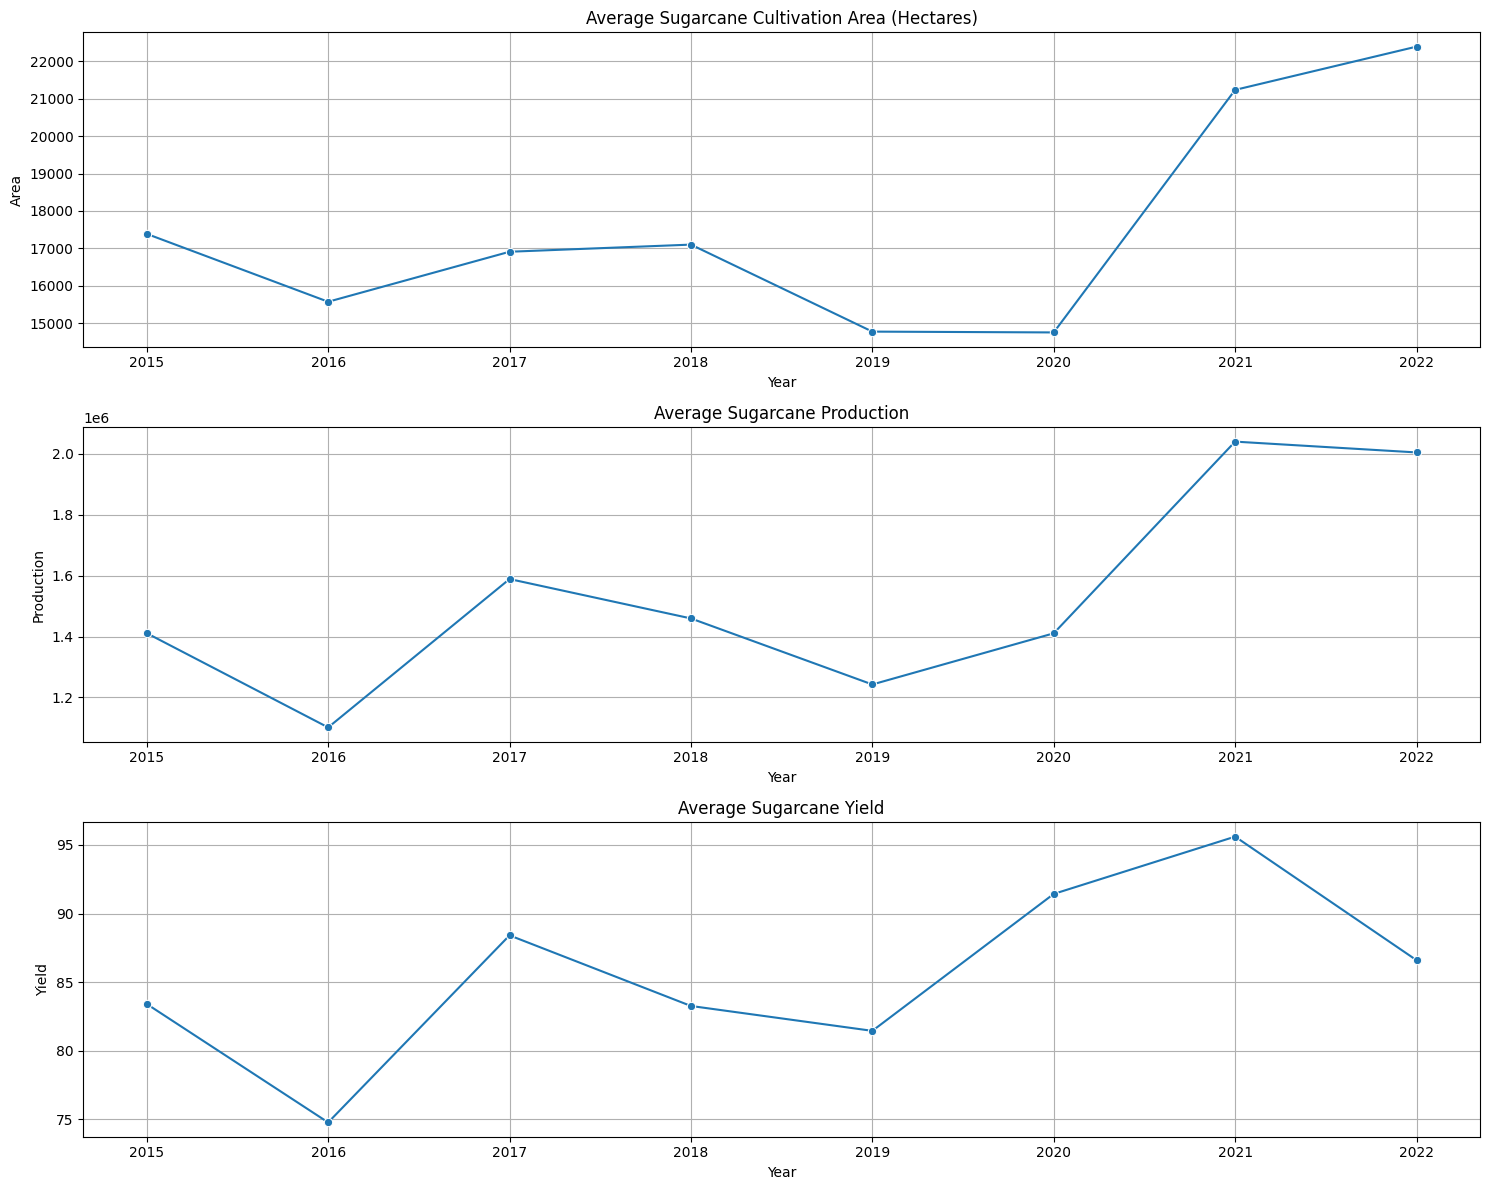

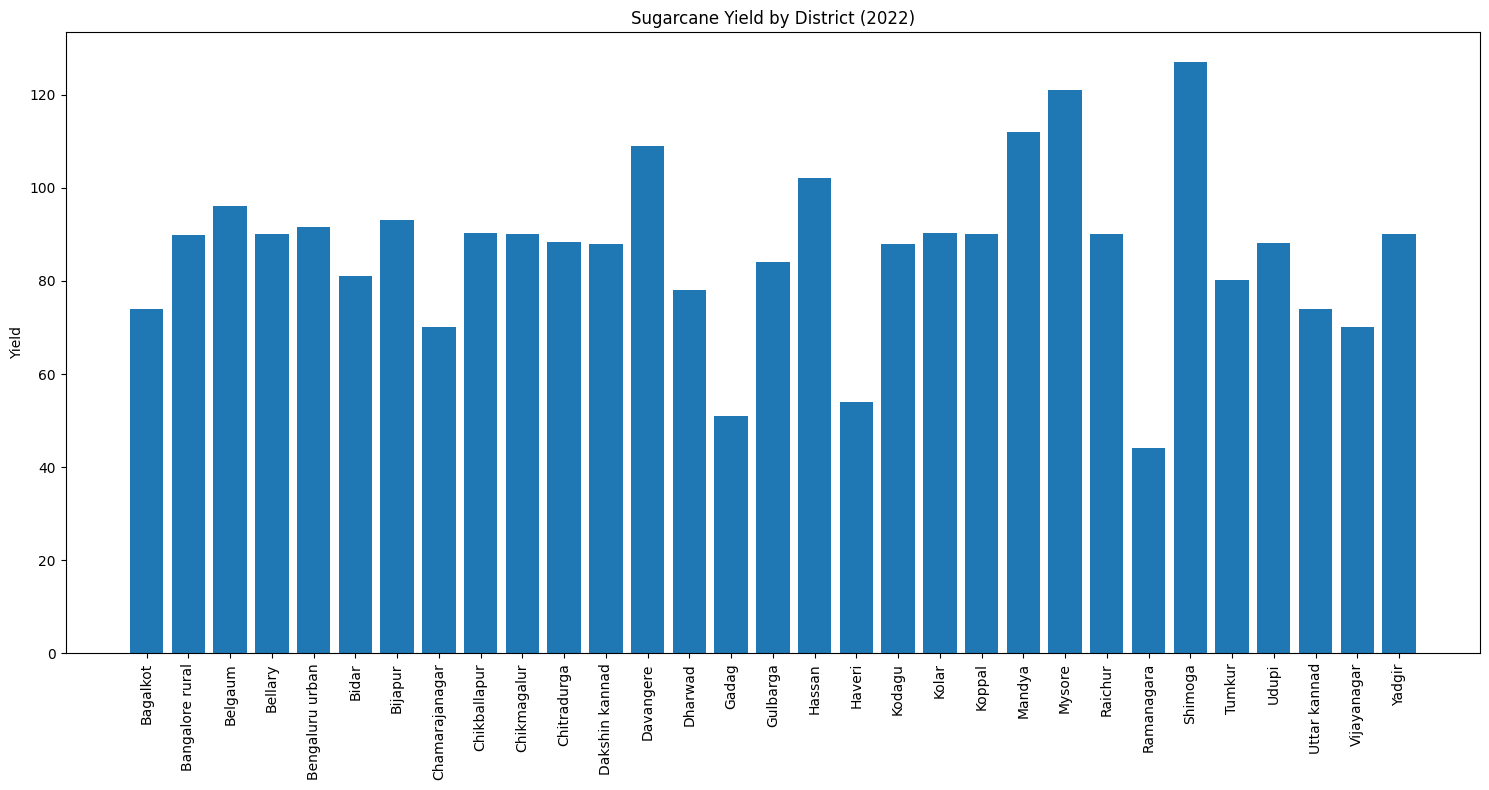

Weather data fetched for Bagalkot (2014-2022)
Fetching satellite features for Bagalkot in 2014
Fetching satellite features for Bagalkot in 2015
Fetching satellite features for Bagalkot in 2016
Fetching satellite features for Bagalkot in 2017
Fetching satellite features for Bagalkot in 2018
Fetching satellite features for Bagalkot in 2019
Fetching satellite features for Bagalkot in 2020
Fetching satellite features for Bagalkot in 2021
Fetching satellite features for Bagalkot in 2022
Satellite data processed for Bagalkot (2014-2022): 54 records
Weather data fetched for Bangalore rural (2014-2022)
Fetching satellite features for Bangalore rural in 2014
Fetching satellite features for Bangalore rural in 2015
Fetching satellite features for Bangalore rural in 2016
Fetching satellite features for Bangalore rural in 2017
Fetching satellite features for Bangalore rural in 2018
Fetching satellite features for Bangalore rural in 2019
Fetching satellite features for Bangalore rural in 2020
Fetchi

Test MAE for Sugarcane: nan

Sample predictions for Sugarcane in 2023:
No weather data for current year 2023, using zeros
Using estimated area: 95253.375 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Predicted Sugarcane yield for Bagalkot in 2023: nan
No weather data for current year 2023, using zeros
Using estimated area: 67.625 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Sugarcane yield for Bangalore rural in 2023: nan
No weather data for current year 2023, using zeros
Using estimated area: 212055.375 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Sugarcane yield for Belgaum in 2023: nan

==== Analysis for Coconut ====
Processed data for Coconut: 238 rows
Historical trends for Coconut:
   Year          Area    Production         Yield  Area_Change_Pct  \
0  2015  15087.793103  1.227287e+08   8458.398276              NaN   
1  2016  15571.678571  1.209315e+08   7945.246786         3.207132   
2  2017  14917.833333  1.144651e+08   8022.225667        -4.198939  

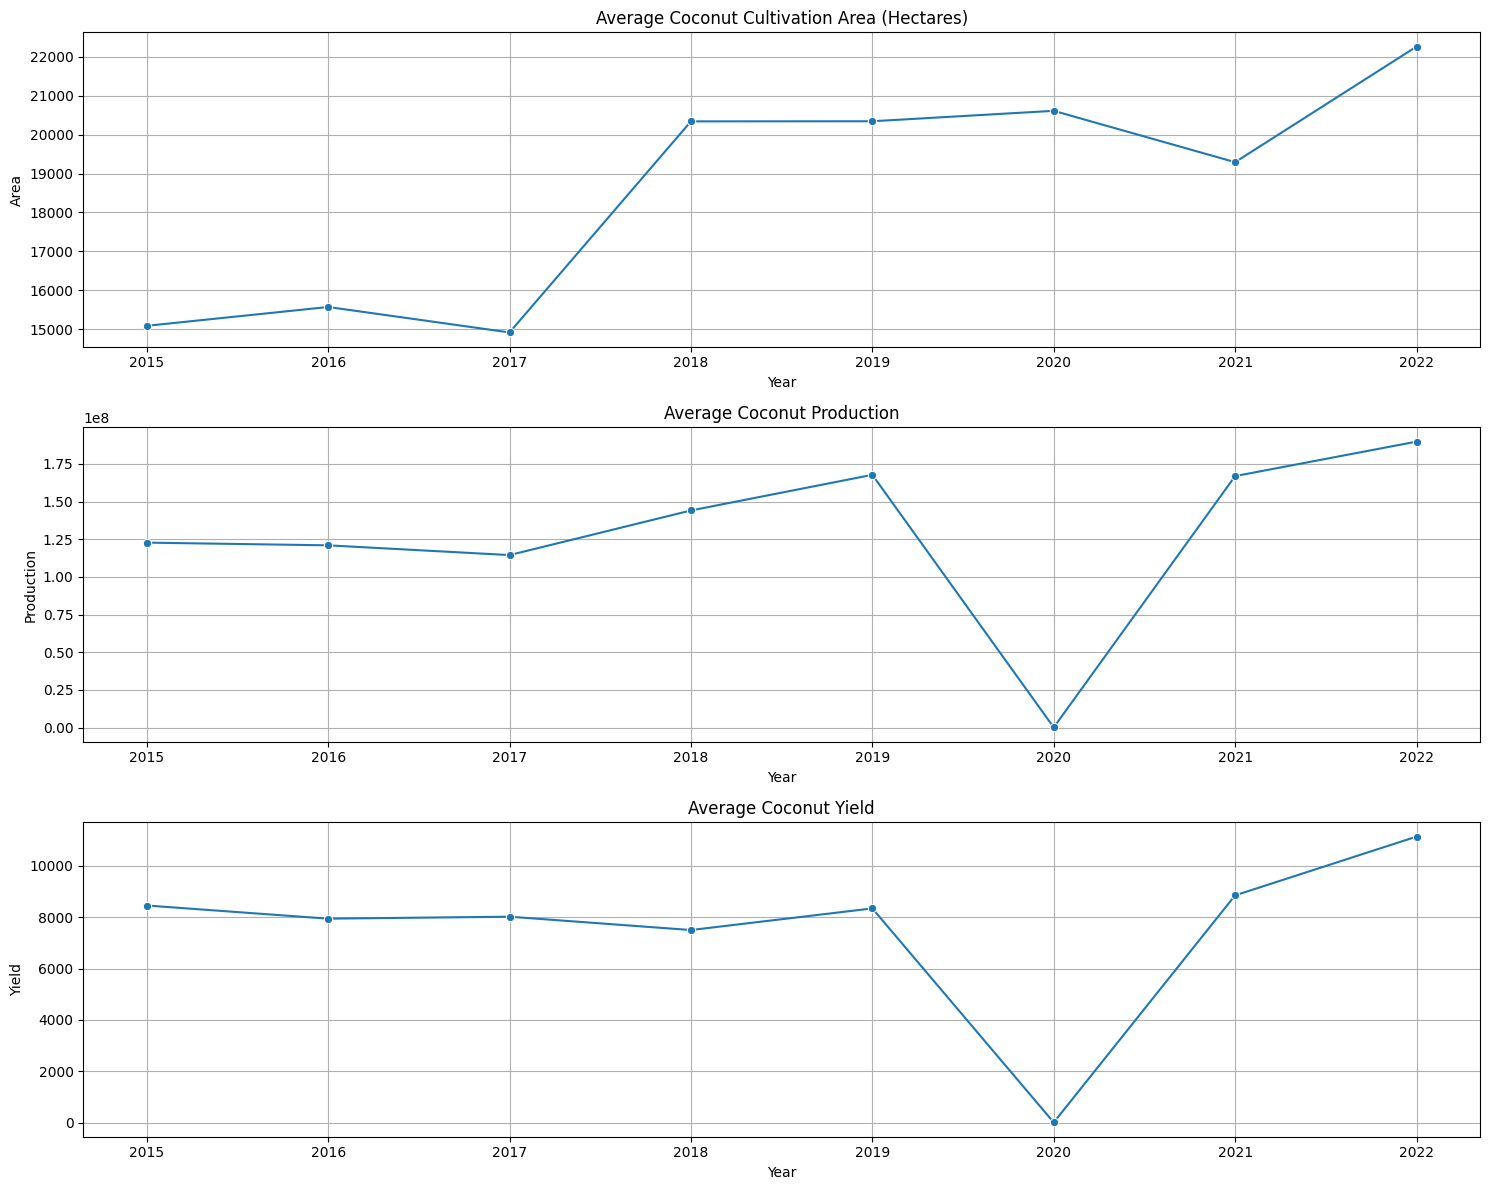

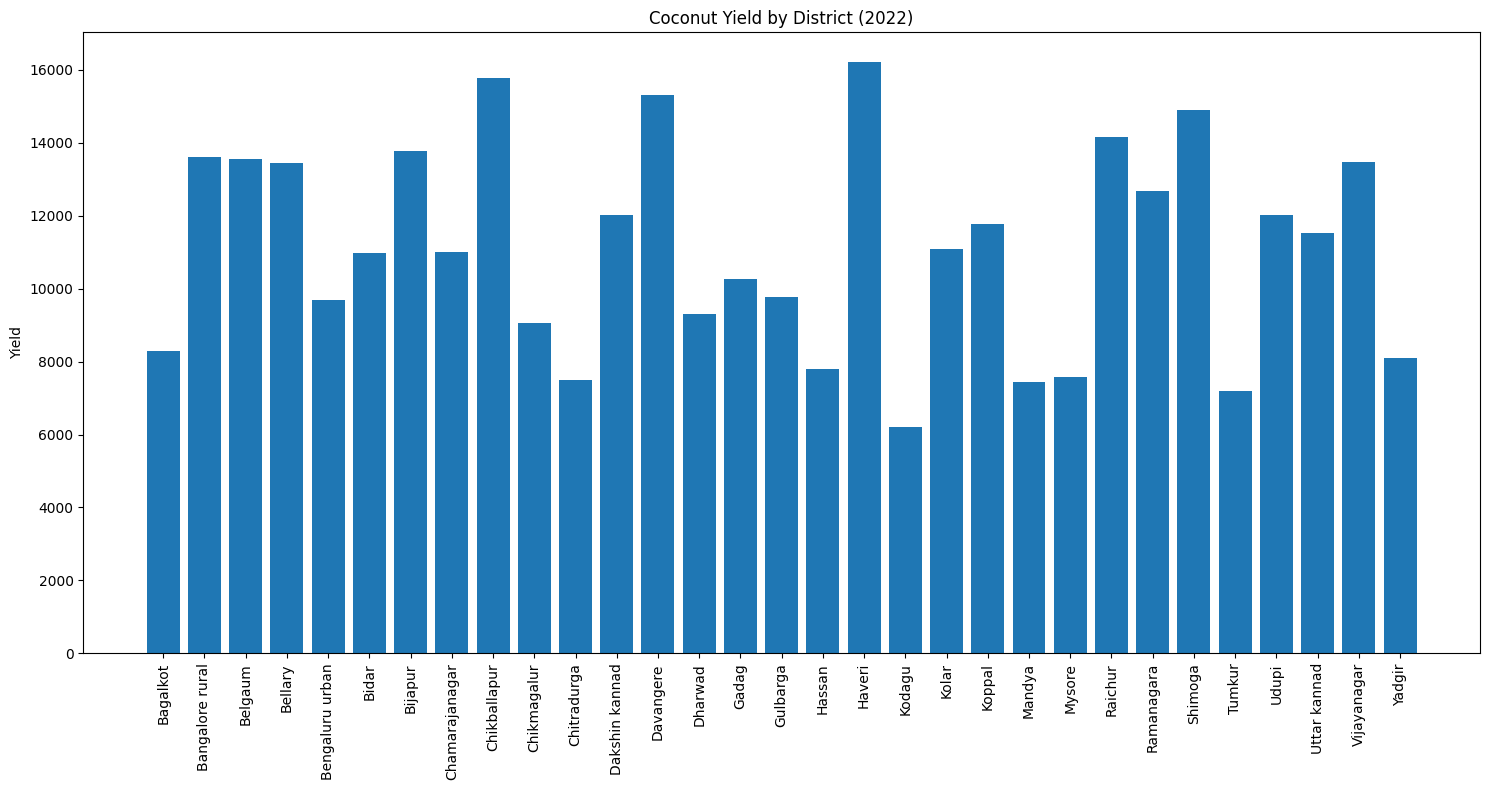

Skipping Vijayanagar due to insufficient crop data
Feature preparation complete: 237 samples
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - mae: nan -

Test MAE for Coconut: nan

Sample predictions for Coconut in 2023:
No weather data for current year 2023, using zeros
Using estimated area: 478.125 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Predicted Coconut yield for Bagalkot in 2023: nan
No weather data for current year 2023, using zeros
Using estimated area: 2904.375 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Coconut yield for Bangalore rural in 2023: nan
No weather data for current year 2023, using zeros
Using estimated area: 297.625 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Coconut yield for Belgaum in 2023: nan

==== Analysis for Arecanut ====
Processed data for Arecanut: 193 rows
Historical trends for Arecanut:
   Year          Area     Production      Yield  Area_Change_Pct  \
0  2015  11761.809524  115123.238095   9.910952              NaN   
1  2016  11549.954545  116891.136364   9.692273        -1.801211   
2  2017  13274.000000  143647.333333  10.570476        14.926859   
3  2018  19055.1

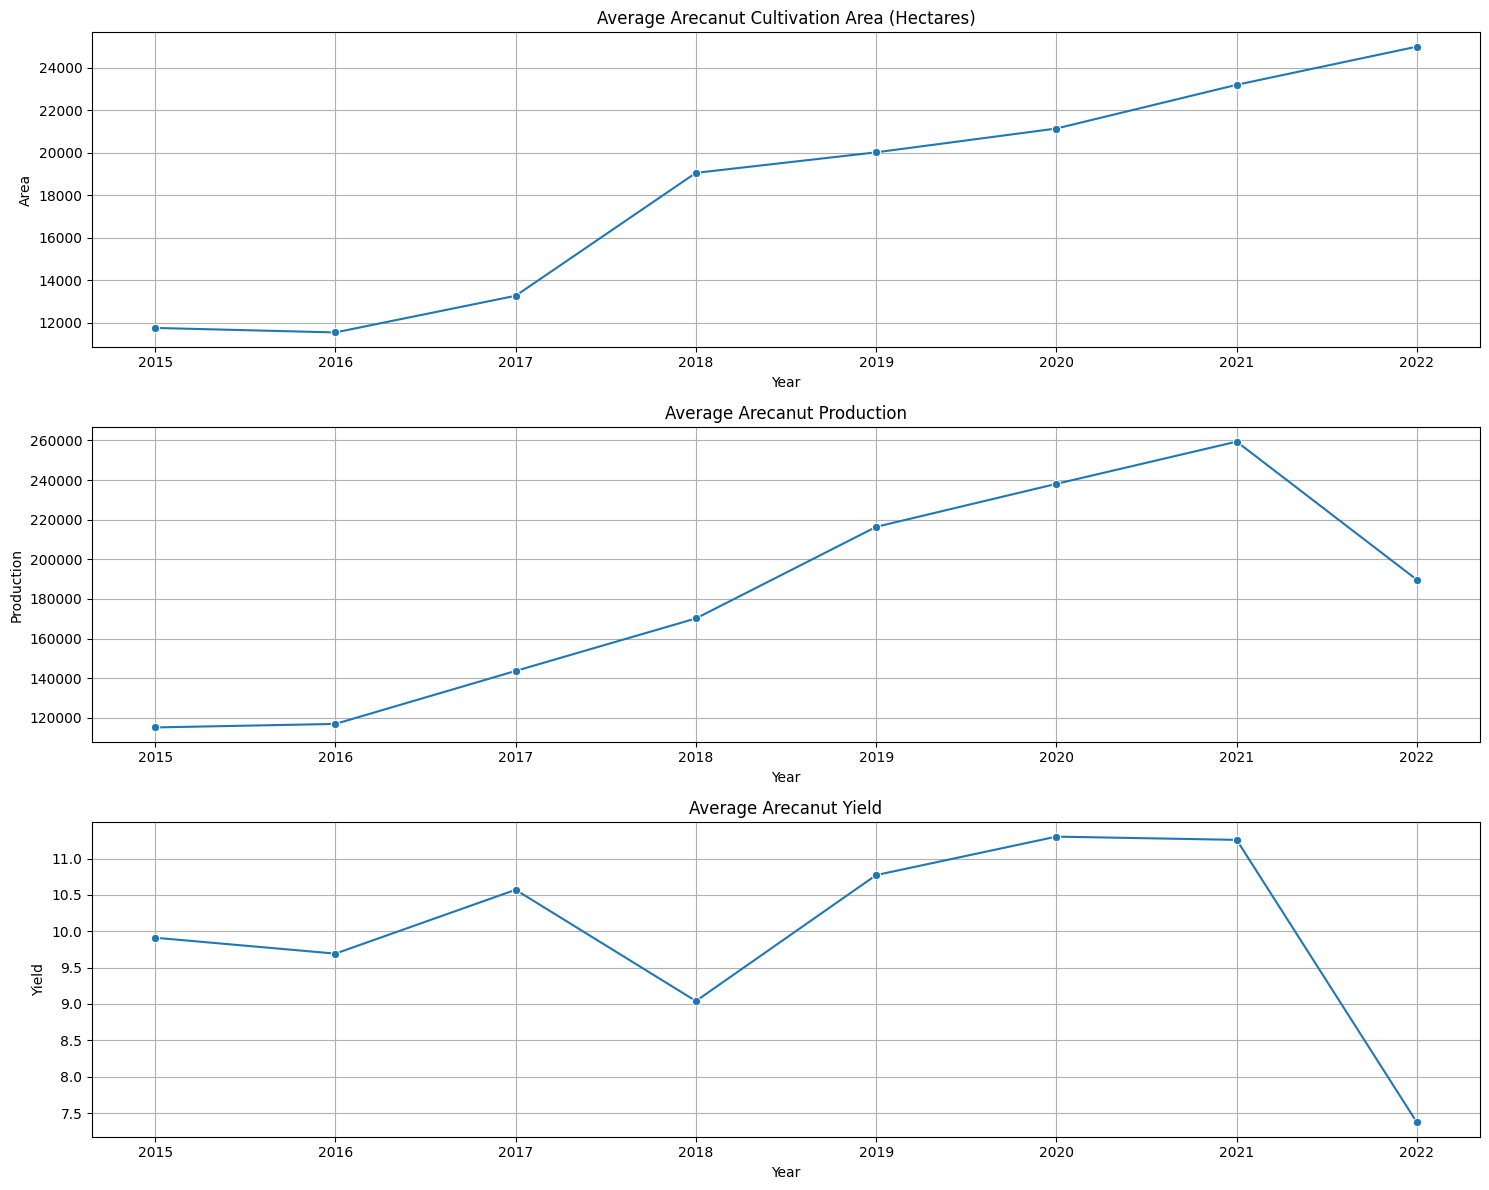

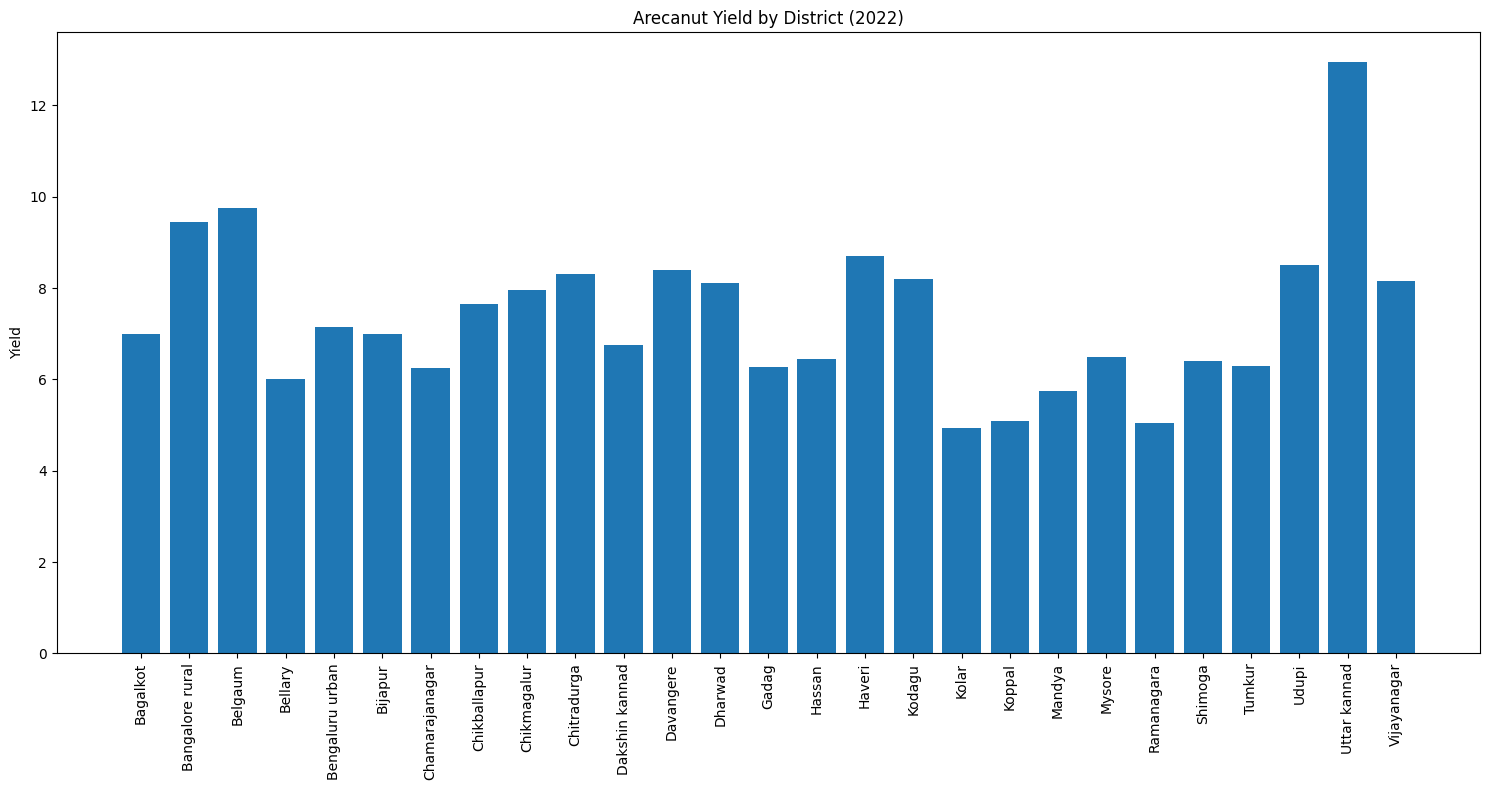

Skipping Gulbarga due to insufficient crop data
Skipping Vijayanagar due to insufficient crop data
Skipping Yadgir due to insufficient crop data
Feature preparation complete: 190 samples
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - mae: nan - val_loss:

Test MAE for Arecanut: nan

Sample predictions for Arecanut in 2023:
No weather data for current year 2023, using zeros
Using estimated area: 3.0 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Predicted Arecanut yield for Bagalkot in 2023: nan
No weather data for current year 2023, using zeros
Using estimated area: 2749.875 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Arecanut yield for Bangalore rural in 2023: nan
No weather data for current year 2023, using zeros
Using estimated area: 14.571428571428571 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Arecanut yield for Belgaum in 2023: nan

==== Analysis for Turmeric ====
Processed data for Turmeric: 201 rows
Historical trends for Turmeric:
   Year         Area   Production     Yield  Area_Change_Pct  \
0  2015   723.611111  3541.888889  4.622778              NaN   
1  2016  1045.823529  6441.176471  5.844706        44.528396   
2  2017   914.250000  5938.500000  6.282000       -12.580854   
3  2018   949.250000

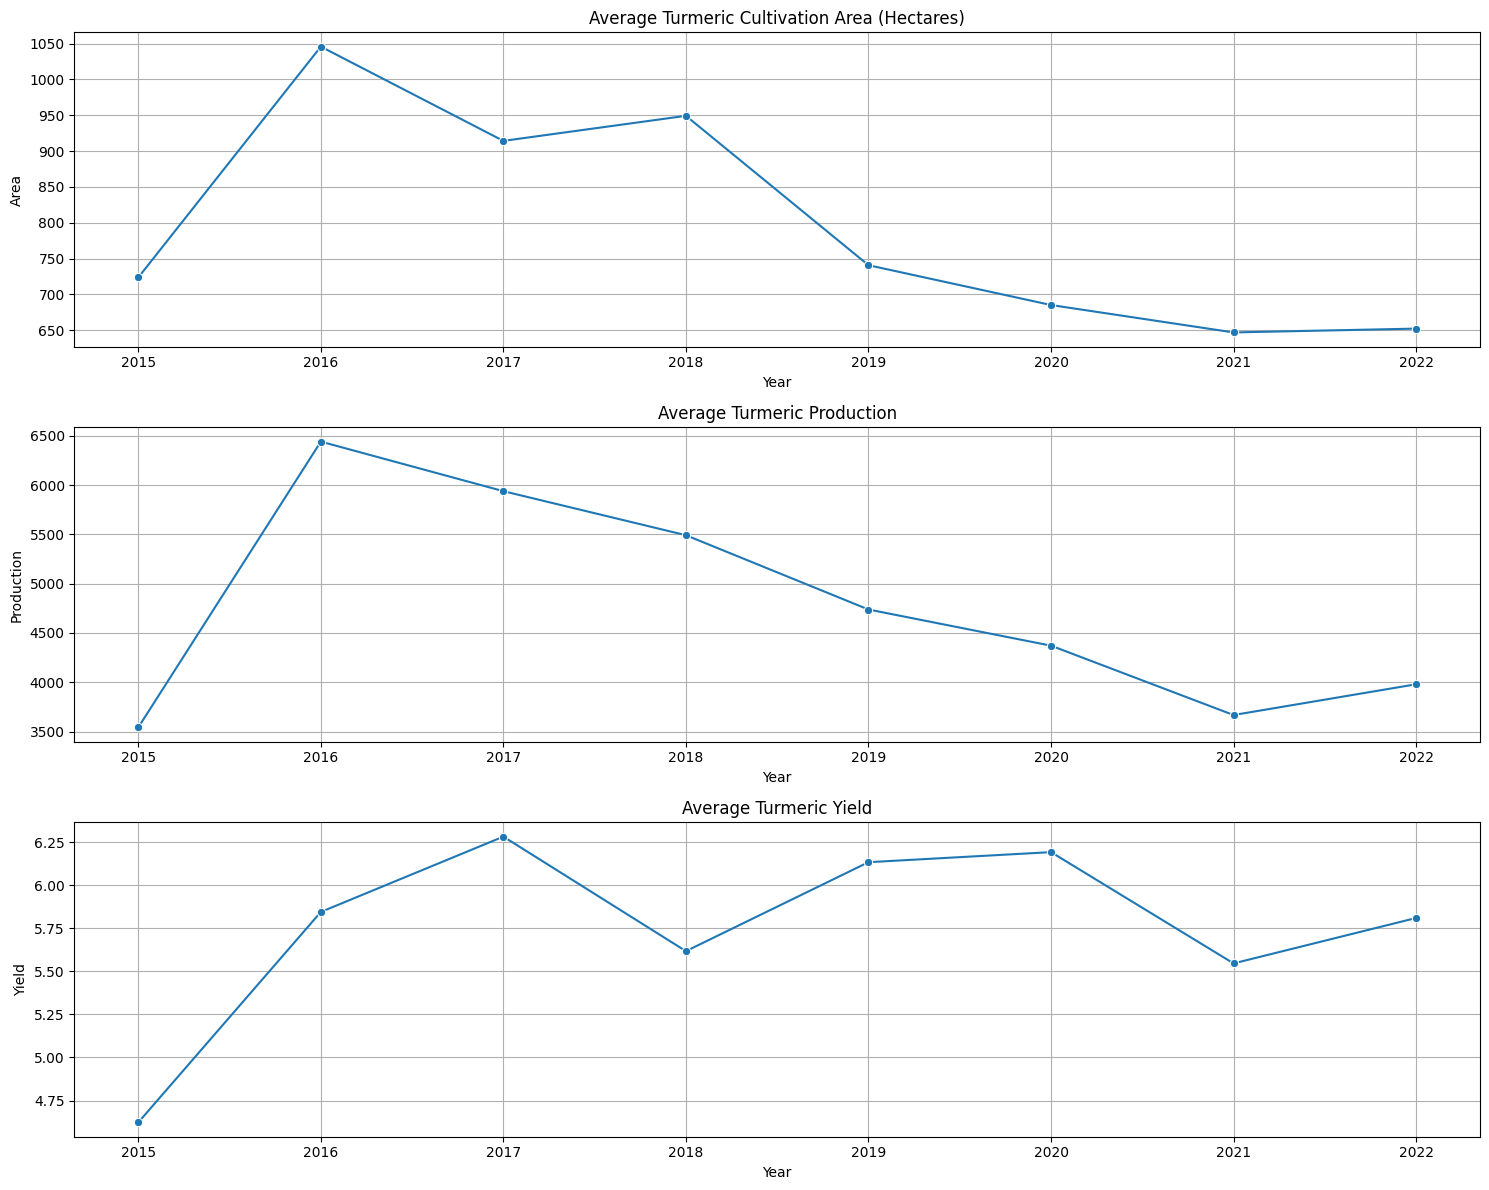

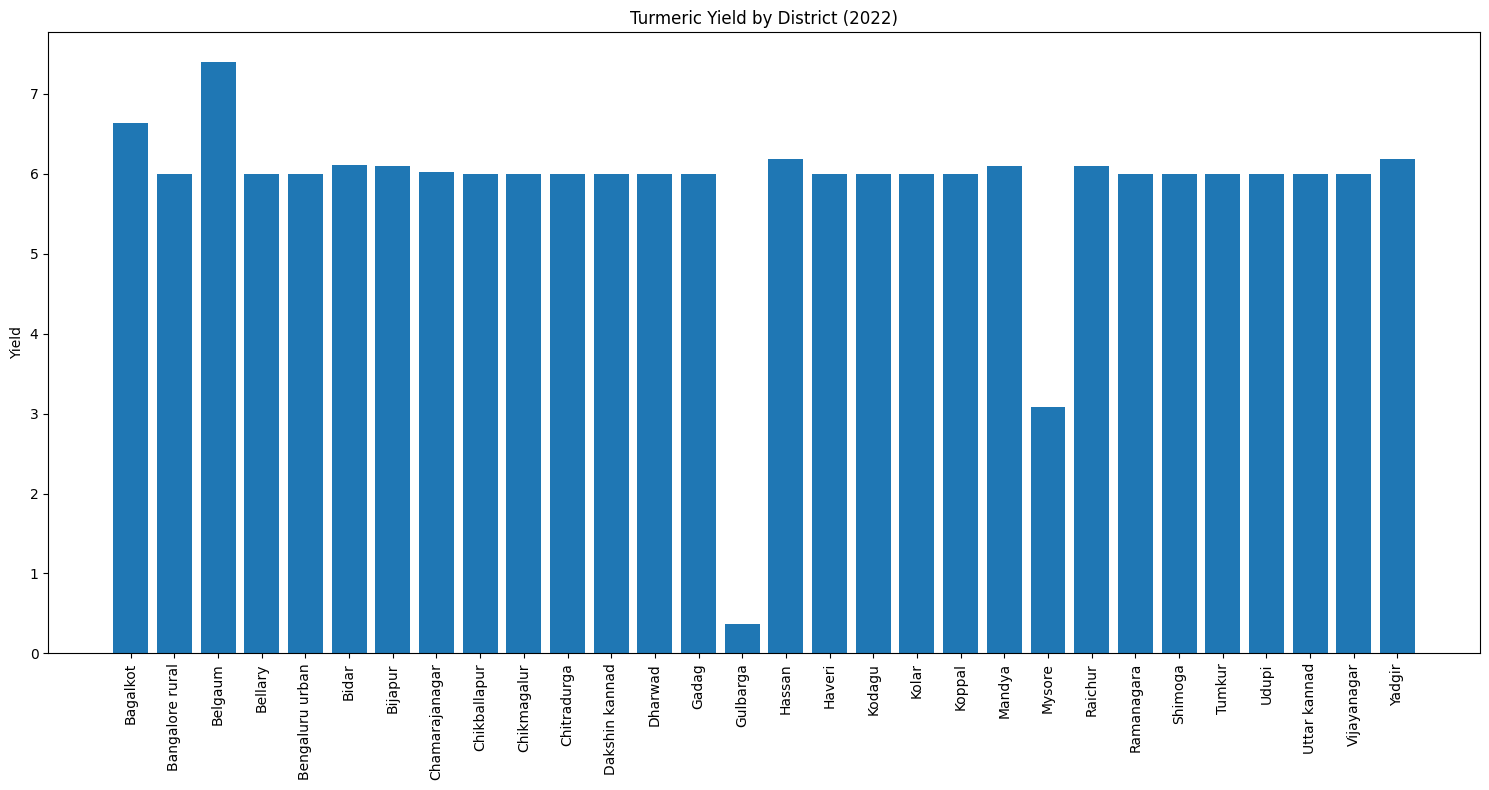

Skipping Vijayanagar due to insufficient crop data
Feature preparation complete: 200 samples
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: nan - mae: nan -

Test MAE for Turmeric: nan

Sample predictions for Turmeric in 2023:
No weather data for current year 2023, using zeros
Using estimated area: 3403.0 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predicted Turmeric yield for Bagalkot in 2023: nan
No weather data for current year 2023, using zeros
Using estimated area: 3.6666666666666665 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Turmeric yield for Bangalore rural in 2023: nan
No weather data for current year 2023, using zeros
Using estimated area: 5737.125 hectares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Turmeric yield for Belgaum in 2023: nan

==== Analysis for Banana ====
Processed data for Banana: 3 rows
Insufficient data for Banana, skipping...
Found 34 crop types: ['Coconut', 'Sugarcane', 'Cotton(lint)', 'Mango', 'Ginger', 'Pome Fruit', 'Grapes', 'Sannhamp', 'Citrus Fruit', 'Tomato', 'Potato', 'Coriander', 'Black pepper', 'Tobacco', 'Tapioca', 'Dry Ginger', 'Dry chillies', 'Cashewnut', 'Papaya', 'Arecanut', 

Test MAE for Coconut: nan
Model for Coconut evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Sugarcane...
Processed data for Sugarcane: 225 rows
Skipping Vijayanagar due to insufficient crop data
Feature preparation complete: 224 samples
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/50
6/6 ━━━━━━━━━

Test MAE for Sugarcane: nan
Model for Sugarcane evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Cotton(lint)...
Processed data for Cotton(lint): 126 rows
Skipping Bellary due to insufficient crop data
Skipping Chikballapur due to insufficient crop data
Skipping Gadag due to insufficient crop data
Skipping Vijayanagar due to insufficient crop data
Feature preparation complete: 41 samples
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: nan - mae: nan - val_

Test MAE for Cotton(lint): nan
Model for Cotton(lint) evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Mango...
Processed data for Mango: 0 rows
Insufficient data for Mango, skipping...

Evaluating model for Ginger...
Processed data for Ginger: 54 rows
Skipping Bagalkot due to insufficient crop data
Skipping Bidar due to insufficient crop data
Skipping Gadag due to insufficient crop data
Skipping Raichur due to insufficient crop data
Feature preparation complete: 38 samples
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: nan - mae: nan - val_loss: nan - 

Test MAE for Ginger: nan
Model for Ginger evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Pome Fruit...
Processed data for Pome Fruit: 116 rows
Skipping Gulbarga due to insufficient crop data
Skipping Hassan due to insufficient crop data
Skipping Kodagu due to insufficient crop data
Skipping Mysore due to insufficient crop data
Skipping Raichur due to insufficient crop data
Skipping Vijayanagar due to insufficient crop data
Feature preparation complete: 56 samples
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 516ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: n

Test MAE for Pome Fruit: nan
Model for Pome Fruit evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Grapes...
Processed data for Grapes: 0 rows
Insufficient data for Grapes, skipping...

Evaluating model for Sannhamp...
Processed data for Sannhamp: 59 rows
Skipping Bangalore rural due to insufficient crop data
Skipping Bengaluru urban due to insufficient crop data
Skipping Chikballapur due to insufficient crop data
Skipping Chikmagalur due to insufficient crop data
Skipping Davangere due to insufficient crop data
Skipping Shimoga due to insufficient crop data
Skipping Yadgir due to insufficient crop data
Feature preparation complete: 42 samples
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
2/2 ━━━━━

Test MAE for Sannhamp: nan
Model for Sannhamp evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Citrus Fruit...
Processed data for Citrus Fruit: 0 rows
Insufficient data for Citrus Fruit, skipping...

Evaluating model for Tomato...
Processed data for Tomato: 74 rows
Skipping Bijapur due to insufficient crop data
Skipping Davangere due to insufficient crop data
Skipping Hassan due to insufficient crop data
Skipping Haveri due to insufficient crop data
Skipping Koppal due to insufficient crop data
Feature preparation complete: 45 samples
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
2/2 ━━━━━━━━━━━━━━

Test MAE for Tomato: nan
Model for Tomato evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Potato...
Processed data for Potato: 0 rows
Insufficient data for Potato, skipping...

Evaluating model for Coriander...
Processed data for Coriander: 141 rows
Skipping Kodagu due to insufficient crop data
Skipping Raichur due to insufficient crop data
Skipping Uttar kannad due to insufficient crop data
Feature preparation complete: 134 samples
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
4/4 ━━━━━━━━━━━━━━

Test MAE for Coriander: nan
Model for Coriander evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Black pepper...
Processed data for Black pepper: 115 rows
Skipping Vijayanagar due to insufficient crop data
Feature preparation complete: 86 samples
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/50
3/3

Test MAE for Black pepper: nan
Model for Black pepper evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Tobacco...
Processed data for Tobacco: 148 rows
Skipping Yadgir due to insufficient crop data
Feature preparation complete: 122 samples
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/50
4/4 ━━━━━━━

Test MAE for Tobacco: nan
Model for Tobacco evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Tapioca...
Processed data for Tapioca: 17 rows
Skipping Bijapur due to insufficient crop data
Skipping Chitradurga due to insufficient crop data
Skipping Gulbarga due to insufficient crop data
Skipping Mandya due to insufficient crop data
Skipping Mysore due to insufficient crop data
Skipping Raichur due to insufficient crop data
Feature preparation complete: 6 samples
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Ep

Test MAE for Tapioca: nan
Model for Tapioca evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Dry Ginger...
Processed data for Dry Ginger: 0 rows
Insufficient data for Dry Ginger, skipping...

Evaluating model for Dry chillies...
Processed data for Dry chillies: 0 rows
Insufficient data for Dry chillies, skipping...

Evaluating model for Cashewnut...
Processed data for Cashewnut: 151 rows
Skipping Bijapur due to insufficient crop data
Feature preparation complete: 121 samples
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: nan - mae: nan - val_loss: nan - 

Test MAE for Cashewnut: nan
Model for Cashewnut evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Papaya...
Processed data for Papaya: 114 rows
Skipping Belgaum due to insufficient crop data
Skipping Bijapur due to insufficient crop data
Skipping Chitradurga due to insufficient crop data
Skipping Dharwad due to insufficient crop data
Skipping Gadag due to insufficient crop data
Skipping Vijayanagar due to insufficient crop data
Feature preparation complete: 12 samples
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: nan - mae: nan - val_loss: nan - val_mae

Test MAE for Papaya: nan
Model for Papaya evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Arecanut...
Processed data for Arecanut: 193 rows
Skipping Gulbarga due to insufficient crop data
Skipping Vijayanagar due to insufficient crop data
Skipping Yadgir due to insufficient crop data
Feature preparation complete: 190 samples
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 

Test MAE for Arecanut: nan
Model for Arecanut evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Onion...
Processed data for Onion: 1 rows
Insufficient data for Onion, skipping...

Evaluating model for Garlic...
Processed data for Garlic: 173 rows
Skipping Dakshin kannad due to insufficient crop data
Skipping Kodagu due to insufficient crop data
Feature preparation complete: 171 samples
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: nan - mae: nan - val_l

Test MAE for Garlic: nan
Model for Garlic evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Cashewnut Raw...
Processed data for Cashewnut Raw: 0 rows
Insufficient data for Cashewnut Raw, skipping...

Evaluating model for Arcanut (Processed)...
Processed data for Arcanut (Processed): 79 rows
Skipping Vijayanagar due to insufficient crop data
Skipping Yadgir due to insufficient crop data
Feature preparation complete: 77 samples
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━

Test MAE for Arcanut (Processed): nan
Model for Arcanut (Processed) evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Mesta...
Processed data for Mesta: 161 rows
Skipping Koppal due to insufficient crop data
Skipping Vijayanagar due to insufficient crop data
Feature preparation complete: 96 samples
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: nan - ma

Test MAE for Mesta: nan
Model for Mesta evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Other Fresh Fruits...
Processed data for Other Fresh Fruits: 18 rows
Skipping Hassan due to insufficient crop data
Skipping Mysore due to insufficient crop data
Skipping Yadgir due to insufficient crop data
No valid feature data generated
Error evaluating Other Fresh Fruits: not enough values to unpack (expected 3, got 2)

Evaluating model for Banana...
Processed data for Banana: 3 rows
Insufficient data for Banana, skipping...

Evaluating model for Atcanut (Raw)...
Processed data for Atcanut (Raw): 0 rows
Insufficient data for Atcanut (Raw), skipping...

Evaluating model for Cardamom...
Processed data for Cardamom: 2 rows
Insufficient data for Cardamom, skipping...

Evaluating model for Sweet potato...
Processed data for Sweet potato: 161 rows
Skipping Davangere due to insufficient crop data
Feature preparation complete: 160 samples
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/ste

Test MAE for Sweet potato: nan
Model for Sweet potato evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Cashewnut Processed...
Processed data for Cashewnut Processed: 0 rows
Insufficient data for Cashewnut Processed, skipping...

Evaluating model for Turmeric...
Processed data for Turmeric: 201 rows
Skipping Vijayanagar due to insufficient crop data
Feature preparation complete: 200 samples
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: nan - mae: nan - 

Test MAE for Turmeric: nan
Model for Turmeric evaluated: MAE = nan, Relative Error = nan%

Evaluating model for Peas & beans (Pulses)...
Processed data for Peas & beans (Pulses): 0 rows
Insufficient data for Peas & beans (Pulses), skipping...

Evaluating model for Brinjal...
Processed data for Brinjal: 0 rows
Insufficient data for Brinjal, skipping...

Model Evaluation Summary:
                     validation_mae   mean_yield  relative_error_percent  \
Coconut                         NaN  7542.450714                     NaN   
Sugarcane                       NaN    85.813467                     NaN   
Cotton(lint)                    NaN  4071.602063                     NaN   
Ginger                          NaN  1492.495000                     NaN   
Pome Fruit                      NaN   947.491466                     NaN   
Sannhamp                        NaN     0.375085                     NaN   
Tomato                          NaN  2381.497432                     NaN   
Coriander  

AttributeError: 'dict' object has no attribute 'sort_values'

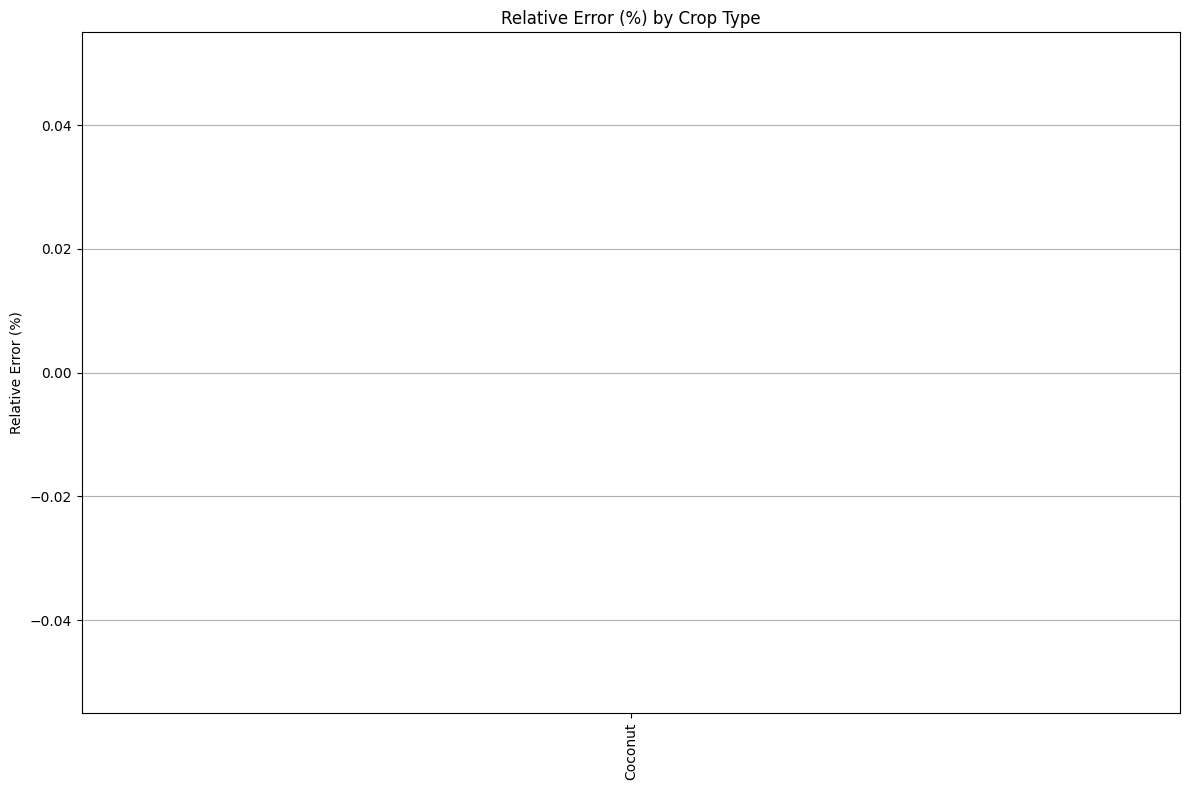

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, LSTM, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import ee
import geemap
import requests

# Initialize Earth Engine
try:
    ee.Initialize(project='positive-tempo-456012-d8')
except Exception:
    ee.Authenticate()
    ee.Initialize(project='positive-tempo-456012-d8')

# Sentinel-2 related bands and masks
S2_BANDS_FOR_VIS = ['B2', 'B3', 'B4', 'B8']        # Blue, Green, Red, NIR
S2_QA_BAND = 'QA60'                                # Quality band
S2_CLOUD_BIT_MASK = 1 << 10                        # Bit mask for clouds
S2_CIRRUS_BIT_MASK = 1 << 11                       # Bit mask for cirrus

# MODIS vegetation index source (fallback for pre-2016)
MODIS_VI_COLLECTION = 'MODIS/006/MOD13A1'
MODIS_NDVI_BAND = 'NDVI'
MODIS_EVI_BAND = 'EVI'
MODIS_VI_SCALE_FACTOR = 0.0001

# Sentinel-2 availability year
SENTINEL2_START_YEAR = 2016

# Monthly VI list (defines features used)
VI_LIST_S2 = ['NDVI', 'EVI', 'SAVI']
VI_LIST_MODIS = ['NDVI', 'EVI']
VI_FEATURE_SUPERSET = VI_LIST_S2  # You can widen this if needed

# Growing season used for VI aggregation
GROWING_SEASON_START_MONTH = 6
GROWING_SEASON_END_MONTH = 11
NUM_MONTHLY_TIMESTEPS = (GROWING_SEASON_END_MONTH - GROWING_SEASON_START_MONTH + 1)

def mask_s2_clouds_gee(image):
    qa = image.select(S2_QA_BAND)
    cloud_mask = qa.bitwiseAnd(S2_CLOUD_BIT_MASK).eq(0)
    cirrus_mask = qa.bitwiseAnd(S2_CIRRUS_BIT_MASK).eq(0)
    return image.updateMask(cloud_mask).updateMask(cirrus_mask).select(S2_BANDS_FOR_VIS).divide(10000.0)

def calculate_s2_vis_gee(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1.0))',
        {'NIR': image.select('B8'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}
    ).rename('EVI')
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * (1.5)',
        {'NIR': image.select('B8'), 'RED': image.select('B4')}
    ).rename('SAVI')
    return image.addBands([ndvi, evi, savi])


class CropYieldPredictor:
    def __init__(self, data_path='final.csv'):
        """
        Initialize the crop yield prediction model

        Parameters:
        -----------
        data_path : str
            Path to the CSV file containing crop yield data
        """
        self.data_path = data_path
        self.data = None
        self.processed_data = None
        self.district_coordinates = self._load_district_coordinates()
        self.weather_data = {}
        self.satellite_data = {}
        self.models = {}

    def _load_district_coordinates(self):
        """Load district coordinates for Karnataka"""
        # Dictionary of Karnataka district coordinates (center points)
        return {
            'Bagalkot': [75.7010, 16.1691],
            'Bangalore rural': [77.6832, 13.2854],
            'Belgaum': [74.4977, 15.8497],
            'Bellary': [76.9214, 15.1394],
            'Bengaluru urban': [77.5946, 12.9716],
            'Bidar': [77.5500, 17.9144],
            'Bijapur': [75.7154, 16.8302],
            'Chamarajanagar': [76.9390, 11.9262],
            'Chikballapur': [77.7315, 13.4356],
            'Chikmagalur': [75.7804, 13.3161],
            'Chitradurga': [76.4010, 14.2250],
            'Dakshin kannad': [75.0337, 12.8698],
            'Davangere': [75.9200, 14.4644],
            'Dharwad': [75.0080, 15.4589],
            'Gadag': [75.6200, 15.4315],
            'Gulbarga': [76.8343, 17.3297],
            'Hassan': [76.0962, 13.0068],
            'Haveri': [75.4000, 14.7949],
            'Kodagu': [75.7339, 12.3375],
            'Kolar': [78.1324, 13.1357],
            'Koppal': [76.1562, 15.3442],
            'Mandya': [76.8956, 12.5218],
            'Mysore': [76.6394, 12.2958],
            'Raichur': [77.3566, 16.2120],
            'Ramanagara': [77.2807, 12.7223],
            'Shimoga': [75.5681, 13.9299],
            'Tumkur': [77.1025, 13.3379],
            'Udupi': [74.7421, 13.3409],
            'Uttar kannad': [74.4858, 14.7935],
            'Vijayanagar': [76.3820, 15.2289],
            'Yadgir': [77.1315, 16.7689]
        }

    def load_data(self):
        """Load and perform initial cleaning of the crop data"""
        # Load the data
        self.data = pd.read_csv(self.data_path)

        # Basic cleaning
        # Convert year column to consistent format
        self.data['Year'] = pd.to_numeric(self.data['Year'].str.split(' - ').str[0], errors='coerce')
        self.data = self.data.dropna(subset=['Year'])
        self.data['Year'] = self.data['Year'].astype(int)


        # Replace empty strings with NaN
        self.data = self.data.replace('', np.nan)

        # Convert numeric columns to appropriate types
        for col in self.data.columns:
            if 'Area' in col or 'Production' in col or 'Yield' in col:
                self.data[col] = pd.to_numeric(self.data[col], errors='coerce')

        print(f"Data loaded: {self.data.shape[0]} rows and {self.data.shape[1]} columns")
        return self.data

    def preprocess_data(self, crop_type):
        """
        Preprocess the data for a specific crop type

        Parameters:
        -----------
        crop_type : str
            The crop type to focus on (e.g., 'Sugarcane', 'Coconut')
        """
        if self.data is None:
            self.load_data()

        # Filter for the specified crop
        area_col = f"{crop_type} - Area (Hectare)"
        production_col = f"{crop_type} - Production (Tonnes)"
        if "Coconut" in crop_type:
            production_col = f"{crop_type} - Production (Nuts)"
        elif "Cotton" in crop_type or "Mesta" in crop_type:
            production_col = f"{crop_type} - Production (Bales)"

        yield_col = f"{crop_type} - Yield (Tonne/Hectare)"
        if "Coconut" in crop_type:
            yield_col = f"{crop_type} - Yield (Nuts/Hectare)"
        elif "Cotton" in crop_type or "Mesta" in crop_type:
            yield_col = f"{crop_type} - Yield (Bales/Hectare)"

        # Filter districts that have the crop data
        crop_data = self.data[['State', 'District', 'Year', area_col, production_col, yield_col]].copy()

        # Drop rows where yield is NaN
        crop_data = crop_data.dropna(subset=[yield_col])

        # Standardize column names
        crop_data.columns = ['State', 'District', 'Year', 'Area', 'Production', 'Yield']

        # Sort by district and year
        crop_data = crop_data.sort_values(['District', 'Year'])

        self.processed_data = crop_data
        print(f"Processed data for {crop_type}: {crop_data.shape[0]} rows")
        return crop_data

    def fetch_weather_data(self, district, start_year, end_year):
        """
        Fetch weather data from NASA POWER API for a specific district

        Parameters:
        -----------
        district : str
            District name
        start_year : int
            Start year for data
        end_year : int
            End year for data

        Returns:
        --------
        DataFrame with weather data
        """
        if district not in self.district_coordinates:
            print(f"Coordinates not found for district: {district}")
            return None

        lon, lat = self.district_coordinates[district]

        # Format dates
        start_date = f"{start_year}0101"
        end_date = f"{end_year}1231"

        # Parameters to fetch
        parameters = "T2M,PRECTOTCORR,RH2M,WS2M,ALLSKY_SFC_SW_DWN"

        # Construct API URL
        url = (
            f"https://power.larc.nasa.gov/api/temporal/daily/point"
            f"?parameters={parameters}"
            f"&community=AG"
            f"&longitude={lon}"
            f"&latitude={lat}"
            f"&start={start_date}"
            f"&end={end_date}"
            f"&format=JSON"
        )

        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()

            # Convert to DataFrame
            weather_df = pd.DataFrame(data['properties']['parameter'])

            # Reset index which contains dates
            weather_df = weather_df.reset_index().rename(columns={'index': 'DATE'})

            # Convert date to datetime
            weather_df['DATE'] = pd.to_datetime(weather_df['DATE'], format='%Y%m%d')

            # Add district column
            weather_df['District'] = district

            # Add year column
            weather_df['Year'] = weather_df['DATE'].dt.year

            # Store in the weather_data dictionary
            self.weather_data[district] = weather_df

            print(f"Weather data fetched for {district} ({start_year}-{end_year})")
            return weather_df

        except Exception as e:
            print(f"Error fetching weather data for {district}: {e}")
            return None

    def fetch_satellite_data(self, district, start_year, end_year):
      """
      Fetch Sentinel-2 (or MODIS) satellite imagery and compute vegetation indices per month.
      """
      if district not in self.district_coordinates:
          print(f"Coordinates not found for district: {district}")
          return None

      lon, lat = self.district_coordinates[district]
      point = ee.Geometry.Point([lon, lat])
      region = point.buffer(10000)

      all_years_data = []

      for year in range(start_year, end_year + 1):
          print(f"Fetching satellite features for {district} in {year}")
          try:
              monthly_vi = get_monthly_gee_satellite_features(
                  aoi_geometry=region,
                  year=year,
                  start_month=6,
                  end_month=11
              )

              for month_idx in range(6, 12):  # Months 6 to 11
                  row = {
                      'District': district,
                      'Year': year,
                      'Month': month_idx
                  }
                  for vi in VI_FEATURE_SUPERSET:
                      vi_series = monthly_vi.get(f'{vi}_monthly_series', [np.nan]*6)
                      row[vi] = vi_series[month_idx - 6] if month_idx - 6 < len(vi_series) else np.nan
                  all_years_data.append(row)

          except Exception as e:
              print(f"Error fetching satellite data for {district}, {year}: {e}")

      df = pd.DataFrame(all_years_data)
      self.satellite_data[district] = df
      print(f"Satellite data processed for {district} ({start_year}-{end_year}): {len(df)} records")
      return df


    def prepare_features(self, crop_type, sequence_length=12):
        """
        Prepare features for the model by combining crop, weather, and satellite data

        Parameters:
        -----------
        crop_type : str
            The crop type to focus on
        sequence_length : int
            Number of time steps for LSTM input

        Returns:
        --------
        X, y : Features and target arrays
        """
        if self.processed_data is None:
            self.preprocess_data(crop_type)

        # Get unique districts and years
        districts = self.processed_data['District'].unique()
        min_year = self.processed_data['Year'].min()
        max_year = self.processed_data['Year'].max()

        # Fetch weather and satellite data for all districts
        for district in districts:
            if district not in self.weather_data:
                self.fetch_weather_data(district, min_year-1, max_year)
            if district not in self.satellite_data:
                self.fetch_satellite_data(district, min_year-1, max_year)

        # Prepare features for each district-year combination
        feature_data = []

        for district in districts:
            district_crop_data = self.processed_data[self.processed_data['District'] == district]

            # Skip districts with insufficient data
            if len(district_crop_data) < 2:
                print(f"Skipping {district} due to insufficient crop data")
                continue

            # Get weather and satellite data
            district_weather = self.weather_data.get(district)
            district_satellite = self.satellite_data.get(district)

            if district_weather is None or district_satellite is None:
                print(f"Skipping {district} due to missing weather or satellite data")
                continue

            # Aggregate weather data by year
            yearly_weather = district_weather.groupby('Year').agg({
                'T2M': 'mean',               # Average temperature
                'PRECTOTCORR': 'sum',        # Total precipitation
                'RH2M': 'mean',              # Average relative humidity
                'WS2M': 'mean',              # Average wind speed
                'ALLSKY_SFC_SW_DWN': 'mean'  # Average solar radiation
            }).reset_index()

            # Aggregate satellite indices by year
            if len(district_satellite) > 0:
                yearly_satellite = district_satellite.groupby('Year').agg({
                    'NDVI': 'mean',
                    'EVI': 'mean',
                    'SAVI': 'mean'
                }).reset_index()
            else:
                # Create empty dataframe if no satellite data
                yearly_satellite = pd.DataFrame(columns=['Year', 'NDVI', 'EVI', 'SAVI'])

            # Create sequences for each year with available yield data
            for year in district_crop_data['Year'].unique():
                # Get target yield for this year
                target_yield = district_crop_data[district_crop_data['Year'] == year]['Yield'].values[0]
                target_area = district_crop_data[district_crop_data['Year'] == year]['Area'].values[0]

                # Skip if yield or area is NaN or zero
                if pd.isna(target_yield) or pd.isna(target_area) or target_yield == 0 or target_area == 0:
                    continue

                # Create sequence of previous years' data
                prev_years = list(range(year - sequence_length, year))

                # Weather features for sequence
                weather_sequence = []
                for prev_year in prev_years:
                    year_weather = yearly_weather[yearly_weather['Year'] == prev_year]
                    if len(year_weather) > 0:
                        weather_sequence.append(year_weather[['T2M', 'PRECTOTCORR', 'RH2M', 'WS2M', 'ALLSKY_SFC_SW_DWN']].values[0])
                    else:
                        # Use zeros if weather data not available
                        weather_sequence.append(np.zeros(5))

                # Check if we have enough weather sequence data
                if len(weather_sequence) < sequence_length:
                    # Pad with zeros if needed
                    weather_sequence = [np.zeros(5)] * (sequence_length - len(weather_sequence)) + weather_sequence

                # Satellite features for sequence
                satellite_sequence = []
                for prev_year in prev_years:
                    year_satellite = yearly_satellite[yearly_satellite['Year'] == prev_year]
                    if len(year_satellite) > 0:
                        satellite_sequence.append(year_satellite[['NDVI', 'EVI', 'SAVI']].values[0])
                    else:
                        # Use zeros if satellite data not available
                        satellite_sequence.append(np.zeros(3))

                # Check if we have enough satellite sequence data
                if len(satellite_sequence) < sequence_length:
                    # Pad with zeros if needed
                    satellite_sequence = [np.zeros(3)] * (sequence_length - len(satellite_sequence)) + satellite_sequence

                # Current year's weather (for static features)
                current_weather = yearly_weather[yearly_weather['Year'] == year]
                if len(current_weather) > 0:
                    current_weather_features = current_weather[['T2M', 'PRECTOTCORR', 'RH2M', 'WS2M', 'ALLSKY_SFC_SW_DWN']].values[0]
                else:
                    current_weather_features = np.zeros(5)

                # Add to feature data
                feature_data.append({
                    'district': district,
                    'year': year,
                    'weather_sequence': np.array(weather_sequence),
                    'satellite_sequence': np.array(satellite_sequence),
                    'current_weather': current_weather_features,
                    'target_area': target_area,
                    'target_yield': target_yield
                })

        # Create numpy arrays for model input
        if len(feature_data) == 0:
            print("No valid feature data generated")
            return None, None

        X_weather_seq = np.array([d['weather_sequence'] for d in feature_data])
        X_satellite_seq = np.array([d['satellite_sequence'] for d in feature_data])
        X_current_weather = np.array([d['current_weather'] for d in feature_data])
        X_area = np.array([d['target_area'] for d in feature_data]).reshape(-1, 1)
        y = np.array([d['target_yield'] for d in feature_data])

        # Create sample metadata
        metadata = pd.DataFrame({
            'district': [d['district'] for d in feature_data],
            'year': [d['year'] for d in feature_data],
            'target_yield': y
        })

        print(f"Feature preparation complete: {len(feature_data)} samples")

        # Return X as a dict of inputs and y as target
        X = {
            'weather_sequence': X_weather_seq,
            'satellite_sequence': X_satellite_seq,
            'current_weather': X_current_weather,
            'area': X_area
        }

        return X, y, metadata

    def build_model(self, input_shapes):
        """
        Build a hybrid CNN-LSTM model for crop yield prediction

        Parameters:
        -----------
        input_shapes : dict
            Dictionary of input shapes for different features

        Returns:
        --------
        Compiled model
        """
        # Weather sequence input (LSTM branch)
        weather_seq_input = Input(shape=input_shapes['weather_sequence'], name='weather_sequence')
        weather_lstm = LSTM(64, return_sequences=False)(weather_seq_input)
        weather_dense = Dense(32, activation='relu')(weather_lstm)

        # Satellite sequence input (CNN-LSTM branch)
        # Reshape satellite sequence for CNN
        satellite_seq_input = Input(shape=input_shapes['satellite_sequence'], name='satellite_sequence')
        # Reshape to (batch_size, time_steps, features, 1) for 1D CNN
        satellite_reshaped = tf.keras.layers.Reshape(
            (input_shapes['satellite_sequence'][0], input_shapes['satellite_sequence'][1], 1)
        )(satellite_seq_input)

        # CNN layers
        satellite_conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(satellite_reshaped)
        satellite_pool1 = MaxPooling2D(pool_size=(2, 1))(satellite_conv1)
        satellite_conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(satellite_pool1)
        satellite_pool2 = MaxPooling2D(pool_size=(2, 1))(satellite_conv2)

        # Flatten and dense
        satellite_flat = Flatten()(satellite_pool2)
        satellite_dense = Dense(32, activation='relu')(satellite_flat)

        # Current weather input (static features)
        current_weather_input = Input(shape=input_shapes['current_weather'], name='current_weather')
        current_weather_dense = Dense(16, activation='relu')(current_weather_input)

        # Area input
        area_input = Input(shape=input_shapes['area'], name='area')
        area_dense = Dense(8, activation='relu')(area_input)

        # Merge all features
        merged = Concatenate()([weather_dense, satellite_dense, current_weather_dense, area_dense])

        # Output layers
        dense1 = Dense(64, activation='relu')(merged)
        dropout = Dropout(0.3)(dense1)
        dense2 = Dense(32, activation='relu')(dropout)
        output = Dense(1, activation='linear')(dense2)

        # Create model
        model = Model(
            inputs=[weather_seq_input, satellite_seq_input, current_weather_input, area_input],
            outputs=output
        )

        # Compile model
        model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mae']
        )

        return model

    def train_model(self, crop_type, epochs=100, batch_size=32, validation_split=0.2):
        """
        Train the model for a specific crop type

        Parameters:
        -----------
        crop_type : str
            The crop type to focus on
        epochs : int
            Number of training epochs
        batch_size : int
            Batch size for training
        validation_split : float
            Fraction of data to use for validation

        Returns:
        --------
        Trained model and training history
        """
        # Prepare features and target
        X, y, metadata = self.prepare_features(crop_type)

        if X is None or y is None:
            print(f"No valid data for training model for {crop_type}")
            return None, None

        # Split data into train and test sets
        X_train = {}
        X_test = {}

        # Get indices for train and test
        indices = np.arange(len(y))
        train_indices, test_indices = train_test_split(indices, test_size=validation_split, random_state=42)

        # Split each input
        for key in X:
            X_train[key] = X[key][train_indices]
            X_test[key] = X[key][test_indices]

        y_train = y[train_indices]
        y_test = y[test_indices]

        # Create input shapes dictionary
        input_shapes = {
            'weather_sequence': X['weather_sequence'].shape[1:],
            'satellite_sequence': X['satellite_sequence'].shape[1:],
            'current_weather': X['current_weather'].shape[1:],
            'area': X['area'].shape[1:]
        }

        # Build model
        model = self.build_model(input_shapes)

        # Define callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ModelCheckpoint(f'best_model_{crop_type}.h5', save_best_only=True, monitor='val_loss')
        ]

        # Train model
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )

        # Evaluate model
        test_loss, test_mae = model.evaluate(X_test, y_test)
        print(f"Test MAE for {crop_type}: {test_mae:.4f}")

        # Save model
        model.save(f'crop_yield_model_{crop_type}.h5')

        # Store model
        self.models[crop_type] = model

        return model, history

    def predict_yield(self, crop_type, district, year, area=None, coordinates=None):
        """
        Predict crop yield for a specific district and year

        Parameters:
        -----------
        crop_type : str
            The crop type to predict
        district : str
            District name (or None if using coordinates)
        year : int
            Year to predict
        area : float
            Cultivation area in hectares (optional, will use average if None)
        coordinates : list
            [longitude, latitude] if district is None

        Returns:
        --------
        Predicted yield
        """
        # If coordinates are provided, find the district
        if district is None and coordinates is not None:
            district = self._find_nearest_district(coordinates)
            print(f"Using district {district} for coordinates {coordinates}")

        # Check if model exists for crop type
        if crop_type not in self.models:
            print(f"No model found for {crop_type}. Training new model...")
            self.train_model(crop_type)

        # Check if model exists now
        if crop_type not in self.models:
            print(f"Could not train model for {crop_type}")
            return None

        # Load model
        model = self.models[crop_type]

        # Get sequence_length from model
        sequence_length = model.input_shape[0][1]  # From weather_sequence input

        # Get weather data for the district
        if district not in self.weather_data:
            self.fetch_weather_data(district, year-sequence_length, year)

        # Get satellite data for the district
        if district not in self.satellite_data:
            self.fetch_satellite_data(district, year-sequence_length, year)

        # Prepare weather sequence
        district_weather = self.weather_data.get(district)
        if district_weather is None:
            print(f"No weather data available for {district}")
            return None

        # Aggregate weather data by year
        yearly_weather = district_weather.groupby('Year').agg({
            'T2M': 'mean',               # Average temperature
            'PRECTOTCORR': 'sum',        # Total precipitation
            'RH2M': 'mean',              # Average relative humidity
            'WS2M': 'mean',              # Average wind speed
            'ALLSKY_SFC_SW_DWN': 'mean'  # Average solar radiation
        }).reset_index()

        # Weather sequence
        weather_sequence = []
        for prev_year in range(year - sequence_length, year):
            year_weather = yearly_weather[yearly_weather['Year'] == prev_year]
            if len(year_weather) > 0:
                weather_sequence.append(year_weather[['T2M', 'PRECTOTCORR', 'RH2M', 'WS2M', 'ALLSKY_SFC_SW_DWN']].values[0])
            else:
                # Use zeros if weather data not available
                weather_sequence.append(np.zeros(5))

        # Current year's weather
        current_year_weather = yearly_weather[yearly_weather['Year'] == year]
        if len(current_year_weather) > 0:
            current_weather = current_year_weather[['T2M', 'PRECTOTCORR', 'RH2M', 'WS2M', 'ALLSKY_SFC_SW_DWN']].values[0]
        else:
            print(f"No weather data for current year {year}, using zeros")
            current_weather = np.zeros(5)

        # Prepare satellite sequence
        district_satellite = self.satellite_data.get(district)
        if district_satellite is None:
            print(f"No satellite data available for {district}")
            return None

        # Aggregate satellite indices by year
        if len(district_satellite) > 0:
            yearly_satellite = district_satellite.groupby('Year').agg({
                'NDVI': 'mean',
                'EVI': 'mean',
                'SAVI': 'mean'
            }).reset_index()

            # Satellite sequence
            satellite_sequence = []
            for prev_year in range(year - sequence_length, year):
                year_satellite = yearly_satellite[yearly_satellite['Year'] == prev_year]
                if len(year_satellite) > 0:
                    satellite_sequence.append(year_satellite[['NDVI', 'EVI', 'SAVI']].values[0])
                else:
                    # Use zeros if satellite data not available
                    satellite_sequence.append(np.zeros(3))
        else:
            # Use zeros if no satellite data
            satellite_sequence = [np.zeros(3) for _ in range(sequence_length)]

        # Get area for prediction
        if area is None:
            # Use average area from historical data
            if self.processed_data is not None:
                district_data = self.processed_data[self.processed_data['District'] == district]
                if len(district_data) > 0:
                    area = district_data['Area'].mean()
                else:
                    area = 100  # Default value if no historical data
            else:
                area = 100  # Default value
            print(f"Using estimated area: {area} hectares")

        # Prepare input for prediction
        X_pred = {
            'weather_sequence': np.array([weather_sequence]),
            'satellite_sequence': np.array([satellite_sequence]),
            'current_weather': np.array([current_weather]),
            'area': np.array([[area]])
        }

        # Make prediction
        pred_yield = model.predict(X_pred)[0][0]

        print(f"Predicted {crop_type} yield for {district} in {year}: {pred_yield:.2f}")
        return pred_yield

    def _find_nearest_district(self, coordinates):
        """
        Find the nearest district to given coordinates

        Parameters:
        -----------
        coordinates : list
            [longitude, latitude]

        Returns:
        --------
        Nearest district name
        """
        lon, lat = coordinates
        min_dist = float('inf')
        nearest_district = None

        for district, district_coords in self.district_coordinates.items():
            dist_lon = district_coords[0] - lon
            dist_lat = district_coords[1] - lat
            # Calculate Euclidean distance
            dist = (dist_lon ** 2 + dist_lat ** 2) ** 0.5

            if dist < min_dist:
                min_dist = dist
                nearest_district = district

        return nearest_district

    def analyze_historical_trends(self, crop_type):
        """
        Analyze historical trends for a specific crop type

        Parameters:
        -----------
        crop_type : str
            The crop type to analyze

        Returns:
        --------
        DataFrame with trend analysis
        """
        if self.processed_data is None:
            self.preprocess_data(crop_type)

        # Group by year and calculate averages
        yearly_trends = self.processed_data.groupby('Year').agg({
            'Area': 'mean',
            'Production': 'mean',
            'Yield': 'mean'
        }).reset_index()

        # Calculate year-over-year changes
        yearly_trends['Area_Change_Pct'] = yearly_trends['Area'].pct_change() * 100
        yearly_trends['Production_Change_Pct'] = yearly_trends['Production'].pct_change() * 100
        yearly_trends['Yield_Change_Pct'] = yearly_trends['Yield'].pct_change() * 100

        print(f"Historical trends for {crop_type}:")
        print(yearly_trends)

        return yearly_trends

    def visualize_trends(self, crop_type):
        """
        Visualize trends for a specific crop type

        Parameters:
        -----------
        crop_type : str
            The crop type to visualize
        """
        trend_data = self.analyze_historical_trends(crop_type)

        # Set up the figure
        plt.figure(figsize=(15, 12))

        # Plot 1: Area Trend
        plt.subplot(3, 1, 1)
        sns.lineplot(data=trend_data, x='Year', y='Area', marker='o')
        plt.title(f'Average {crop_type} Cultivation Area (Hectares)')
        plt.grid(True)

        # Plot 2: Production Trend
        plt.subplot(3, 1, 2)
        sns.lineplot(data=trend_data, x='Year', y='Production', marker='o')
        plt.title(f'Average {crop_type} Production')
        plt.grid(True)

        # Plot 3: Yield Trend
        plt.subplot(3, 1, 3)
        sns.lineplot(data=trend_data, x='Year', y='Yield', marker='o')
        plt.title(f'Average {crop_type} Yield')
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'{crop_type}_trends.png')
        plt.show()

        # District comparison
        if self.processed_data is not None:
            # Latest year data by district
            latest_year = self.processed_data['Year'].max()
            latest_data = self.processed_data[self.processed_data['Year'] == latest_year]

            # Plot district comparison
            plt.figure(figsize=(15, 8))
            plt.bar(latest_data['District'], latest_data['Yield'])
            plt.title(f'{crop_type} Yield by District ({latest_year})')
            plt.xticks(rotation=90)
            plt.ylabel('Yield')
            plt.tight_layout()
            plt.savefig(f'{crop_type}_district_comparison.png')
            plt.show()

    def visualize_weather_satellite_correlation(self, crop_type, district):
        """
        Visualize correlation between weather, satellite indices and yield

        Parameters:
        -----------
        crop_type : str
            The crop type to analyze
        district : str
            District to analyze
        """
        if self.processed_data is None:
            self.preprocess_data(crop_type)

        # Filter data for the district
        district_data = self.processed_data[self.processed_data['District'] == district]

        if len(district_data) == 0:
            print(f"No data available for {crop_type} in {district}")
            return

        # Get weather and satellite data
        district_weather = self.weather_data.get(district)
        district_satellite = self.satellite_data.get(district)

        if district_weather is None or district_satellite is None:
            print(f"Missing weather or satellite data for {district}")
            return

        # Aggregate weather by year
        yearly_weather = district_weather.groupby('Year').agg({
            'T2M': 'mean',
            'PRECTOTCORR': 'sum',
            'RH2M': 'mean',
            'WS2M': 'mean',
            'ALLSKY_SFC_SW_DWN': 'mean'
        }).reset_index()

        # Aggregate satellite by year
        yearly_satellite = district_satellite.groupby('Year').agg({
            'NDVI': 'mean',
            'EVI': 'mean',
            'SAVI': 'mean'
        }).reset_index()

        # Merge data
        merged_data = district_data.merge(yearly_weather, on='Year', how='inner')
        merged_data = merged_data.merge(yearly_satellite, on='Year', how='inner')

        if len(merged_data) == 0:
            print(f"No matching years between datasets for {district}")
            return

        # Create correlation heatmap
        corr_columns = ['Yield', 'T2M', 'PRECTOTCORR', 'RH2M', 'WS2M',
                        'ALLSKY_SFC_SW_DWN', 'NDVI', 'EVI', 'SAVI']
        corr_matrix = merged_data[corr_columns].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Correlation Matrix for {crop_type} in {district}')
        plt.tight_layout()
        plt.savefig(f'{crop_type}_{district}_correlation.png')
        plt.show()

        # Scatter plots for key relationships
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Temperature vs Yield
        sns.scatterplot(data=merged_data, x='T2M', y='Yield', ax=axes[0, 0])
        axes[0, 0].set_title('Temperature vs Yield')

        # Precipitation vs Yield
        sns.scatterplot(data=merged_data, x='PRECTOTCORR', y='Yield', ax=axes[0, 1])
        axes[0, 1].set_title('Precipitation vs Yield')

        # NDVI vs Yield
        sns.scatterplot(data=merged_data, x='NDVI', y='Yield', ax=axes[1, 0])
        axes[1, 0].set_title('NDVI vs Yield')

        # EVI vs Yield
        sns.scatterplot(data=merged_data, x='EVI', y='Yield', ax=axes[1, 1])
        axes[1, 1].set_title('EVI vs Yield')

        plt.tight_layout()
        plt.savefig(f'{crop_type}_{district}_scatter_plots.png')
        plt.show()

    def evaluate_all_models(self):
        """
        Evaluate models for all major crop types in the dataset

        Returns:
        --------
        Dictionary with evaluation results for each crop
        """
        # Find major crops in the dataset
        if self.data is None:
            self.load_data()

        # Find columns that represent yield
        yield_columns = [col for col in self.data.columns if 'Yield' in col]
        crop_types = [col.split(' - ')[0] for col in yield_columns]
        crop_types = list(set(crop_types))  # Remove duplicates

        print(f"Found {len(crop_types)} crop types: {crop_types}")

        # Evaluate models for each crop type
        results = {}

        for crop_type in crop_types:
            print(f"\nEvaluating model for {crop_type}...")

            # Check if the crop has sufficient data
            try:
                crop_data = self.preprocess_data(crop_type)
                if len(crop_data) < 10:  # Skip if less than 10 data points
                    print(f"Insufficient data for {crop_type}, skipping...")
                    continue

                # Train model
                model, history = self.train_model(crop_type, epochs=50)

                if model is None:
                    print(f"Failed to train model for {crop_type}")
                    continue

                # Get validation MAE from history
                val_mae = min(history.history['val_mae'])

                # Calculate mean yield for scale reference
                mean_yield = crop_data['Yield'].mean()

                # Calculate relative error as percentage
                relative_error = (val_mae / mean_yield) * 100

                results[crop_type] = {
                    'validation_mae': val_mae,
                    'mean_yield': mean_yield,
                    'relative_error_percent': relative_error,
                    'samples': len(crop_data)
                }

                print(f"Model for {crop_type} evaluated: MAE = {val_mae:.4f}, "
                      f"Relative Error = {relative_error:.2f}%")

            except Exception as e:
                print(f"Error evaluating {crop_type}: {e}")

        # Create results DataFrame
        results_df = pd.DataFrame.from_dict(results, orient='index')
        results_df.sort_values('relative_error_percent', inplace=True)

        print("\nModel Evaluation Summary:")
        print(results_df)

        # Save results
        results_df.to_csv('model_evaluation_results.csv')

        # Visualize results
        plt.figure(figsize=(12, 8))
        plt.bar(results_df.index, results_df['relative_error_percent'])
        plt.title('Relative Error (%) by Crop Type')
        plt.xticks(rotation=90)
        plt.ylabel('Relative Error (%)')
        plt.grid(axis='y')
        plt.tight_layout()
        plt.savefig('model_evaluation_results.png')

        return results

    def forecast_future_yields(self, crop_type, districts=None, years=1):
        """
        Forecast future yields for specified districts

        Parameters:
        -----------
        crop_type : str
            The crop type to forecast
        districts : list
            List of districts to forecast (None for all)
        years : int
            Number of years to forecast into the future

        Returns:
        --------
        DataFrame with forecasted yields
        """
        if self.processed_data is None:
            self.preprocess_data(crop_type)

        if districts is None:
            districts = self.processed_data['District'].unique()

        # Get the latest year in the data
        latest_year = self.processed_data['Year'].max()

        # Forecast results
        forecasts = []

        for district in districts:
            district_data = self.processed_data[self.processed_data['District'] == district]

            if len(district_data) == 0:
                print(f"No data for {crop_type} in {district}, skipping...")
                continue

            # Get latest area for the district
            latest_district_data = district_data[district_data['Year'] == latest_year]
            if len(latest_district_data) > 0:
                latest_area = latest_district_data['Area'].values[0]
            else:
                latest_area = district_data['Area'].mean()

            # Make predictions for future years
            for year_offset in range(1, years + 1):
                forecast_year = latest_year + year_offset

                try:
                    predicted_yield = self.predict_yield(
                        crop_type, district, forecast_year, area=latest_area
                    )

                    if predicted_yield is not None:
                        forecasts.append({
                            'District': district,
                            'Year': forecast_year,
                            'Predicted_Yield': predicted_yield,
                            'Area': latest_area,
                            'Predicted_Production': predicted_yield * latest_area
                        })

                except Exception as e:
                    print(f"Error forecasting {crop_type} for {district} in {forecast_year}: {e}")

        # Create forecast DataFrame
        forecast_df = pd.DataFrame(forecasts)

        if len(forecast_df) > 0:
            print(f"\nForecasts for {crop_type} ({years} years ahead):")
            print(forecast_df)

            # Save forecasts
            forecast_df.to_csv(f'{crop_type}_forecasts.csv')

            # Visualize forecasts
            plt.figure(figsize=(15, 8))
            sns.barplot(data=forecast_df, x='District', y='Predicted_Yield', hue='Year')
            plt.title(f'Forecasted {crop_type} Yields')
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.savefig(f'{crop_type}_yield_forecasts.png')
        else:
            print(f"No valid forecasts generated for {crop_type}")

        return forecast_df


def main():
    """Main function to demonstrate the crop yield prediction system"""
    # Initialize the predictor
    predictor = CropYieldPredictor(data_path='final.csv')

    # Load data
    data = predictor.load_data()

    # Display overview of crops
    crop_columns = [col for col in data.columns if 'Yield' in col]
    print(f"Available crops: {crop_columns}")

    # Select major crops to analyze and predict
    major_crops = ['Sugarcane', 'Coconut', 'Arecanut', 'Turmeric', 'Banana']

    for crop in major_crops:
        print(f"\n==== Analysis for {crop} ====")

        # Preprocess data for this crop
        crop_data = predictor.preprocess_data(crop)

        if len(crop_data) < 10:
            print(f"Insufficient data for {crop}, skipping...")
            continue

        # Analyze historical trends
        predictor.visualize_trends(crop)

        # Train model
        model, history = predictor.train_model(crop)

        if model is None:
            print(f"Failed to train model for {crop}")
            continue

        # Sample predictions for next year
        sample_districts = crop_data['District'].unique()[:3]  # Take first 3 districts
        next_year = crop_data['Year'].max() + 1

        print(f"\nSample predictions for {crop} in {next_year}:")
        for district in sample_districts:
            predictor.predict_yield(crop, district, next_year)

    # Evaluate all models
    evaluation_results = predictor.evaluate_all_models()

    # Forecast future yields for best performing crop
    if len(evaluation_results) > 0:
        best_crop = evaluation_results.sort_values('relative_error_percent').index[0]
        print(f"\nForecasting future yields for best performing crop: {best_crop}")
        predictor.forecast_future_yields(best_crop, years=3)

    # Demonstrate coordinate-based prediction
    sample_coordinates = [76.1234, 15.6789]  # Sample coordinates in Karnataka
    best_crop = major_crops[0]  # Use first major crop if no evaluation results

    print(f"\nPredicting {best_crop} yield for coordinates {sample_coordinates}")
    yield_prediction = predictor.predict_yield(
        best_crop,
        district=None,
        year=next_year,
        coordinates=sample_coordinates
    )

    print("\nCrop Yield Prediction System demonstration completed!")


if __name__ == "__main__":
    main()

In [ ]:
# Suppress TensorFlow INFO messages (needs to be at the very top)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import ee
# import geemap # Not strictly used for core logic here, but often useful with GEE
import time
import calendar
# import json # Not directly used, can be removed if not needed elsewhere
# import csv # Not directly used, pandas handles CSV
import joblib
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.integrate import trapezoid # Use np.trapezoid if available for simplicity

# --- Configuration & Constants ---
try:
    # !!! IMPORTANT: SET YOUR GEE PROJECT ID HERE !!!
    ee.Initialize(project='positive-tempo-456012-d8')
    print("Earth Engine Initialized successfully.")
except Exception as e_init:
    print(f"Earth Engine not initialized ({e_init}). Attempting authentication...")
    try:
        ee.Authenticate()
        if GEE_PROJECT_ID:
            ee.Initialize(project='positive-tempo-456012-d8')
        else:
            ee.Initialize()
        print("Earth Engine Authenticated and Initialized successfully.")
    except Exception as e_auth:
        print(f"CRITICAL: GEE initialization/authentication failed: {e_auth}. Original error: {e_init}.")
        print("Please ensure you have authenticated GEE and, if needed, set a valid project ID.")
        exit()

CROP_DATA_CSV = "final.csv"  # <<<--- SET YOUR CSV PATH HERE
SAVED_MODEL_DIR = "saved_crop_models_v2" # Changed version to avoid overwriting previous
MODEL_SAVE_PATH_TEMPLATE = os.path.join(SAVED_MODEL_DIR, "{crop_name}_yield_model.keras")
SCALERS_SAVE_PATH_TEMPLATE = os.path.join(SAVED_MODEL_DIR, "{crop_name}_scalers.joblib")

KARNATAKA_DISTRICTS_FC_PATH = "FAO/GAUL/2015/level2"
KARNATAKA_STATE_NAME_IN_GEE = 'Karnataka'

NASA_POWER_PARAMS_DICT = {
    "T2M": "Temp_2m_C", "T2M_MAX": "Temp_Max_2m_C", "T2M_MIN": "Temp_Min_2m_C",
    "PRECTOTCORR": "Precip_mm_day", "RH2M": "RelHum_2m_percent", "WS2M": "WindSpeed_2m_mps",
    "ALLSKY_SFC_SW_DWN": "SolarRad_AllSky_WM2",
}
NASA_POWER_PARAMS_LIST = list(NASA_POWER_PARAMS_DICT.keys())

S2_BANDS_FOR_VIS = ['B2', 'B3', 'B4', 'B8']
S2_QA_BAND = 'QA60'
S2_CLOUD_BIT_MASK = 1 << 10
S2_CIRRUS_BIT_MASK = 1 << 11

MODIS_VI_COLLECTION = 'MODIS/006/MOD13A1'
MODIS_NDVI_BAND = 'NDVI'
MODIS_EVI_BAND = 'EVI'
MODIS_VI_SCALE_FACTOR = 0.0001

SENTINEL2_START_YEAR = 2016

GROWING_SEASON_START_MONTH = 6
GROWING_SEASON_END_MONTH = 11
NUM_MONTHLY_TIMESTEPS = (GROWING_SEASON_END_MONTH - GROWING_SEASON_START_MONTH) + 1

VI_LIST_S2 = ['NDVI', 'EVI', 'SAVI']
VI_LIST_MODIS = ['NDVI', 'EVI']
VI_FEATURE_SUPERSET = VI_LIST_S2

MIN_SAMPLES_FOR_TRAINING = 15 # Lowered for potentially sparse data per crop
API_RETRY_ATTEMPTS = 3
API_RETRY_DELAY_SECONDS = 10 # Increased delay

# --- 1. CSV Parsing ---
def parse_crop_data_from_file(csv_path):
    if not os.path.exists(csv_path):
        print(f"Error: Crop data CSV not found at {csv_path}")
        return pd.DataFrame()
    try:
        df = pd.read_csv(csv_path, quotechar='"', encoding='utf-8', on_bad_lines='warn')
        new_column_names = {}
        for original_col_name in df.columns:
            clean_name = original_col_name.replace(" - ", "_")
            clean_name = clean_name.replace(" (", "_")
            clean_name = clean_name.replace(")", "")
            clean_name = clean_name.replace("/", "per")
            clean_name = clean_name.replace(" ", "")
            new_column_names[original_col_name] = clean_name
        df.rename(columns=new_column_names, inplace=True)

        def parse_year(year_str):
            if isinstance(year_str, str) and ' - ' in year_str:
                return int(year_str.split(' - ')[0])
            try: return int(year_str)
            except (ValueError, TypeError):
                if pd.isna(year_str): return np.nan
                try: return int(float(year_str))
                except ValueError: return np.nan # Handle cases like non-numeric strings if any
        df['Year'] = df['Year'].apply(parse_year)

        for col in df.columns:
            if col not in ['State', 'District', 'Year']:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df.dropna(subset=['Year'], inplace=True) # Essential
        df['Year'] = df['Year'].astype(int)
        df['District'] = df['District'].astype(str).str.replace(r'^\d+\.\s*', '', regex=True).str.strip().fillna('')
        df['State'] = df['State'].astype(str).str.replace(r'^\d+\.\s*', '', regex=True).str.strip().fillna('')

        # Filter for Karnataka only, if 'State' column exists and is reliable
        if 'State' in df.columns:
            df = df[df['State'].str.lower() == KARNATAKA_STATE_NAME_IN_GEE.lower()]

        print(f"Successfully parsed CSV. Shape after filtering for '{KARNATAKA_STATE_NAME_IN_GEE}': {df.shape}. Columns example: {df.columns.tolist()[:5]}...")
        return df
    except Exception as e:
        print(f"Error parsing CSV from file '{csv_path}': {type(e).__name__} - {e}")
        return pd.DataFrame()

# --- 2. Helper to get Cleaned Crop Names ---
def get_all_crop_names_cleaned_from_df(df):
    crop_names = set()
    for col in df.columns:
        if "_Yield_" in col:
            parts = col.split("_Yield_")
            if len(parts) > 0:
                crop_name_candidate = parts[0]
                # Basic check to avoid state/district/year or generic "Yield"
                if crop_name_candidate and crop_name_candidate.lower() not in ["state", "district", "year", ""]:
                    crop_names.add(crop_name_candidate)
    sorted_crops = sorted(list(crop_names))
    print(f"Identified {len(sorted_crops)} unique crop identifiers (cleaned): {sorted_crops if len(sorted_crops) < 10 else sorted_crops[:10] + ['...'] }")
    return sorted_crops

# --- 3. Data Acquisition (NASA POWER and GEE VIs) ---
def fetch_monthly_nasa_power_data(lat, lon, year, start_month, end_month, parameters,
                                  retries=API_RETRY_ATTEMPTS, delay=API_RETRY_DELAY_SECONDS):
    start_date_dt = datetime(year, start_month, 1)
    end_day_of_end_month = calendar.monthrange(year, end_month)[1]
    end_date_dt = datetime(year, end_month, end_day_of_end_month)
    params_str = ",".join(parameters)
    url = (f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={params_str}"
           f"&community=AG&longitude={lon}&latitude={lat}&start={start_date_dt.strftime('%Y%m%d')}"
           f"&end={end_date_dt.strftime('%Y%m%d')}&format=JSON")

    monthly_features = {}
    for p_code in parameters:
        p_label = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
        monthly_features[f'{p_label}_mean_monthly'] = [np.nan] * NUM_MONTHLY_TIMESTEPS
        if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper():
            monthly_features[f'{p_label}_sum_monthly'] = [np.nan] * NUM_MONTHLY_TIMESTEPS

    for attempt in range(retries):
        try:
            resp = requests.get(url, timeout=90) # Increased timeout
            resp.raise_for_status()
            data_json = resp.json()

            if "properties" not in data_json or "parameter" not in data_json["properties"]:
                print(f"    NASA POWER: Unexpected JSON structure for ({lat:.2f},{lon:.2f}) year {year}.")
                return monthly_features

            time_series = data_json["properties"]["parameter"]
            if not time_series or not parameters or parameters[0] not in time_series or not time_series[parameters[0]]:
                # print(f"    NASA POWER: No data or first parameter missing for ({lat:.2f},{lon:.2f}) year {year}.") # Can be noisy
                return monthly_features

            dates_str = list(time_series[parameters[0]].keys())
            df_data = []
            for date_str_item in dates_str:
                row = {"Date": datetime.strptime(date_str_item, "%Y%m%d")}
                for pk, pv in time_series.items():
                    val = pv.get(date_str_item, np.nan)
                    row[pk] = float(val) if val != -999 else np.nan
                df_data.append(row)

            daily_df = pd.DataFrame(df_data)
            if daily_df.empty: return monthly_features

            daily_df['Month'] = daily_df['Date'].dt.month
            for i, month_num in enumerate(range(start_month, end_month + 1)):
                month_df = daily_df[daily_df['Month'] == month_num]
                if not month_df.empty:
                    for p_code in parameters:
                        p_label = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
                        mean_col, sum_col = f'{p_label}_mean_monthly', f'{p_label}_sum_monthly'
                        if p_code in month_df.columns and not month_df[p_code].isnull().all():
                            monthly_features[mean_col][i] = month_df[p_code].mean()
                            if sum_col in monthly_features:
                                monthly_features[sum_col][i] = month_df[p_code].sum()
            return monthly_features

        except requests.exceptions.RequestException as e:
            print(f"    NASA POWER Error (Attempt {attempt+1}/{retries}) for ({lat:.2f},{lon:.2f}) year {year}: {e}")
            if attempt < retries - 1:
                print(f"    Retrying NASA POWER in {delay} seconds...")
                time.sleep(delay)
            else:
                print(f"    Max retries reached for NASA POWER API for ({lat:.2f},{lon:.2f}) year {year}.")
        except (KeyError, TypeError, ValueError) as e_proc: # Catch more processing errors
            print(f"    Error processing NASA POWER data for year {year} ({lat:.2f},{lon:.2f}): {type(e_proc).__name__} - {e_proc}. Data may be incomplete.")
        except Exception as e_gen:
            print(f"    General error in NASA POWER for year {year} ({lat:.2f},{lon:.2f}): {type(e_gen).__name__} - {e_gen}")
    return monthly_features

def mask_s2_clouds_gee(image):
    qa = image.select(S2_QA_BAND)
    cloud_mask = qa.bitwiseAnd(S2_CLOUD_BIT_MASK).eq(0)
    cirrus_mask = qa.bitwiseAnd(S2_CIRRUS_BIT_MASK).eq(0)
    return image.updateMask(cloud_mask).updateMask(cirrus_mask).select(S2_BANDS_FOR_VIS).divide(10000.0)

def calculate_s2_vis_gee(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    evi_expr = '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1.0))'
    evi = image.expression(evi_expr, {'NIR': image.select('B8'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}).rename('EVI')
    savi_expr = '((NIR - RED) / (NIR + RED + 0.5)) * (1.5)'
    savi = image.expression(savi_expr, {'NIR': image.select('B8'), 'RED': image.select('B4')}).rename('SAVI')
    return image.addBands([ndvi, evi, savi])

def get_monthly_gee_satellite_features(aoi_geometry, year, start_month, end_month):
    use_modis = year < SENTINEL2_START_YEAR
    vi_list_for_sensor = VI_LIST_MODIS if use_modis else VI_LIST_S2

    monthly_vi_features = {f'{vi}_monthly_series': [np.nan] * NUM_MONTHLY_TIMESTEPS for vi in VI_FEATURE_SUPERSET}
    for vi_super in VI_FEATURE_SUPERSET:
        monthly_vi_features[f'{vi_super}_peak'] = np.nan
        monthly_vi_features[f'{vi_super}_auc'] = np.nan

    sensor_name = "MODIS" if use_modis else "Sentinel-2"
    current_month_num_for_error = "N/A"

    try:
        for i, month_num in enumerate(range(start_month, end_month + 1)):
            current_month_num_for_error = month_num
            month_start_str = f"{year}-{str(month_num).zfill(2)}-01"
            month_end_day = calendar.monthrange(year, month_num)[1]
            month_end_str = f"{year}-{str(month_num).zfill(2)}-{str(month_end_day).zfill(2)}"

            image_collection = None
            if use_modis:
                image_collection = ee.ImageCollection(MODIS_VI_COLLECTION)\
                                   .filterBounds(aoi_geometry)\
                                   .filterDate(ee.Date(month_start_str), ee.Date(month_end_str).advance(1, 'day'))\
                                   .select([MODIS_NDVI_BAND, MODIS_EVI_BAND], vi_list_for_sensor)
                def scale_modis_vis(image):
                    return image.multiply(MODIS_VI_SCALE_FACTOR).copyProperties(image, ['system:time_start'])
                image_collection = image_collection.map(scale_modis_vis)
            else:
                image_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                                   .filterBounds(aoi_geometry)\
                                   .filterDate(ee.Date(month_start_str), ee.Date(month_end_str).advance(1, 'day'))\
                                   .map(mask_s2_clouds_gee)\
                                   .map(calculate_s2_vis_gee)\
                                   .select(vi_list_for_sensor)

            # Check if collection has images before calling getInfo on size and reducing.
            # This is a common point of failure if the collection is empty.
            if image_collection.size().getInfo() > 0:
                mean_monthly_image = image_collection.mean()
                vi_means_dict = mean_monthly_image.reduceRegion(
                    reducer=ee.Reducer.mean(), geometry=aoi_geometry,
                    scale=500, maxPixels=1e10, bestEffort=True
                ).getInfo()

                for vi_name_from_sensor in vi_list_for_sensor:
                    if vi_means_dict and vi_means_dict.get(vi_name_from_sensor) is not None:
                        monthly_vi_features[f'{vi_name_from_sensor}_monthly_series'][i] = vi_means_dict.get(vi_name_from_sensor)
            # else: print(f"      No {sensor_name} images for {year}-{str(month_num).zfill(2)} in AOI.")

        for vi_super in VI_FEATURE_SUPERSET:
            series = np.array(monthly_vi_features[f'{vi_super}_monthly_series'])
            valid_points_indices = ~np.isnan(series)
            valid_points = series[valid_points_indices]

            if len(valid_points) > 0:
                monthly_vi_features[f'{vi_super}_peak'] = np.nanmax(series)
                if len(valid_points) > 1:
                    monthly_vi_features[f'{vi_super}_auc'] = np.trapezoid(valid_points) # Changed from np.trapz
                elif len(valid_points) == 1:
                     monthly_vi_features[f'{vi_super}_auc'] = valid_points[0]
        return monthly_vi_features

    except ee.EEException as e:
        print(f"    GEE Error (get_monthly_gee_satellite_features) for {year}-{str(current_month_num_for_error).zfill(2)}: {e}")
    except Exception as e_gen:
        print(f"    General Error (get_monthly_gee_satellite_features) processing {year}-{current_month_num_for_error}: {type(e_gen).__name__} - {e_gen}")
    return monthly_vi_features

# --- 4. District Mapping & AOI ---
# **NOTE ON DISTRICT MATCHING:** If you continue to see "District not found" errors,
# you may need to create a manual mapping dictionary.
# Example: `district_name_mapping = {"Bengaluru urban": "Bangalore Urban", "Belgaum": "Belagavi"}`
# Then, in `get_district_geometry_and_centroid`, use `clean_district_name = district_name_mapping.get(clean_district_name, clean_district_name)`
# before querying GEE. This requires knowing the exact GEE `ADM2_NAME` for your districts.
DISTRICT_GEOMETRY_CACHE = {} # Cache to speed up repeated lookups

def get_district_geometry_and_centroid(district_name_str, state_name_str=KARNATAKA_STATE_NAME_IN_GEE):
    clean_district_name = district_name_str.split('. ')[-1].strip() if '. ' in district_name_str else district_name_str.strip()
    cache_key = (clean_district_name, state_name_str)
    if cache_key in DISTRICT_GEOMETRY_CACHE:
        return DISTRICT_GEOMETRY_CACHE[cache_key]

    try:
        fc = ee.FeatureCollection(KARNATAKA_DISTRICTS_FC_PATH).filter(ee.Filter.eq('ADM1_NAME', state_name_str))

        # Attempt 1: Direct match
        district_feature = fc.filter(ee.Filter.eq('ADM2_NAME', clean_district_name)).first()

        # Attempt 2: Title case (only if first attempt failed)
        if not district_feature.getInfo() or not district_feature.getInfo().get('geometry'):
            title_case_name = clean_district_name.title()
            if title_case_name != clean_district_name:
                district_feature = fc.filter(ee.Filter.eq('ADM2_NAME', title_case_name)).first()

        feature_info = district_feature.getInfo() # Call getInfo once after trying matches
        if not feature_info or not feature_info.get('geometry'):
            print(f"    Warning: District '{clean_district_name}' (or title case) not found with geometry in GEE for '{state_name_str}'. See note on district mapping.")
            DISTRICT_GEOMETRY_CACHE[cache_key] = (None, None)
            return None, None

        geometry = district_feature.geometry()
        try:
            centroid_coords = geometry.centroid(maxError=1).coordinates().getInfo()
        except ee.EEException:
            # print(f"      Centroid for {clean_district_name} failed, simplifying geometry...")
            centroid_coords = geometry.simplify(maxError=1000).centroid(maxError=10).coordinates().getInfo()

        DISTRICT_GEOMETRY_CACHE[cache_key] = (geometry, {'longitude': centroid_coords[0], 'latitude': centroid_coords[1]})
        return geometry, {'longitude': centroid_coords[0], 'latitude': centroid_coords[1]}

    except Exception as e:
        print(f"    Error getting district geometry for '{district_name_str}': {type(e).__name__} - {e}")
        DISTRICT_GEOMETRY_CACHE[cache_key] = (None, None)
        return None, None

# --- 5. Data Preparation for Training ---
def prepare_training_data_for_crop_all_years(full_crop_df, crop_name_cleaned, max_districts_per_year=None):
    master_data = []

    yield_col_name = f"{crop_name_cleaned}_Yield_Tonne_per_Hectare"
    if yield_col_name not in full_crop_df.columns:
        potential_yield_cols = [col for col in full_crop_df.columns if col.startswith(crop_name_cleaned + "_Yield_")]
        if not potential_yield_cols:
            print(f"  Error: No yield column found for crop '{crop_name_cleaned}'.")
            return pd.DataFrame()
        yield_col_name = potential_yield_cols[0]
        print(f"  Info: Using yield column: {yield_col_name} for {crop_name_cleaned} (fallback)")
    # else: print(f"  Info: Using yield column: {yield_col_name} for {crop_name_cleaned}")


    relevant_cols = ['State', 'District', 'Year', yield_col_name]
    if not all(col in full_crop_df.columns for col in relevant_cols):
        print(f"  Error: One or more required columns {relevant_cols} not in DataFrame for crop {crop_name_cleaned}.")
        return pd.DataFrame()

    crop_specific_df = full_crop_df[relevant_cols].copy()
    crop_specific_df.dropna(subset=[yield_col_name], inplace=True)
    crop_specific_df = crop_specific_df[crop_specific_df[yield_col_name] > 0]

    if crop_specific_df.empty:
        # print(f"  No valid yield data found for crop {crop_name_cleaned} after filtering.")
        return pd.DataFrame()

    unique_years_for_crop = sorted(crop_specific_df['Year'].unique())
    # print(f"  Found {len(unique_years_for_crop)} years with data for {crop_name_cleaned}: {unique_years_for_crop if len(unique_years_for_crop) < 5 else str(unique_years_for_crop[:2])[:-1] + '...' + str(unique_years_for_crop[-2:])[1:]}")

    total_processed_samples = 0
    for year_loop in unique_years_for_crop:
        year_filtered_df = crop_specific_df[crop_specific_df['Year'] == year_loop]
        unique_districts_in_year = year_filtered_df['District'].unique()
        districts_to_process = unique_districts_in_year[:max_districts_per_year] if max_districts_per_year else unique_districts_in_year

        # print(f"    Processing {len(districts_to_process)} districts for {crop_name_cleaned} in year {year_loop}.")
        processed_in_year = 0
        for i, district_name_loop in enumerate(districts_to_process):
            if not district_name_loop: continue # Skip if district name is empty

            district_geom, district_centroid = get_district_geometry_and_centroid(district_name_loop)
            if not district_geom or not district_centroid:
                # print(f"      Skipping district {district_name_loop} (year {year_loop}), missing GEE geometry/centroid.")
                continue

            district_year_data_row = year_filtered_df[year_filtered_df['District'] == district_name_loop]
            if district_year_data_row.empty: continue
            yield_value = district_year_data_row[yield_col_name].iloc[0]

            monthly_weather = fetch_monthly_nasa_power_data(
                district_centroid['latitude'], district_centroid['longitude'], year_loop,
                GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH, NASA_POWER_PARAMS_LIST
            )
            time.sleep(0.1)

            monthly_vi = get_monthly_gee_satellite_features(
                district_geom, year_loop,
                GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH
            )
            time.sleep(0.1)

            check_vi_list = VI_LIST_MODIS if year_loop < SENTINEL2_START_YEAR else VI_LIST_S2
            valid_sat_data = True
            if not monthly_vi: valid_sat_data = False
            else:
                for vi_to_check in check_vi_list:
                    series_key = f'{vi_to_check}_monthly_series'
                    if series_key not in monthly_vi or \
                       not isinstance(monthly_vi[series_key], list) or \
                       len(monthly_vi[series_key]) != NUM_MONTHLY_TIMESTEPS or \
                       np.all(np.isnan(monthly_vi[series_key])):
                        valid_sat_data = False; break

            if not valid_sat_data:
                # print(f"      Skipping {district_name_loop}, {year_loop} due to invalid/missing GEE VI data.")
                continue

            master_data.append({
                'District': district_name_loop, 'Year': year_loop, 'Yield': yield_value,
                **monthly_weather, **monthly_vi
            })
            processed_in_year += 1
            total_processed_samples +=1
        if processed_in_year > 0: print(f"    Successfully processed {processed_in_year}/{len(districts_to_process)} districts for {crop_name_cleaned} in year {year_loop}.")

    if total_processed_samples > 0:
        print(f"  Total valid samples collected for {crop_name_cleaned}: {total_processed_samples}")
    return pd.DataFrame(master_data)

# --- 6. Model Definition ---
def build_monthly_yield_prediction_model(monthly_vi_series_shape, vi_scalar_shape, monthly_weather_series_shape, l2_reg=0.005):
    # Ensure shapes have at least 2 dimensions for LSTM/Dense inputs if they are sequences/vectors
    # LSTM expects (batch, timesteps, features)
    # Dense expects (batch, features)

    monthly_vi_input = tf.keras.Input(shape=monthly_vi_series_shape, name='monthly_vi_input') # (timesteps, num_vi_series)
    lstm_vi = tf.keras.layers.LSTM(48, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(monthly_vi_input)
    lstm_vi = tf.keras.layers.BatchNormalization()(lstm_vi); lstm_vi = tf.keras.layers.Dropout(0.3)(lstm_vi)
    lstm_vi = tf.keras.layers.LSTM(24, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(lstm_vi)
    lstm_vi = tf.keras.layers.BatchNormalization()(lstm_vi)

    vi_scalar_input = tf.keras.Input(shape=vi_scalar_shape, name='vi_scalar_input') # (num_vi_scalar_features,)
    dense_vi_scalar = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(vi_scalar_input)
    dense_vi_scalar = tf.keras.layers.BatchNormalization()(dense_vi_scalar)

    monthly_weather_input = tf.keras.Input(shape=monthly_weather_series_shape, name='monthly_weather_input') # (timesteps, num_weather_series)
    lstm_weather = tf.keras.layers.LSTM(48, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(monthly_weather_input)
    lstm_weather = tf.keras.layers.BatchNormalization()(lstm_weather); lstm_weather = tf.keras.layers.Dropout(0.3)(lstm_weather)
    lstm_weather = tf.keras.layers.LSTM(24, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(lstm_weather)
    lstm_weather = tf.keras.layers.BatchNormalization()(lstm_weather)

    merged = tf.keras.layers.Concatenate()([lstm_vi, dense_vi_scalar, lstm_weather])
    final_dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged)
    final_dense = tf.keras.layers.BatchNormalization()(final_dense); final_dense = tf.keras.layers.Dropout(0.4)(final_dense)
    output = tf.keras.layers.Dense(1, activation='linear', name='yield_output')(final_dense)

    model = tf.keras.Model(inputs=[monthly_vi_input, vi_scalar_input, monthly_weather_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# --- 7. Training and Evaluation ---
def train_and_evaluate_monthly_model(model_builder_fn, X_mvi_s, X_vi_sc, X_mw_s, y, n_splits=5, epochs=50, batch_size=4):
    if len(y) < 2:
        print("  Not enough data (less than 2 samples) for training.")
        return None, {}, pd.DataFrame()

    if len(y) < n_splits: n_splits = max(2,len(y)) # ensure KFold can run if possible

    if n_splits < 2: # Cannot do KFold
        print("  Dataset too small for K-Fold. Training on all data (if >0) without validation split.")
        if len(y) == 0: return None, {}, pd.DataFrame() # No data at all

        # Scale all data
        scaler_mvi_s = MinMaxScaler().fit(X_mvi_s.reshape(-1, X_mvi_s.shape[-1]))
        X_mvi_s_sc = scaler_mvi_s.transform(X_mvi_s.reshape(-1, X_mvi_s.shape[-1])).reshape(X_mvi_s.shape)
        scaler_vi_sc = MinMaxScaler().fit(X_vi_sc); X_vi_sc_sc = scaler_vi_sc.transform(X_vi_sc)
        scaler_mw_s = StandardScaler().fit(X_mw_s.reshape(-1, X_mw_s.shape[-1]))
        X_mw_s_sc = scaler_mw_s.transform(X_mw_s.reshape(-1, X_mw_s.shape[-1])).reshape(X_mw_s.shape)
        scaler_y = MinMaxScaler().fit(y.reshape(-1,1)); y_sc = scaler_y.transform(y.reshape(-1,1))

        model = model_builder_fn((X_mvi_s_sc.shape[1], X_mvi_s_sc.shape[2]), (X_vi_sc_sc.shape[1],), (X_mw_s_sc.shape[1], X_mw_s_sc.shape[2]))
        model.fit([X_mvi_s_sc, X_vi_sc_sc, X_mw_s_sc], y_sc, epochs=epochs, batch_size=max(1, batch_size // 2), verbose=1)
        all_scalers = {'mvi_s':scaler_mvi_s, 'vi_sc':scaler_vi_sc, 'mw_s':scaler_mw_s, 'y':scaler_y}
        return model, all_scalers, pd.DataFrame([{'fold':1, 'rmse': np.nan, 'mae':np.nan, 'r2':np.nan}]) # Dummy metrics

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics, trained_models = [], []

    scaler_mvi_s = MinMaxScaler().fit(X_mvi_s.reshape(-1, X_mvi_s.shape[-1]))
    X_mvi_s_sc = scaler_mvi_s.transform(X_mvi_s.reshape(-1, X_mvi_s.shape[-1])).reshape(X_mvi_s.shape)
    scaler_vi_sc = MinMaxScaler().fit(X_vi_sc); X_vi_sc_sc = scaler_vi_sc.transform(X_vi_sc)
    scaler_mw_s = StandardScaler().fit(X_mw_s.reshape(-1, X_mw_s.shape[-1]))
    X_mw_s_sc = scaler_mw_s.transform(X_mw_s.reshape(-1, X_mw_s.shape[-1])).reshape(X_mw_s.shape)
    scaler_y = MinMaxScaler().fit(y.reshape(-1,1)); y_sc = scaler_y.transform(y.reshape(-1,1))

    for fold, (train_idx, val_idx) in enumerate(kf.split(y_sc)):
        print(f"\n    --- Fold {fold+1}/{n_splits} ---")
        X_tr_mvi, X_val_mvi = X_mvi_s_sc[train_idx], X_mvi_s_sc[val_idx]
        X_tr_visc, X_val_visc = X_vi_sc_sc[train_idx], X_vi_sc_sc[val_idx]
        X_tr_mwe, X_val_mwe = X_mw_s_sc[train_idx], X_mw_s_sc[val_idx]
        y_tr, y_val = y_sc[train_idx], y_sc[val_idx]

        model = model_builder_fn((X_tr_mvi.shape[1], X_tr_mvi.shape[2]), (X_tr_visc.shape[1],), (X_tr_mwe.shape[1], X_tr_mwe.shape[2]))
        es = tf.keras.callbacks.EarlyStopping('val_loss', patience=15, restore_best_weights=True, verbose=0) # Less verbose ES
        rlr = tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.2, patience=7, min_lr=1e-6, verbose=0)

        history = model.fit([X_tr_mvi, X_tr_visc, X_tr_mwe], y_tr,
                  validation_data=([X_val_mvi, X_val_visc, X_val_mwe], y_val),
                  epochs=epochs, batch_size=batch_size, callbacks=[es, rlr], verbose=1) # Keep verbose for fit
        trained_models.append(model)

        y_p_s_val = model.predict([X_val_mvi, X_val_visc, X_val_mwe], verbose=0)
        y_p_o_val, y_t_o_val = scaler_y.inverse_transform(y_p_s_val), scaler_y.inverse_transform(y_val)

        rmse = np.sqrt(mean_squared_error(y_t_o_val, y_p_o_val))
        mae = mean_absolute_error(y_t_o_val, y_p_o_val)
        r2_val = r2_score(y_t_o_val, y_p_o_val) if len(y_t_o_val) >= 2 else np.nan
        r2_str = f"{r2_val:.3f}" if not np.isnan(r2_val) else "N/A"

        print(f"    Fold {fold+1} Val Metrics - RMSE:{rmse:.3f}, MAE:{mae:.3f}, R²:{r2_str}")
        fold_metrics.append({'fold': fold+1, 'rmse': rmse, 'mae': mae, 'r2': r2_val})

    metrics_df = pd.DataFrame(fold_metrics)
    if not metrics_df.empty:
        print("\n    --- CV Metrics Summary ---"); print(metrics_df)
        print(metrics_df.drop(columns=['fold']).mean().rename('Average'))
        best_idx = metrics_df['rmse'].idxmin() if 'rmse' in metrics_df and not metrics_df['rmse'].isnull().all() else 0
    else: best_idx = 0

    final_model = trained_models[best_idx] if trained_models else None
    all_scalers = {'mvi_s': scaler_mvi_s, 'vi_sc': scaler_vi_sc, 'mw_s': scaler_mw_s, 'y': scaler_y}
    return final_model, all_scalers, metrics_df

# --- 8. Prediction Function ---
def predict_yield_monthly_features(model, scalers, pred_lat, pred_lon, pred_aoi_geom, prediction_year, crop_name_for_pred=""):
    if model is None or not scalers:
        print(f"  Error: Model or scalers missing for {crop_name_for_pred}. Cannot predict.")
        return None

    current_yr, current_mth = datetime.now().year, datetime.now().month
    year_for_gee_vi = prediction_year
    gee_vi_source_info = f"GEE VI Year: {year_for_gee_vi}"

    if prediction_year > current_yr:
        year_for_gee_vi = current_yr -1
        if year_for_gee_vi < 2000: year_for_gee_vi = 2000
        gee_vi_source_info = f"GEE VI Year (fallback for future prediction): {year_for_gee_vi}"
        print(f"  Prediction year {prediction_year} is future. Weather data for {prediction_year} will use GEE VI from {year_for_gee_vi}.")
    elif prediction_year == current_yr and current_mth < GROWING_SEASON_END_MONTH :
        year_for_gee_vi = current_yr - 1
        if current_mth <= GROWING_SEASON_START_MONTH: year_for_gee_vi = max(2000, current_yr - 2)
        gee_vi_source_info = f"GEE VI Year (fallback for ongoing season): {year_for_gee_vi}"
        print(f"  Prediction year {prediction_year} is current, season ongoing. Weather for {prediction_year} will use GEE VI from {year_for_gee_vi}.")

    print(f"\n  --- Predicting for {crop_name_for_pred} at Lat={pred_lat:.2f}, Lon={pred_lon:.2f}, Year={prediction_year} ({gee_vi_source_info}) ---")

    print(f"    Fetching Monthly NASA POWER for prediction year {prediction_year} at ({pred_lat:.2f},{pred_lon:.2f})...")
    weather_user = fetch_monthly_nasa_power_data(pred_lat, pred_lon, prediction_year,
                                                 GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH,
                                                 NASA_POWER_PARAMS_LIST)
    time.sleep(0.1)

    user_mw_s_list = []
    for p_code in NASA_POWER_PARAMS_LIST:
        p_name = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
        user_mw_s_list.append(weather_user.get(f'{p_name}_mean_monthly', [np.nan]*NUM_MONTHLY_TIMESTEPS))
        if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper():
            user_mw_s_list.append(weather_user.get(f'{p_name}_sum_monthly', [np.nan]*NUM_MONTHLY_TIMESTEPS))
    X_mw_s_user = np.array(user_mw_s_list).T.reshape(1, NUM_MONTHLY_TIMESTEPS, len(user_mw_s_list))

    print(f"    Fetching Monthly GEE VI features for GEE year {year_for_gee_vi} using provided AOI...")
    sat_vi_user = get_monthly_gee_satellite_features(pred_aoi_geom, year_for_gee_vi,
                                                     GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH)
    time.sleep(0.1)

    user_mvi_s_list, user_vi_sc_list = [], []
    valid_sat_input = True
    vi_list_expected_from_gee = VI_LIST_MODIS if year_for_gee_vi < SENTINEL2_START_YEAR else VI_LIST_S2

    if not sat_vi_user: valid_sat_input = False
    else:
        temp_mvi_s_data_from_sensor, temp_vi_sc_data_from_sensor = {}, []
        for vi_name_sensor in vi_list_expected_from_gee:
            series = sat_vi_user.get(f'{vi_name_sensor}_monthly_series', [np.nan]*NUM_MONTHLY_TIMESTEPS)
            if not isinstance(series, list) or len(series) != NUM_MONTHLY_TIMESTEPS or np.all(np.isnan(series)):
                series = [np.nan] * NUM_MONTHLY_TIMESTEPS
                if vi_name_sensor == vi_list_expected_from_gee[0]: valid_sat_input = False
            temp_mvi_s_data_from_sensor[vi_name_sensor] = series
            temp_vi_sc_data_from_sensor.extend([
                sat_vi_user.get(f'{vi_name_sensor}_peak', np.nan), sat_vi_user.get(f'{vi_name_sensor}_auc', np.nan)
            ])

        for vi_s2_superset_name in VI_FEATURE_SUPERSET:
            user_mvi_s_list.append(temp_mvi_s_data_from_sensor.get(vi_s2_superset_name, [np.nan]*NUM_MONTHLY_TIMESTEPS))
            if vi_s2_superset_name in vi_list_expected_from_gee:
                try:
                    idx_in_sensor_list = vi_list_expected_from_gee.index(vi_s2_superset_name) * 2
                    user_vi_sc_list.extend(temp_vi_sc_data_from_sensor[idx_in_sensor_list : idx_in_sensor_list+2])
                except ValueError: user_vi_sc_list.extend([np.nan, np.nan])
            else: user_vi_sc_list.extend([np.nan, np.nan])

    if not valid_sat_input:
        print(f"    Warning: Critical satellite VI data missing/invalid for GEE year {year_for_gee_vi}. Prediction will use zeros for VI features.")

    X_mvi_s_u = np.array(user_mvi_s_list).T.reshape(1, NUM_MONTHLY_TIMESTEPS, len(VI_FEATURE_SUPERSET))
    X_vi_sc_u = np.array(user_vi_sc_list).reshape(1, -1)
    X_mvi_s_u, X_vi_sc_u, X_mw_s_user = np.nan_to_num(X_mvi_s_u, nan=0.0), np.nan_to_num(X_vi_sc_u, nan=0.0), np.nan_to_num(X_mw_s_user, nan=0.0)

    X_mvi_s_u_flat = X_mvi_s_u.reshape(-1, X_mvi_s_u.shape[-1])
    X_mvi_s_u_sc = scalers['mvi_s'].transform(X_mvi_s_u_flat).reshape(X_mvi_s_u.shape)
    X_vi_sc_u_sc = scalers['vi_sc'].transform(X_vi_sc_u)
    X_mw_s_u_flat = X_mw_s_user.reshape(-1, X_mw_s_user.shape[-1])
    X_mw_s_u_sc = scalers['mw_s'].transform(X_mw_s_u_flat).reshape(X_mw_s_user.shape)

    pred_s = model.predict([X_mvi_s_u_sc, X_vi_sc_u_sc, X_mw_s_u_sc], verbose=0)
    return scalers['y'].inverse_transform(pred_s)[0][0]

# --- 9. Main Execution ---
if __name__ == "__main__":
    TRAIN_MODELS_FLAG = True

    PREDICTION_MODE = "district" # "point" or "district"
    USER_LATITUDE_PREDICT, USER_LONGITUDE_PREDICT = 15.36, 75.13 # Hubli
    USER_AOI_RADIUS_METERS_PREDICT = 1000
    USER_DISTRICT_PREDICT = "Bagalkot"
    YEAR_TO_PREDICT_FOR = datetime.now().year # Predict for current year (will use last year's VI)
    CROP_TO_PREDICT_FOR = 'Sugarcane'

    MAX_DISTRICTS_PER_YEAR_FOR_TRAINING = None
    EPOCHS_FOR_TRAINING = 50 # Can be increased for better training if time permits
    BATCH_SIZE_FOR_TRAINING = 4

    print("--- Multi-Crop Yield Prediction Model (Monthly Features) ---")
    if not os.path.exists(SAVED_MODEL_DIR):
        os.makedirs(SAVED_MODEL_DIR)
        print(f"Created directory: {SAVED_MODEL_DIR}")

    print("\nStep 1: Loading and Parsing Crop Data...")
    full_crop_df = parse_crop_data_from_file(CROP_DATA_CSV)
    if full_crop_df.empty:
        print("Exiting: Crop data CSV could not be parsed or is empty after filtering for Karnataka.")
        exit()

    all_cleaned_crop_names = get_all_crop_names_cleaned_from_df(full_crop_df)
    if not all_cleaned_crop_names:
        print("No crop yield columns identified. Please check CSV column naming.")
        exit()

    if TRAIN_MODELS_FLAG:
        print(f"\nStep 2: Starting Training Loop for {len(all_cleaned_crop_names)} Crops...")
        for crop_idx, crop_name_cleaned_loop in enumerate(all_cleaned_crop_names):
            print(f"\n--- [{crop_idx+1}/{len(all_cleaned_crop_names)}] Processing Crop: {crop_name_cleaned_loop} ---")

            model_path = MODEL_SAVE_PATH_TEMPLATE.format(crop_name=crop_name_cleaned_loop)
            scalers_path = SCALERS_SAVE_PATH_TEMPLATE.format(crop_name=crop_name_cleaned_loop)

            print(f"  Preparing training data for {crop_name_cleaned_loop} (all available years)...")
            training_data_df = prepare_training_data_for_crop_all_years(
                full_crop_df, crop_name_cleaned_loop,
                max_districts_per_year=MAX_DISTRICTS_PER_YEAR_FOR_TRAINING
            )

            if training_data_df.empty or len(training_data_df) < MIN_SAMPLES_FOR_TRAINING:
                print(f"  Insufficient training data ({len(training_data_df)} samples) for {crop_name_cleaned_loop}. Minimum {MIN_SAMPLES_FOR_TRAINING} required. Skipping model training.")
                continue

            # print(f"  Monthly training data prepared for {crop_name_cleaned_loop}. Shape: {training_data_df.shape}")
            print("  Step 2a: Engineering Features for Model Input...")

            mvi_s_cols = [f'{vi}_monthly_series' for vi in VI_FEATURE_SUPERSET]
            X_mvi_s_list_for_crop = []
            for _, row in training_data_df.iterrows():
                sample_series_data = [row.get(col, [np.nan]*NUM_MONTHLY_TIMESTEPS) for col in mvi_s_cols]
                # Ensure all series are lists of correct length
                for i_s, s in enumerate(sample_series_data):
                    if not isinstance(s, list) or len(s) != NUM_MONTHLY_TIMESTEPS:
                        sample_series_data[i_s] = [np.nan] * NUM_MONTHLY_TIMESTEPS
                X_mvi_s_list_for_crop.append(np.array(sample_series_data).T)
            X_mvi_s_np = np.array(X_mvi_s_list_for_crop)

            vi_sc_cols = [item for vi_super in VI_FEATURE_SUPERSET for item in (f'{vi_super}_peak', f'{vi_super}_auc')]
            X_vi_sc_np = training_data_df[vi_sc_cols].values

            mw_series_cols_ordered = []
            for p_code in NASA_POWER_PARAMS_LIST:
                p_name = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
                mw_series_cols_ordered.append(f'{p_name}_mean_monthly')
                if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper():
                    mw_series_cols_ordered.append(f'{p_name}_sum_monthly')

            X_mw_s_list_for_crop = []
            for _, row in training_data_df.iterrows():
                current_sample_mw_series = [row.get(col, [np.nan]*NUM_MONTHLY_TIMESTEPS) for col in mw_series_cols_ordered]
                for i_s, s in enumerate(current_sample_mw_series):
                     if not isinstance(s, list) or len(s) != NUM_MONTHLY_TIMESTEPS:
                        current_sample_mw_series[i_s] = [np.nan] * NUM_MONTHLY_TIMESTEPS
                if current_sample_mw_series:
                    X_mw_s_list_for_crop.append(np.array(current_sample_mw_series).T)

            if X_mw_s_list_for_crop: X_mw_s_np = np.array(X_mw_s_list_for_crop)
            else:
                num_weather_features = len(mw_series_cols_ordered)
                X_mw_s_np = np.zeros((len(training_data_df), NUM_MONTHLY_TIMESTEPS, num_weather_features ))


            y_np = training_data_df['Yield'].values
            X_mvi_s_np, X_vi_sc_np, X_mw_s_np = np.nan_to_num(X_mvi_s_np, nan=0.0), np.nan_to_num(X_vi_sc_np, nan=0.0), np.nan_to_num(X_mw_s_np, nan=0.0)
            if np.isnan(y_np).any():
                print(f"    Warning: NaNs found in target 'Yield' for {crop_name_cleaned_loop}. Imputing with mean.")
                y_np = np.nan_to_num(y_np, nan=np.nanmean(y_np))

            print(f"    Input Shapes for {crop_name_cleaned_loop}: X_mvi: {X_mvi_s_np.shape}, X_vi_sc: {X_vi_sc_np.shape}, X_mw: {X_mw_s_np.shape}, y: {y_np.shape}")

            print(f"  Step 2b: Training Model for {crop_name_cleaned_loop}...")
            n_kf_splits = max(2, min(5, len(training_data_df) // MIN_SAMPLES_FOR_TRAINING if MIN_SAMPLES_FOR_TRAINING > 0 else 5))
            if len(training_data_df) < 4 : n_kf_splits = max(2,len(training_data_df))


            final_model_crop, data_scalers_crop, cv_summary_crop = train_and_evaluate_monthly_model(
                build_monthly_yield_prediction_model, X_mvi_s_np, X_vi_sc_np, X_mw_s_np, y_np,
                n_splits=n_kf_splits, epochs=EPOCHS_FOR_TRAINING, batch_size=BATCH_SIZE_FOR_TRAINING
            )

            if final_model_crop and data_scalers_crop:
                print(f"  Saving model for {crop_name_cleaned_loop} to {model_path}")
                final_model_crop.save(model_path)
                print(f"  Saving scalers for {crop_name_cleaned_loop} to {scalers_path}")
                joblib.dump(data_scalers_crop, scalers_path)
                print(f"  Model and scalers for {crop_name_cleaned_loop} saved.")
            else:
                print(f"  Model training failed or produced no model for {crop_name_cleaned_loop}.")
    else:
        print("\nTRAIN_MODELS_FLAG is False. Skipping training.")

    print(f"\nStep 3: Prediction Example ---")
    print(f"  Attempting prediction for CROP: '{CROP_TO_PREDICT_FOR}', YEAR: {YEAR_TO_PREDICT_FOR}")

    if CROP_TO_PREDICT_FOR not in all_cleaned_crop_names:
        print(f"  Error: Crop '{CROP_TO_PREDICT_FOR}' is not a recognized cleaned crop name.")
        print(f"  Available cleaned crop names are: {all_cleaned_crop_names}")
        exit()

    model_path_pred = MODEL_SAVE_PATH_TEMPLATE.format(crop_name=CROP_TO_PREDICT_FOR)
    scalers_path_pred = SCALERS_SAVE_PATH_TEMPLATE.format(crop_name=CROP_TO_PREDICT_FOR)
    loaded_model_for_pred, loaded_scalers_for_pred = None, None

    if os.path.exists(model_path_pred) and os.path.exists(scalers_path_pred):
        try:
            print(f"  Loading pre-trained model and scalers for {CROP_TO_PREDICT_FOR}...")
            loaded_model_for_pred = tf.keras.models.load_model(model_path_pred, compile=False) # compile=False for faster loading if optimizer state not needed
            loaded_model_for_pred.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]) # Re-compile if needed

            loaded_scalers_for_pred = joblib.load(scalers_path_pred)
            print("  Model and scalers loaded successfully.")
        except Exception as e:
            print(f"  Error loading model or scalers for {CROP_TO_PREDICT_FOR}: {e}")
    else:
        print(f"  Model ('{model_path_pred}') or scalers ('{scalers_path_pred}') for {CROP_TO_PREDICT_FOR} not found. Cannot predict.")

    if loaded_model_for_pred and loaded_scalers_for_pred:
        pred_target_lat, pred_target_lon, pred_target_aoi, prediction_location_description = None, None, None, ""

        if PREDICTION_MODE == "point":
            pred_target_lat, pred_target_lon = USER_LATITUDE_PREDICT, USER_LONGITUDE_PREDICT
            pred_target_aoi = ee.Geometry.Point(pred_target_lon, pred_target_lat).buffer(USER_AOI_RADIUS_METERS_PREDICT)
            prediction_location_description = f"point ({USER_LATITUDE_PREDICT:.2f}, {USER_LONGITUDE_PREDICT:.2f})"
        elif PREDICTION_MODE == "district":
            print(f"  Getting geometry for district: {USER_DISTRICT_PREDICT} for prediction...")
            district_geom_pred, district_centroid_pred = get_district_geometry_and_centroid(USER_DISTRICT_PREDICT)
            if district_geom_pred and district_centroid_pred:
                pred_target_lat, pred_target_lon = district_centroid_pred['latitude'], district_centroid_pred['longitude']
                pred_target_aoi = district_geom_pred
                prediction_location_description = f"district '{USER_DISTRICT_PREDICT}'"
            else:
                print(f"  Could not get geometry for district {USER_DISTRICT_PREDICT}. Cannot make district-level prediction.")
        else:
            print(f"  Error: Unknown PREDICTION_MODE '{PREDICTION_MODE}'.")

        if pred_target_aoi:
            predicted_yield = predict_yield_monthly_features(
                loaded_model_for_pred, loaded_scalers_for_pred,
                pred_target_lat, pred_target_lon, pred_target_aoi,
                YEAR_TO_PREDICT_FOR, crop_name_for_pred=CROP_TO_PREDICT_FOR
            )
            if predicted_yield is not None:
                print(f"\n  FINAL PREDICTED {CROP_TO_PREDICT_FOR} Yield for {prediction_location_description} in {YEAR_TO_PREDICT_FOR}: {predicted_yield:.2f} (units from training data)")
            else:
                print(f"  Could not make prediction for {CROP_TO_PREDICT_FOR} at {prediction_location_description} for year {YEAR_TO_PREDICT_FOR}.")

    print("\n--- Script Finished ---")

Earth Engine Initialized successfully.
--- Multi-Crop Yield Prediction Model (Monthly Features) ---
Created directory: saved_crop_models_v2

Step 1: Loading and Parsing Crop Data...
Successfully parsed CSV. Shape after filtering for 'Karnataka': (240, 105). Columns example: ['State', 'District', 'Year', 'Arecanut_Area_Hectare', 'Arecanut_Production_Tonnes']...
Identified 34 unique crop identifiers (cleaned): ['Arcanut_Processed', 'Arecanut', 'Atcanut_Raw', 'Banana', 'Blackpepper', 'Brinjal', 'Cardamom', 'Cashewnut', 'CashewnutProcessed', 'CashewnutRaw', '...']

Step 2: Starting Training Loop for 34 Crops...

--- [1/34] Processing Crop: Arcanut_Processed ---
  Preparing training data for Arcanut_Processed (all available years)...
  Info: Using yield column: Arcanut_Processed_Yield_TonneperHectare for Arcanut_Processed (fallback)
    Successfully processed 20/26 districts for Arcanut_Processed in year 2020.
    Successfully processed 19/26 districts for Arcanut_Processed in year 2021.


KeyboardInterrupt: 

In [ ]:
# Suppress TensorFlow INFO messages (needs to be at the very top)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import ee
# import geemap # Not strictly used for core logic here, but often useful with GEE
import time
import calendar
# import json # Not directly used
# import csv # Not directly used
import joblib
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.integrate import trapezoid # np.trapezoid is generally preferred if available

# --- Configuration & Constants ---
try:
    # !!! IMPORTANT: SET YOUR GEE PROJECT ID HERE !!!
    GEE_PROJECT_ID = 'positive-tempo-456012-d8'

    if GEE_PROJECT_ID:
        ee.Initialize(project=GEE_PROJECT_ID, opt_url='https://earthengine-highvolume.googleapis.com')
        print(f"Earth Engine Initialized with project: {GEE_PROJECT_ID} and high-volume endpoint.")
    else:
        print("Attempting generic GEE initialization (project ID not explicitly set). Consider setting GEE_PROJECT_ID environment variable.")
        ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com') # Generic initialization with high-volume
        print("Earth Engine Initialized with high-volume endpoint (no specific project).")
except Exception as e_init:
    print(f"Earth Engine not initialized ({e_init}). Attempting authentication...")
    try:
        ee.Authenticate()
        if GEE_PROJECT_ID:
            ee.Initialize(project=GEE_PROJECT_ID, opt_url='https://earthengine-highvolume.googleapis.com')
            print(f"Earth Engine Authenticated and Initialized with project: {GEE_PROJECT_ID} and high-volume endpoint.")
        else:
            ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
            print("Earth Engine Authenticated and Initialized with high-volume endpoint (no specific project).")
    except Exception as e_auth:
        print(f"CRITICAL: GEE initialization/authentication failed: {e_auth}. Original error: {e_init}.")
        print("Please ensure you have authenticated GEE and, if needed, set a valid project ID.")
        exit()

CROP_DATA_CSV = "final.csv"
SAVED_MODEL_DIR = "saved_crop_models_v3" # Incremented version
MODEL_SAVE_PATH_TEMPLATE = os.path.join(SAVED_MODEL_DIR, "{crop_name}_yield_model.keras")
SCALERS_SAVE_PATH_TEMPLATE = os.path.join(SAVED_MODEL_DIR, "{crop_name}_scalers.joblib")

KARNATAKA_DISTRICTS_FC_PATH = "FAO/GAUL/2015/level2"
KARNATAKA_STATE_NAME_IN_GEE = 'Karnataka'

NASA_POWER_PARAMS_DICT = {
    "T2M": "Temp_2m_C", "T2M_MAX": "Temp_Max_2m_C", "T2M_MIN": "Temp_Min_2m_C",
    "PRECTOTCORR": "Precip_mm_day", "RH2M": "RelHum_2m_percent", "WS2M": "WindSpeed_2m_mps",
    "ALLSKY_SFC_SW_DWN": "SolarRad_AllSky_WM2",
}
NASA_POWER_PARAMS_LIST = list(NASA_POWER_PARAMS_DICT.keys())

S2_BANDS_FOR_VIS = ['B2', 'B3', 'B4', 'B8']
S2_QA_BAND = 'QA60'
S2_CLOUD_BIT_MASK = 1 << 10
S2_CIRRUS_BIT_MASK = 1 << 11

MODIS_VI_COLLECTION = 'MODIS/006/MOD13A1'
MODIS_NDVI_BAND = 'NDVI'
MODIS_EVI_BAND = 'EVI'
MODIS_VI_SCALE_FACTOR = 0.0001

SENTINEL2_START_YEAR = 2016

GROWING_SEASON_START_MONTH = 6
GROWING_SEASON_END_MONTH = 11
NUM_MONTHLY_TIMESTEPS = (GROWING_SEASON_END_MONTH - GROWING_SEASON_START_MONTH) + 1

VI_LIST_S2 = ['NDVI', 'EVI', 'SAVI']
VI_LIST_MODIS = ['NDVI', 'EVI']
VI_FEATURE_SUPERSET = VI_LIST_S2

MIN_SAMPLES_FOR_TRAINING = 15
API_RETRY_ATTEMPTS = 3
API_RETRY_DELAY_SECONDS = 15 # Increased delay

# Fallback coordinates provided by the user [lon, lat]
FALLBACK_DISTRICT_COORDS = {
    'Bagalkot': [75.7010, 16.1691], 'Bangalore rural': [77.6832, 13.2854],
    'Belgaum': [74.4977, 15.8497], 'Bellary': [76.9214, 15.1394],
    'Bengaluru urban': [77.5946, 12.9716], 'Bidar': [77.5500, 17.9144],
    'Bijapur': [75.7154, 16.8302], 'Chamarajanagar': [76.9390, 11.9262],
    'Chikballapur': [77.7315, 13.4356], 'Chikmagalur': [75.7804, 13.3161],
    'Chitradurga': [76.4010, 14.2250], 'Dakshin kannad': [75.0337, 12.8698],
    'Davangere': [75.9200, 14.4644], 'Dharwad': [75.0080, 15.4589],
    'Gadag': [75.6200, 15.4315], 'Gulbarga': [76.8343, 17.3297],
    'Hassan': [76.0962, 13.0068], 'Haveri': [75.4000, 14.7949],
    'Kodagu': [75.7339, 12.3375], 'Kolar': [78.1324, 13.1357],
    'Koppal': [76.1562, 15.3442], 'Mandya': [76.8956, 12.5218],
    'Mysore': [76.6394, 12.2958], 'Raichur': [77.3566, 16.2120],
    'Ramanagara': [77.2807, 12.7223], 'Shimoga': [75.5681, 13.9299],
    'Tumkur': [77.1025, 13.3379], 'Udupi': [74.7421, 13.3409],
    'Uttar kannad': [74.4858, 14.7935], 'Vijayanagar': [76.3820, 15.2289],
    'Yadgir': [77.1315, 16.7689]
}
FALLBACK_DISTRICT_AOI_RADIUS_M = 10000 # 10km radius for fallback AOI

# --- Caches for API calls ---
NASA_POWER_CACHE = {}
GEE_VI_CACHE = {}
DISTRICT_GEOMETRY_CACHE = {}

# --- 1. CSV Parsing ---
def parse_crop_data_from_file(csv_path):
    if not os.path.exists(csv_path):
        print(f"Error: Crop data CSV not found at {csv_path}")
        return pd.DataFrame()
    try:
        df = pd.read_csv(csv_path, quotechar='"', encoding='utf-8', on_bad_lines='warn')
        new_column_names = {}
        for original_col_name in df.columns:
            clean_name = original_col_name.replace(" - ", "_")
            clean_name = clean_name.replace(" (", "_")
            clean_name = clean_name.replace(")", "")
            clean_name = clean_name.replace("/", "per")
            clean_name = clean_name.replace(" ", "")
            new_column_names[original_col_name] = clean_name
        df.rename(columns=new_column_names, inplace=True)

        def parse_year(year_str):
            if isinstance(year_str, str) and ' - ' in year_str:
                return int(year_str.split(' - ')[0])
            try: return int(year_str)
            except (ValueError, TypeError):
                if pd.isna(year_str): return np.nan
                try: return int(float(year_str))
                except ValueError: return np.nan
        df['Year'] = df['Year'].apply(parse_year)

        for col in df.columns:
            if col not in ['State', 'District', 'Year']:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df.dropna(subset=['Year'], inplace=True)
        df['Year'] = df['Year'].astype(int)
        df['District'] = df['District'].astype(str).str.replace(r'^\d+\.\s*', '', regex=True).str.strip().fillna('')
        df['State'] = df['State'].astype(str).str.replace(r'^\d+\.\s*', '', regex=True).str.strip().fillna('')

        if 'State' in df.columns:
            df = df[df['State'].str.lower() == KARNATAKA_STATE_NAME_IN_GEE.lower()]

        print(f"Successfully parsed CSV. Shape after filtering for '{KARNATAKA_STATE_NAME_IN_GEE}': {df.shape}. Columns example: {df.columns.tolist()[:5]}...")
        return df
    except Exception as e:
        print(f"Error parsing CSV from file '{csv_path}': {type(e).__name__} - {e}")
        return pd.DataFrame()

# --- 2. Helper to get Cleaned Crop Names ---
def get_all_crop_names_cleaned_from_df(df):
    crop_names = set()
    for col in df.columns:
        if "_Yield_" in col:
            parts = col.split("_Yield_")
            if len(parts) > 0:
                crop_name_candidate = parts[0]
                if crop_name_candidate and crop_name_candidate.lower() not in ["state", "district", "year", ""]:
                    crop_names.add(crop_name_candidate)
    sorted_crops = sorted(list(crop_names))
    print(f"Identified {len(sorted_crops)} unique crop identifiers (cleaned): {sorted_crops if len(sorted_crops) < 10 else str(sorted_crops[:10])[:-1] + '...' + str(sorted_crops[-1])[1:] }")
    return sorted_crops

# --- 3. Data Acquisition ---
def fetch_monthly_nasa_power_data(lat, lon, year, start_month, end_month, parameters,
                                  retries=API_RETRY_ATTEMPTS, delay=API_RETRY_DELAY_SECONDS):
    # (Implementation from previous response, unchanged)
    start_date_dt = datetime(year, start_month, 1)
    end_day_of_end_month = calendar.monthrange(year, end_month)[1]
    end_date_dt = datetime(year, end_month, end_day_of_end_month)
    params_str = ",".join(parameters)
    url = (f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={params_str}"
           f"&community=AG&longitude={lon}&latitude={lat}&start={start_date_dt.strftime('%Y%m%d')}"
           f"&end={end_date_dt.strftime('%Y%m%d')}&format=JSON")
    monthly_features = {}
    for p_code in parameters:
        p_label = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
        monthly_features[f'{p_label}_mean_monthly'] = [np.nan] * NUM_MONTHLY_TIMESTEPS
        if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper():
            monthly_features[f'{p_label}_sum_monthly'] = [np.nan] * NUM_MONTHLY_TIMESTEPS
    for attempt in range(retries):
        try:
            resp = requests.get(url, timeout=90)
            resp.raise_for_status()
            data_json = resp.json()
            if "properties" not in data_json or "parameter" not in data_json["properties"]:
                # print(f"    NASA POWER: Unexpected JSON for ({lat:.2f},{lon:.2f}) yr {year}.")
                return monthly_features
            time_series = data_json["properties"]["parameter"]
            if not time_series or not parameters or parameters[0] not in time_series or not time_series[parameters[0]]:
                return monthly_features
            dates_str = list(time_series[parameters[0]].keys())
            df_data = []
            for date_str_item in dates_str:
                row = {"Date": datetime.strptime(date_str_item, "%Y%m%d")}
                for pk, pv in time_series.items():
                    val = pv.get(date_str_item, np.nan)
                    row[pk] = float(val) if val != -999 else np.nan
                df_data.append(row)
            daily_df = pd.DataFrame(df_data)
            if daily_df.empty: return monthly_features
            daily_df['Month'] = daily_df['Date'].dt.month
            for i, month_num in enumerate(range(start_month, end_month + 1)):
                month_df = daily_df[daily_df['Month'] == month_num]
                if not month_df.empty:
                    for p_code in parameters:
                        p_label = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
                        mean_col, sum_col = f'{p_label}_mean_monthly', f'{p_label}_sum_monthly'
                        if p_code in month_df.columns and not month_df[p_code].isnull().all():
                            monthly_features[mean_col][i] = month_df[p_code].mean()
                            if sum_col in monthly_features:
                                monthly_features[sum_col][i] = month_df[p_code].sum()
            return monthly_features
        except requests.exceptions.RequestException as e:
            print(f"    NASA POWER Error (Attempt {attempt+1}/{retries}) for ({lat:.2f},{lon:.2f}) yr {year}: {e}")
            if attempt < retries - 1: time.sleep(delay)
            # else: print(f"    Max retries for NASA POWER API for ({lat:.2f},{lon:.2f}) yr {year}.")
        except (KeyError, TypeError, ValueError) as e_proc:
            print(f"    Error processing NASA POWER for yr {year} ({lat:.2f},{lon:.2f}): {type(e_proc).__name__} - {e_proc}.")
        except Exception as e_gen:
            print(f"    General error in NASA POWER for yr {year} ({lat:.2f},{lon:.2f}): {type(e_gen).__name__} - {e_gen}")
    return monthly_features

def mask_s2_clouds_gee(image):
    # (Implementation from previous response, unchanged)
    qa = image.select(S2_QA_BAND)
    cloud_mask = qa.bitwiseAnd(S2_CLOUD_BIT_MASK).eq(0)
    cirrus_mask = qa.bitwiseAnd(S2_CIRRUS_BIT_MASK).eq(0)
    return image.updateMask(cloud_mask).updateMask(cirrus_mask).select(S2_BANDS_FOR_VIS).divide(10000.0)

def calculate_s2_vis_gee(image):
    # (Implementation from previous response, unchanged)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    evi_expr = '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1.0))'
    evi = image.expression(evi_expr, {'NIR': image.select('B8'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}).rename('EVI')
    savi_expr = '((NIR - RED) / (NIR + RED + 0.5)) * (1.5)'
    savi = image.expression(savi_expr, {'NIR': image.select('B8'), 'RED': image.select('B4')}).rename('SAVI')
    return image.addBands([ndvi, evi, savi])

def get_monthly_gee_satellite_features(aoi_geometry, year, start_month, end_month):
    use_modis = year < SENTINEL2_START_YEAR
    vi_list_for_sensor = VI_LIST_MODIS if use_modis else VI_LIST_S2
    monthly_vi_features = {f'{vi}_monthly_series': [np.nan] * NUM_MONTHLY_TIMESTEPS for vi in VI_FEATURE_SUPERSET}
    for vi_super in VI_FEATURE_SUPERSET:
        monthly_vi_features[f'{vi_super}_peak'] = np.nan
        monthly_vi_features[f'{vi_super}_auc'] = np.nan
    sensor_name = "MODIS" if use_modis else "Sentinel-2"
    # print(f"      Fetching VIs using {sensor_name} for year {year} ({', '.join(vi_list_for_sensor)}). AOI type: {aoi_geometry.type().getInfo() if aoi_geometry else 'N/A'}")
    current_month_num_for_error = "N/A"
    try:
        for i, month_num in enumerate(range(start_month, end_month + 1)):
            current_month_num_for_error = month_num
            month_start_str = f"{year}-{str(month_num).zfill(2)}-01"
            month_end_day = calendar.monthrange(year, month_num)[1]
            month_end_str = f"{year}-{str(month_num).zfill(2)}-{str(month_end_day).zfill(2)}"

            raw_image_collection = None
            processed_image_collection = None

            # print(f"        Processing {sensor_name} for {year}-{str(month_num).zfill(2)}...")
            if use_modis:
                raw_image_collection = ee.ImageCollection(MODIS_VI_COLLECTION)\
                                   .filterBounds(aoi_geometry)\
                                   .filterDate(ee.Date(month_start_str), ee.Date(month_end_str).advance(1, 'day'))
                num_raw_images = raw_image_collection.size().getInfo()
                # print(f"          Found {num_raw_images} raw MODIS images.")

                def scale_modis_vis(image):
                    return image.multiply(MODIS_VI_SCALE_FACTOR).copyProperties(image, ['system:time_start'])
                processed_image_collection = raw_image_collection.select([MODIS_NDVI_BAND, MODIS_EVI_BAND], vi_list_for_sensor).map(scale_modis_vis)
            else:
                raw_image_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                                   .filterBounds(aoi_geometry)\
                                   .filterDate(ee.Date(month_start_str), ee.Date(month_end_str).advance(1, 'day'))
                num_raw_images = raw_image_collection.size().getInfo()
                # print(f"          Found {num_raw_images} raw Sentinel-2 images (before cloud mask).")

                processed_image_collection = raw_image_collection.map(mask_s2_clouds_gee).map(calculate_s2_vis_gee).select(vi_list_for_sensor)

            # Now check size of *processed* collection if it's not empty from raw
            if num_raw_images > 0 and processed_image_collection.size().getInfo() > 0:
                mean_monthly_image = processed_image_collection.mean()
                vi_means_dict = mean_monthly_image.reduceRegion(
                    reducer=ee.Reducer.mean(), geometry=aoi_geometry,
                    scale=500, maxPixels=1e12, bestEffort=True # Increased maxPixels
                ).getInfo()

                for vi_name_from_sensor in vi_list_for_sensor:
                    if vi_means_dict and vi_means_dict.get(vi_name_from_sensor) is not None:
                        monthly_vi_features[f'{vi_name_from_sensor}_monthly_series'][i] = vi_means_dict.get(vi_name_from_sensor)
            # else: print(f"          No usable {sensor_name} images after processing for {year}-{str(month_num).zfill(2)} in AOI.")

        for vi_super in VI_FEATURE_SUPERSET:
            series = np.array(monthly_vi_features[f'{vi_super}_monthly_series'])
            valid_points_indices = ~np.isnan(series)
            valid_points = series[valid_points_indices]
            if len(valid_points) > 0:
                monthly_vi_features[f'{vi_super}_peak'] = np.nanmax(series)
                if len(valid_points) > 1: monthly_vi_features[f'{vi_super}_auc'] = np.trapezoid(valid_points)
                elif len(valid_points) == 1: monthly_vi_features[f'{vi_super}_auc'] = valid_points[0]
        return monthly_vi_features
    except ee.EEException as e:
        print(f"    GEE Error (get_monthly_gee_satellite_features) for {year}-{str(current_month_num_for_error).zfill(2)}: {e}. AOI Type: {aoi_geometry.type().getInfo() if aoi_geometry else 'N/A'}")
    except Exception as e_gen:
        print(f"    General Error (get_monthly_gee_satellite_features) processing {year}-{current_month_num_for_error}: {type(e_gen).__name__} - {e_gen}")
    return monthly_vi_features

# --- 4. District Mapping & AOI ---
def get_district_geometry_and_centroid(district_name_str, state_name_str=KARNATAKA_STATE_NAME_IN_GEE):
    clean_district_name = district_name_str.split('. ')[-1].strip() if '. ' in district_name_str else district_name_str.strip()
    cache_key = (clean_district_name, state_name_str)
    if cache_key in DISTRICT_GEOMETRY_CACHE:
        return DISTRICT_GEOMETRY_CACHE[cache_key]
    try:
        fc = ee.FeatureCollection(KARNATAKA_DISTRICTS_FC_PATH).filter(ee.Filter.eq('ADM1_NAME', state_name_str))
        district_feature = fc.filter(ee.Filter.eq('ADM2_NAME', clean_district_name)).first()
        if not district_feature.getInfo() or not district_feature.getInfo().get('geometry'):
            title_case_name = clean_district_name.title()
            if title_case_name != clean_district_name:
                district_feature = fc.filter(ee.Filter.eq('ADM2_NAME', title_case_name)).first()
        feature_info = district_feature.getInfo()
        if feature_info and feature_info.get('geometry'):
            geometry = district_feature.geometry()
            try: centroid_coords = geometry.centroid(maxError=10).coordinates().getInfo() # Relaxed maxError
            except ee.EEException: centroid_coords = geometry.simplify(maxError=1000).centroid(maxError=100).coordinates().getInfo()
            DISTRICT_GEOMETRY_CACHE[cache_key] = (geometry, {'longitude': centroid_coords[0], 'latitude': centroid_coords[1]})
            return geometry, {'longitude': centroid_coords[0], 'latitude': centroid_coords[1]}
        else: # GEE lookup failed, try fallback coordinates
            # print(f"    District '{clean_district_name}' not found via GEE. Attempting fallback.")
            if clean_district_name in FALLBACK_DISTRICT_COORDS:
                coords = FALLBACK_DISTRICT_COORDS[clean_district_name]
                lon, lat = coords[0], coords[1]
                # print(f"      Using fallback coords for {clean_district_name}: Lon={lon}, Lat={lat}")
                point_geom = ee.Geometry.Point(lon, lat)
                aoi_geom = point_geom.buffer(FALLBACK_DISTRICT_AOI_RADIUS_M)
                DISTRICT_GEOMETRY_CACHE[cache_key] = (aoi_geom, {'longitude': lon, 'latitude': lat})
                return aoi_geom, {'longitude': lon, 'latitude': lat}
            else:
                print(f"    Warning: District '{clean_district_name}' not in GEE and not in fallback list.")
                DISTRICT_GEOMETRY_CACHE[cache_key] = (None, None)
                return None, None
    except Exception as e:
        print(f"    Error in get_district_geometry for '{district_name_str}': {type(e).__name__} - {e}")
        DISTRICT_GEOMETRY_CACHE[cache_key] = (None, None)
        return None, None

# --- 5. Data Preparation for Training ---
def prepare_training_data_for_crop_all_years(full_crop_df, crop_name_cleaned, max_districts_per_year=None):
    master_data = []
    yield_col_name = f"{crop_name_cleaned}_Yield_Tonne_per_Hectare"
    if yield_col_name not in full_crop_df.columns:
        potential_yield_cols = [col for col in full_crop_df.columns if col.startswith(crop_name_cleaned + "_Yield_")]
        if not potential_yield_cols:
            print(f"  Error: No yield column for '{crop_name_cleaned}'.")
            return pd.DataFrame()
        yield_col_name = potential_yield_cols[0]
        print(f"  Info: Using yield column: {yield_col_name} for {crop_name_cleaned} (fallback)")
    relevant_cols = ['State', 'District', 'Year', yield_col_name]
    if not all(col in full_crop_df.columns for col in relevant_cols):
        print(f"  Error: Required columns missing for {crop_name_cleaned}.")
        return pd.DataFrame()
    crop_specific_df = full_crop_df[relevant_cols].copy()
    crop_specific_df.dropna(subset=[yield_col_name], inplace=True)
    crop_specific_df = crop_specific_df[crop_specific_df[yield_col_name] > 0]
    if crop_specific_df.empty: return pd.DataFrame()
    unique_years_for_crop = sorted(crop_specific_df['Year'].unique())
    total_processed_samples = 0
    for year_loop in unique_years_for_crop:
        year_filtered_df = crop_specific_df[crop_specific_df['Year'] == year_loop]
        unique_districts_in_year = year_filtered_df['District'].unique()
        districts_to_process = unique_districts_in_year[:max_districts_per_year] if max_districts_per_year else unique_districts_in_year
        processed_in_year = 0
        for i, district_name_loop in enumerate(districts_to_process):
            if not district_name_loop: continue
            cache_key = (district_name_loop, year_loop)
            district_geom, district_centroid = get_district_geometry_and_centroid(district_name_loop)
            if not district_geom or not district_centroid: continue

            district_year_data_row = year_filtered_df[year_filtered_df['District'] == district_name_loop]
            if district_year_data_row.empty: continue
            yield_value = district_year_data_row[yield_col_name].iloc[0]

            monthly_weather, monthly_vi = None, None
            if cache_key in NASA_POWER_CACHE: monthly_weather = NASA_POWER_CACHE[cache_key]
            else:
                monthly_weather = fetch_monthly_nasa_power_data(district_centroid['latitude'], district_centroid['longitude'], year_loop, GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH, NASA_POWER_PARAMS_LIST)
                if monthly_weather and not all(all(np.isnan(v) for v in val) if isinstance(val, list) else np.isnan(val) for val in monthly_weather.values()):
                     NASA_POWER_CACHE[cache_key] = monthly_weather
                time.sleep(0.05) # Reduced sleep, was 0.1

            if cache_key in GEE_VI_CACHE: monthly_vi = GEE_VI_CACHE[cache_key]
            else:
                monthly_vi = get_monthly_gee_satellite_features(district_geom, year_loop, GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH)
                primary_vi_key_check = f"{(VI_LIST_MODIS[0] if year_loop < SENTINEL2_START_YEAR else VI_LIST_S2[0])}_monthly_series"
                if monthly_vi and monthly_vi.get(primary_vi_key_check) and not np.all(np.isnan(monthly_vi[primary_vi_key_check])):
                    GEE_VI_CACHE[cache_key] = monthly_vi
                time.sleep(0.05) # Reduced sleep, was 0.1

            if not monthly_weather or not monthly_vi: continue # Skip if essential data missing

            check_vi_list = VI_LIST_MODIS if year_loop < SENTINEL2_START_YEAR else VI_LIST_S2
            valid_sat_data = True
            for vi_to_check in check_vi_list:
                series_key = f'{vi_to_check}_monthly_series'
                if series_key not in monthly_vi or not isinstance(monthly_vi[series_key], list) or \
                   len(monthly_vi[series_key]) != NUM_MONTHLY_TIMESTEPS or np.all(np.isnan(monthly_vi[series_key])):
                    valid_sat_data = False; break
            if not valid_sat_data: continue

            master_data.append({'District': district_name_loop, 'Year': year_loop, 'Yield': yield_value, **monthly_weather, **monthly_vi})
            processed_in_year += 1; total_processed_samples +=1
        if processed_in_year > 0: print(f"    Data collected for {processed_in_year}/{len(districts_to_process)} districts for {crop_name_cleaned} in {year_loop}.")
    if total_processed_samples > 0: print(f"  Total valid samples for {crop_name_cleaned}: {total_processed_samples}")
    return pd.DataFrame(master_data)

# --- 6. Model Definition ---
def build_monthly_yield_prediction_model(monthly_vi_series_shape, vi_scalar_shape, monthly_weather_series_shape, l2_reg=0.005):
    # (Implementation from previous response, unchanged)
    monthly_vi_input = tf.keras.Input(shape=monthly_vi_series_shape, name='monthly_vi_input')
    lstm_vi = tf.keras.layers.LSTM(48, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(monthly_vi_input)
    lstm_vi = tf.keras.layers.BatchNormalization()(lstm_vi); lstm_vi = tf.keras.layers.Dropout(0.3)(lstm_vi)
    lstm_vi = tf.keras.layers.LSTM(24, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(lstm_vi)
    lstm_vi = tf.keras.layers.BatchNormalization()(lstm_vi)
    vi_scalar_input = tf.keras.Input(shape=vi_scalar_shape, name='vi_scalar_input')
    dense_vi_scalar = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(vi_scalar_input)
    dense_vi_scalar = tf.keras.layers.BatchNormalization()(dense_vi_scalar)
    monthly_weather_input = tf.keras.Input(shape=monthly_weather_series_shape, name='monthly_weather_input')
    lstm_weather = tf.keras.layers.LSTM(48, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(monthly_weather_input)
    lstm_weather = tf.keras.layers.BatchNormalization()(lstm_weather); lstm_weather = tf.keras.layers.Dropout(0.3)(lstm_weather)
    lstm_weather = tf.keras.layers.LSTM(24, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(lstm_weather)
    lstm_weather = tf.keras.layers.BatchNormalization()(lstm_weather)
    merged = tf.keras.layers.Concatenate()([lstm_vi, dense_vi_scalar, lstm_weather])
    final_dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged)
    final_dense = tf.keras.layers.BatchNormalization()(final_dense); final_dense = tf.keras.layers.Dropout(0.4)(final_dense)
    output = tf.keras.layers.Dense(1, activation='linear', name='yield_output')(final_dense)
    model = tf.keras.Model(inputs=[monthly_vi_input, vi_scalar_input, monthly_weather_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# --- 7. Training and Evaluation ---
def train_and_evaluate_monthly_model(model_builder_fn, X_mvi_s, X_vi_sc, X_mw_s, y, n_splits=5, epochs=50, batch_size=4):
    # (Implementation from previous response, largely unchanged, minor n_splits logic tweak)
    if len(y) < 2:
        print("  Not enough data (<2 samples) for training.")
        return None, {}, pd.DataFrame()
    if len(y) < n_splits: n_splits = max(2, len(y))
    if n_splits < 2:
        print("  Dataset too small for K-Fold. Training on all data without validation split.")
        if len(y) == 0: return None, {}, pd.DataFrame()
        scaler_mvi_s = MinMaxScaler().fit(X_mvi_s.reshape(-1, X_mvi_s.shape[-1]))
        X_mvi_s_sc = scaler_mvi_s.transform(X_mvi_s.reshape(-1, X_mvi_s.shape[-1])).reshape(X_mvi_s.shape)
        scaler_vi_sc = MinMaxScaler().fit(X_vi_sc); X_vi_sc_sc = scaler_vi_sc.transform(X_vi_sc)
        scaler_mw_s = StandardScaler().fit(X_mw_s.reshape(-1, X_mw_s.shape[-1]))
        X_mw_s_sc = scaler_mw_s.transform(X_mw_s.reshape(-1, X_mw_s.shape[-1])).reshape(X_mw_s.shape)
        scaler_y = MinMaxScaler().fit(y.reshape(-1,1)); y_sc = scaler_y.transform(y.reshape(-1,1))
        model = model_builder_fn((X_mvi_s_sc.shape[1], X_mvi_s_sc.shape[2]), (X_vi_sc_sc.shape[1],), (X_mw_s_sc.shape[1], X_mw_s_sc.shape[2]))
        model.fit([X_mvi_s_sc, X_vi_sc_sc, X_mw_s_sc], y_sc, epochs=epochs, batch_size=max(1, batch_size // 2), verbose=1)
        all_scalers = {'mvi_s':scaler_mvi_s, 'vi_sc':scaler_vi_sc, 'mw_s':scaler_mw_s, 'y':scaler_y}
        return model, all_scalers, pd.DataFrame([{'fold':1, 'rmse': np.nan, 'mae':np.nan, 'r2':np.nan}])
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics, trained_models = [], []
    scaler_mvi_s = MinMaxScaler().fit(X_mvi_s.reshape(-1, X_mvi_s.shape[-1]))
    X_mvi_s_sc = scaler_mvi_s.transform(X_mvi_s.reshape(-1, X_mvi_s.shape[-1])).reshape(X_mvi_s.shape)
    scaler_vi_sc = MinMaxScaler().fit(X_vi_sc); X_vi_sc_sc = scaler_vi_sc.transform(X_vi_sc)
    scaler_mw_s = StandardScaler().fit(X_mw_s.reshape(-1, X_mw_s.shape[-1]))
    X_mw_s_sc = scaler_mw_s.transform(X_mw_s.reshape(-1, X_mw_s.shape[-1])).reshape(X_mw_s.shape)
    scaler_y = MinMaxScaler().fit(y.reshape(-1,1)); y_sc = scaler_y.transform(y.reshape(-1,1))
    for fold, (train_idx, val_idx) in enumerate(kf.split(y_sc)):
        print(f"\n    --- Fold {fold+1}/{n_splits} ---")
        X_tr_mvi, X_val_mvi = X_mvi_s_sc[train_idx], X_mvi_s_sc[val_idx]
        X_tr_visc, X_val_visc = X_vi_sc_sc[train_idx], X_vi_sc_sc[val_idx]
        X_tr_mwe, X_val_mwe = X_mw_s_sc[train_idx], X_mw_s_sc[val_idx]
        y_tr, y_val = y_sc[train_idx], y_sc[val_idx]
        model = model_builder_fn((X_tr_mvi.shape[1], X_tr_mvi.shape[2]), (X_tr_visc.shape[1],), (X_tr_mwe.shape[1], X_tr_mwe.shape[2]))
        es = tf.keras.callbacks.EarlyStopping('val_loss', patience=15, restore_best_weights=True, verbose=0)
        rlr = tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.2, patience=7, min_lr=1e-6, verbose=0)
        history = model.fit([X_tr_mvi, X_tr_visc, X_tr_mwe], y_tr, validation_data=([X_val_mvi, X_val_visc, X_val_mwe], y_val), epochs=epochs, batch_size=batch_size, callbacks=[es, rlr], verbose=1)
        trained_models.append(model)
        y_p_s_val = model.predict([X_val_mvi, X_val_visc, X_val_mwe], verbose=0)
        y_p_o_val, y_t_o_val = scaler_y.inverse_transform(y_p_s_val), scaler_y.inverse_transform(y_val)
        rmse = np.sqrt(mean_squared_error(y_t_o_val, y_p_o_val))
        mae = mean_absolute_error(y_t_o_val, y_p_o_val)
        r2_val = r2_score(y_t_o_val, y_p_o_val) if len(y_t_o_val) >= 2 else np.nan
        r2_str = f"{r2_val:.3f}" if not np.isnan(r2_val) else "N/A"
        print(f"    Fold {fold+1} Val Metrics - RMSE:{rmse:.3f}, MAE:{mae:.3f}, R²:{r2_str}")
        fold_metrics.append({'fold': fold+1, 'rmse': rmse, 'mae': mae, 'r2': r2_val})
    metrics_df = pd.DataFrame(fold_metrics)
    if not metrics_df.empty:
        print("\n    --- CV Metrics Summary ---"); print(metrics_df)
        print(metrics_df.drop(columns=['fold']).mean().rename('Average'))
        best_idx = metrics_df['rmse'].idxmin() if 'rmse' in metrics_df and not metrics_df['rmse'].isnull().all() else 0
    else: best_idx = 0
    final_model = trained_models[best_idx] if trained_models else None
    all_scalers = {'mvi_s': scaler_mvi_s, 'vi_sc': scaler_vi_sc, 'mw_s': scaler_mw_s, 'y': scaler_y}
    return final_model, all_scalers, metrics_df

# --- 8. Prediction Function ---
def predict_yield_monthly_features(model, scalers, pred_lat, pred_lon, pred_aoi_geom, prediction_year, crop_name_for_pred=""):
    # (Implementation from previous response, unchanged)
    if model is None or not scalers:
        print(f"  Error: Model or scalers missing for {crop_name_for_pred}. Cannot predict.")
        return None
    current_yr, current_mth = datetime.now().year, datetime.now().month
    year_for_gee_vi = prediction_year
    gee_vi_source_info = f"GEE VI Year: {year_for_gee_vi}"
    if prediction_year > current_yr:
        year_for_gee_vi = current_yr -1
        if year_for_gee_vi < 2000: year_for_gee_vi = 2000
        gee_vi_source_info = f"GEE VI Year (fallback for future prediction): {year_for_gee_vi}"
        # print(f"  Prediction year {prediction_year} is future. Weather data for {prediction_year} will use GEE VI from {year_for_gee_vi}.")
    elif prediction_year == current_yr and current_mth < GROWING_SEASON_END_MONTH :
        year_for_gee_vi = current_yr - 1
        if current_mth <= GROWING_SEASON_START_MONTH: year_for_gee_vi = max(2000, current_yr - 2)
        gee_vi_source_info = f"GEE VI Year (fallback for ongoing season): {year_for_gee_vi}"
        # print(f"  Prediction year {prediction_year} is current, season ongoing. Weather for {prediction_year} will use GEE VI from {year_for_gee_vi}.")
    # print(f"\n  --- Predicting for {crop_name_for_pred} at Lat={pred_lat:.2f}, Lon={pred_lon:.2f}, Year={prediction_year} ({gee_vi_source_info}) ---")
    # print(f"    Fetching Monthly NASA POWER for prediction year {prediction_year} at ({pred_lat:.2f},{pred_lon:.2f})...")
    weather_user = fetch_monthly_nasa_power_data(pred_lat, pred_lon, prediction_year, GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH, NASA_POWER_PARAMS_LIST)
    time.sleep(0.05)
    user_mw_s_list = []
    for p_code in NASA_POWER_PARAMS_LIST:
        p_name = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
        user_mw_s_list.append(weather_user.get(f'{p_name}_mean_monthly', [np.nan]*NUM_MONTHLY_TIMESTEPS))
        if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper():
            user_mw_s_list.append(weather_user.get(f'{p_name}_sum_monthly', [np.nan]*NUM_MONTHLY_TIMESTEPS))
    X_mw_s_user = np.array(user_mw_s_list).T.reshape(1, NUM_MONTHLY_TIMESTEPS, len(user_mw_s_list))
    # print(f"    Fetching Monthly GEE VI features for GEE year {year_for_gee_vi} using AOI type: {pred_aoi_geom.type().getInfo() if pred_aoi_geom else 'N/A'}...")
    sat_vi_user = get_monthly_gee_satellite_features(pred_aoi_geom, year_for_gee_vi, GROWING_SEASON_START_MONTH, GROWING_SEASON_END_MONTH)
    time.sleep(0.05)
    user_mvi_s_list, user_vi_sc_list = [], []
    valid_sat_input = True
    vi_list_expected_from_gee = VI_LIST_MODIS if year_for_gee_vi < SENTINEL2_START_YEAR else VI_LIST_S2
    if not sat_vi_user: valid_sat_input = False
    else:
        temp_mvi_s_data_from_sensor, temp_vi_sc_data_from_sensor = {}, []
        for vi_name_sensor in vi_list_expected_from_gee:
            series = sat_vi_user.get(f'{vi_name_sensor}_monthly_series', [np.nan]*NUM_MONTHLY_TIMESTEPS)
            if not isinstance(series, list) or len(series) != NUM_MONTHLY_TIMESTEPS or np.all(np.isnan(series)):
                series = [np.nan] * NUM_MONTHLY_TIMESTEPS
                if vi_name_sensor == vi_list_expected_from_gee[0]: valid_sat_input = False
            temp_mvi_s_data_from_sensor[vi_name_sensor] = series
            temp_vi_sc_data_from_sensor.extend([sat_vi_user.get(f'{vi_name_sensor}_peak', np.nan), sat_vi_user.get(f'{vi_name_sensor}_auc', np.nan)])
        for vi_s2_superset_name in VI_FEATURE_SUPERSET:
            user_mvi_s_list.append(temp_mvi_s_data_from_sensor.get(vi_s2_superset_name, [np.nan]*NUM_MONTHLY_TIMESTEPS))
            if vi_s2_superset_name in vi_list_expected_from_gee:
                try:
                    idx_in_sensor_list = vi_list_expected_from_gee.index(vi_s2_superset_name) * 2
                    user_vi_sc_list.extend(temp_vi_sc_data_from_sensor[idx_in_sensor_list : idx_in_sensor_list+2])
                except ValueError: user_vi_sc_list.extend([np.nan, np.nan])
            else: user_vi_sc_list.extend([np.nan, np.nan])
    if not valid_sat_input: print(f"    Warning: Critical satellite VI data missing/invalid for GEE year {year_for_gee_vi}. Prediction will use zeros for VI features.")
    X_mvi_s_u = np.array(user_mvi_s_list).T.reshape(1, NUM_MONTHLY_TIMESTEPS, len(VI_FEATURE_SUPERSET))
    X_vi_sc_u = np.array(user_vi_sc_list).reshape(1, -1)
    X_mvi_s_u, X_vi_sc_u, X_mw_s_user = np.nan_to_num(X_mvi_s_u, nan=0.0), np.nan_to_num(X_vi_sc_u, nan=0.0), np.nan_to_num(X_mw_s_user, nan=0.0)
    X_mvi_s_u_flat = X_mvi_s_u.reshape(-1, X_mvi_s_u.shape[-1])
    X_mvi_s_u_sc = scalers['mvi_s'].transform(X_mvi_s_u_flat).reshape(X_mvi_s_u.shape)
    X_vi_sc_u_sc = scalers['vi_sc'].transform(X_vi_sc_u)
    X_mw_s_u_flat = X_mw_s_user.reshape(-1, X_mw_s_user.shape[-1])
    X_mw_s_u_sc = scalers['mw_s'].transform(X_mw_s_u_flat).reshape(X_mw_s_user.shape)
    pred_s = model.predict([X_mvi_s_u_sc, X_vi_sc_u_sc, X_mw_s_u_sc], verbose=0)
    return scalers['y'].inverse_transform(pred_s)[0][0]

# --- 9. Main Execution ---
if __name__ == "__main__":
    TRAIN_MODELS_FLAG = True
    PREDICTION_MODE = "district"
    USER_LATITUDE_PREDICT, USER_LONGITUDE_PREDICT = 15.36, 75.13
    USER_AOI_RADIUS_METERS_PREDICT = 1000
    USER_DISTRICT_PREDICT = "Bagalkot"
    YEAR_TO_PREDICT_FOR = datetime.now().year
    CROP_TO_PREDICT_FOR = 'Sugarcane'
    MAX_DISTRICTS_PER_YEAR_FOR_TRAINING = None # Set to a small number (e.g., 3) for faster testing
    EPOCHS_FOR_TRAINING = 50
    BATCH_SIZE_FOR_TRAINING = 4

    print("--- Multi-Crop Yield Prediction Model (Monthly Features) ---")
    if not os.path.exists(SAVED_MODEL_DIR):
        os.makedirs(SAVED_MODEL_DIR)
        print(f"Created directory: {SAVED_MODEL_DIR}")

    print("\nStep 1: Loading and Parsing Crop Data...")
    full_crop_df = parse_crop_data_from_file(CROP_DATA_CSV)
    if full_crop_df.empty:
        print("Exiting: Crop data CSV could not be parsed or is empty after filtering.")
        exit()

    all_cleaned_crop_names = get_all_crop_names_cleaned_from_df(full_crop_df)
    if not all_cleaned_crop_names:
        print("No crop yield columns identified. Please check CSV column naming convention (e.g., CropName_Yield_Unit).")
        exit()

    if TRAIN_MODELS_FLAG:
        print(f"\nStep 2: Starting Training Loop for {len(all_cleaned_crop_names)} Crops...")
        for crop_idx, crop_name_cleaned_loop in enumerate(all_cleaned_crop_names):
            # if crop_name_cleaned_loop != "Arcanut_Processed" and crop_name_cleaned_loop != "Arecanut": # For quick testing
            #     continue
            print(f"\n--- [{crop_idx+1}/{len(all_cleaned_crop_names)}] Processing Crop: {crop_name_cleaned_loop} ---")
            model_path = MODEL_SAVE_PATH_TEMPLATE.format(crop_name=crop_name_cleaned_loop)
            scalers_path = SCALERS_SAVE_PATH_TEMPLATE.format(crop_name=crop_name_cleaned_loop)
            # if os.path.exists(model_path) and os.path.exists(scalers_path): # Skip if already trained
            #     print(f"  Model for {crop_name_cleaned_loop} already exists. Skipping training.")
            #     continue

            print(f"  Preparing training data for {crop_name_cleaned_loop} (all available years)...")
            training_data_df = prepare_training_data_for_crop_all_years(full_crop_df, crop_name_cleaned_loop, max_districts_per_year=MAX_DISTRICTS_PER_YEAR_FOR_TRAINING)
            if training_data_df.empty or len(training_data_df) < MIN_SAMPLES_FOR_TRAINING:
                print(f"  Insufficient training data ({len(training_data_df)} samples) for {crop_name_cleaned_loop}. Minimum {MIN_SAMPLES_FOR_TRAINING} required. Skipping model training.")
                continue

            print("  Step 2a: Engineering Features for Model Input...")
            mvi_s_cols = [f'{vi}_monthly_series' for vi in VI_FEATURE_SUPERSET]
            X_mvi_s_list_for_crop = []
            for _, row in training_data_df.iterrows():
                sample_series_data = [row.get(col, [np.nan]*NUM_MONTHLY_TIMESTEPS) for col in mvi_s_cols]
                for i_s, s in enumerate(sample_series_data):
                    if not isinstance(s, list) or len(s) != NUM_MONTHLY_TIMESTEPS: sample_series_data[i_s] = [np.nan] * NUM_MONTHLY_TIMESTEPS
                X_mvi_s_list_for_crop.append(np.array(sample_series_data).T)
            X_mvi_s_np = np.array(X_mvi_s_list_for_crop)
            vi_sc_cols = [item for vi_super in VI_FEATURE_SUPERSET for item in (f'{vi_super}_peak', f'{vi_super}_auc')]
            X_vi_sc_np = training_data_df[vi_sc_cols].values
            mw_series_cols_ordered = []
            for p_code in NASA_POWER_PARAMS_LIST:
                p_name = NASA_POWER_PARAMS_DICT.get(p_code, p_code)
                mw_series_cols_ordered.append(f'{p_name}_mean_monthly')
                if 'PREC' in p_code.upper() or 'SOLAR' in p_code.upper() or 'ALLSKY' in p_code.upper(): mw_series_cols_ordered.append(f'{p_name}_sum_monthly')
            X_mw_s_list_for_crop = []
            for _, row in training_data_df.iterrows():
                current_sample_mw_series = [row.get(col, [np.nan]*NUM_MONTHLY_TIMESTEPS) for col in mw_series_cols_ordered]
                for i_s, s in enumerate(current_sample_mw_series):
                     if not isinstance(s, list) or len(s) != NUM_MONTHLY_TIMESTEPS: current_sample_mw_series[i_s] = [np.nan] * NUM_MONTHLY_TIMESTEPS
                if current_sample_mw_series: X_mw_s_list_for_crop.append(np.array(current_sample_mw_series).T)
            if X_mw_s_list_for_crop: X_mw_s_np = np.array(X_mw_s_list_for_crop)
            else: X_mw_s_np = np.zeros((len(training_data_df), NUM_MONTHLY_TIMESTEPS, len(mw_series_cols_ordered)))
            y_np = training_data_df['Yield'].values
            X_mvi_s_np, X_vi_sc_np, X_mw_s_np = np.nan_to_num(X_mvi_s_np, nan=0.0), np.nan_to_num(X_vi_sc_np, nan=0.0), np.nan_to_num(X_mw_s_np, nan=0.0)
            if np.isnan(y_np).any(): y_np = np.nan_to_num(y_np, nan=np.nanmean(y_np))
            print(f"    Input Shapes for {crop_name_cleaned_loop}: X_mvi: {X_mvi_s_np.shape}, X_vi_sc: {X_vi_sc_np.shape}, X_mw: {X_mw_s_np.shape}, y: {y_np.shape}")
            print(f"  Step 2b: Training Model for {crop_name_cleaned_loop}...")
            n_kf_splits = max(2, min(5, len(training_data_df) // max(1,MIN_SAMPLES_FOR_TRAINING // 2) ))
            if len(training_data_df) < 4 : n_kf_splits = max(2,len(training_data_df))
            final_model_crop, data_scalers_crop, cv_summary_crop = train_and_evaluate_monthly_model(build_monthly_yield_prediction_model, X_mvi_s_np, X_vi_sc_np, X_mw_s_np, y_np, n_splits=n_kf_splits, epochs=EPOCHS_FOR_TRAINING, batch_size=BATCH_SIZE_FOR_TRAINING)
            if final_model_crop and data_scalers_crop:
                print(f"  Saving model for {crop_name_cleaned_loop} to {model_path}")
                final_model_crop.save(model_path)
                print(f"  Saving scalers for {crop_name_cleaned_loop} to {scalers_path}")
                joblib.dump(data_scalers_crop, scalers_path)
                print(f"  Model and scalers for {crop_name_cleaned_loop} saved.")
            else: print(f"  Model training failed or produced no model for {crop_name_cleaned_loop}.")
    else: print("\nTRAIN_MODELS_FLAG is False. Skipping training.")

    print(f"\nStep 3: Prediction Example ---")
    print(f"  Attempting prediction for CROP: '{CROP_TO_PREDICT_FOR}', YEAR: {YEAR_TO_PREDICT_FOR}")
    if CROP_TO_PREDICT_FOR not in all_cleaned_crop_names:
        print(f"  Error: Crop '{CROP_TO_PREDICT_FOR}' not recognized. Available: {all_cleaned_crop_names}")
        exit()
    model_path_pred = MODEL_SAVE_PATH_TEMPLATE.format(crop_name=CROP_TO_PREDICT_FOR)
    scalers_path_pred = SCALERS_SAVE_PATH_TEMPLATE.format(crop_name=CROP_TO_PREDICT_FOR)
    loaded_model_for_pred, loaded_scalers_for_pred = None, None
    if os.path.exists(model_path_pred) and os.path.exists(scalers_path_pred):
        try:
            print(f"  Loading pre-trained model and scalers for {CROP_TO_PREDICT_FOR}...")
            loaded_model_for_pred = tf.keras.models.load_model(model_path_pred, compile=False)
            loaded_model_for_pred.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
            loaded_scalers_for_pred = joblib.load(scalers_path_pred)
            print("  Model and scalers loaded successfully.")
        except Exception as e: print(f"  Error loading model/scalers for {CROP_TO_PREDICT_FOR}: {e}")
    else: print(f"  Model/scalers for {CROP_TO_PREDICT_FOR} not found. Cannot predict.")

    if loaded_model_for_pred and loaded_scalers_for_pred:
        pred_target_lat, pred_target_lon, pred_target_aoi, prediction_location_description = None, None, None, ""
        if PREDICTION_MODE == "point":
            pred_target_lat, pred_target_lon = USER_LATITUDE_PREDICT, USER_LONGITUDE_PREDICT
            pred_target_aoi = ee.Geometry.Point(pred_target_lon, pred_target_lat).buffer(USER_AOI_RADIUS_METERS_PREDICT)
            prediction_location_description = f"point ({USER_LATITUDE_PREDICT:.2f}, {USER_LONGITUDE_PREDICT:.2f})"
        elif PREDICTION_MODE == "district":
            print(f"  Getting geometry for district: {USER_DISTRICT_PREDICT} for prediction...")
            district_geom_pred, district_centroid_pred = get_district_geometry_and_centroid(USER_DISTRICT_PREDICT)
            if district_geom_pred and district_centroid_pred:
                pred_target_lat, pred_target_lon = district_centroid_pred['latitude'], district_centroid_pred['longitude']
                pred_target_aoi = district_geom_pred
                prediction_location_description = f"district '{USER_DISTRICT_PREDICT}'"
            else: print(f"  Could not get geometry for district {USER_DISTRICT_PREDICT}.")
        else: print(f"  Error: Unknown PREDICTION_MODE '{PREDICTION_MODE}'.")

        if pred_target_aoi:
            predicted_yield = predict_yield_monthly_features(loaded_model_for_pred, loaded_scalers_for_pred, pred_target_lat, pred_target_lon, pred_target_aoi, YEAR_TO_PREDICT_FOR, crop_name_for_pred=CROP_TO_PREDICT_FOR)
            if predicted_yield is not None: print(f"\n  FINAL PREDICTED {CROP_TO_PREDICT_FOR} Yield for {prediction_location_description} in {YEAR_TO_PREDICT_FOR}: {predicted_yield:.2f} (units from training data)")
            else: print(f"  Could not make prediction for {CROP_TO_PREDICT_FOR} at {prediction_location_description} for year {YEAR_TO_PREDICT_FOR}.")
    print("\n--- Script Finished ---")

Earth Engine Initialized with project: positive-tempo-456012-d8 and high-volume endpoint.
--- Multi-Crop Yield Prediction Model (Monthly Features) ---
Created directory: saved_crop_models_v3

Step 1: Loading and Parsing Crop Data...
Successfully parsed CSV. Shape after filtering for 'Karnataka': (240, 105). Columns example: ['State', 'District', 'Year', 'Arecanut_Area_Hectare', 'Arecanut_Production_Tonnes']...
Identified 34 unique crop identifiers (cleaned): ['Arcanut_Processed', 'Arecanut', 'Atcanut_Raw', 'Banana', 'Blackpepper', 'Brinjal', 'Cardamom', 'Cashewnut', 'CashewnutProcessed', 'CashewnutRaw'...urmeric

Step 2: Starting Training Loop for 34 Crops...

--- [1/34] Processing Crop: Arcanut_Processed ---
  Preparing training data for Arcanut_Processed (all available years)...
  Info: Using yield column: Arcanut_Processed_Yield_TonneperHectare for Arcanut_Processed (fallback)
    Data collected for 26/26 districts for Arcanut_Processed in 2020.
    Data collected for 26/26 district

    Fold 5 Val Metrics - RMSE:0.530, MAE:0.457, R²:-0.183

    --- CV Metrics Summary ---
   fold      rmse       mae        r2
0     1  0.520714  0.373502 -0.014999
1     2  0.747192  0.669127 -2.195235
2     3  0.769688  0.589786 -1.147472
3     4  0.868960  0.734621 -2.349133
4     5  0.530328  0.456727 -0.182730
rmse    0.687377
mae     0.564753
r2     -1.177914
Name: Average, dtype: float64
  Saving model for Arcanut_Processed to saved_crop_models_v3/Arcanut_Processed_yield_model.keras
  Saving scalers for Arcanut_Processed to saved_crop_models_v3/Arcanut_Processed_scalers.joblib
  Model and scalers for Arcanut_Processed saved.

--- [2/34] Processing Crop: Arecanut ---
  Preparing training data for Arecanut (all available years)...
  Info: Using yield column: Arecanut_Yield_TonneperHectare for Arecanut (fallback)


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD13A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A1

  warnings.warn(warning, category=DeprecationWarning)


    Data collected for 21/21 districts for Arecanut in 2015.
    Data collected for 20/25 districts for Arecanut in 2018.
    Data collected for 25/25 districts for Arecanut in 2019.
    Data collected for 26/26 districts for Arecanut in 2020.
    Data collected for 26/26 districts for Arecanut in 2021.
    Data collected for 27/27 districts for Arecanut in 2022.
  Total valid samples for Arecanut: 145
  Step 2a: Engineering Features for Model Input...
    Input Shapes for Arecanut: X_mvi: (145, 6, 3), X_vi_sc: (145, 6), X_mw: (145, 6, 9), y: (145,)
  Step 2b: Training Model for Arecanut...

    --- Fold 1/5 ---
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 4.1957 - mae: 1.3906 - rmse: 1.7452 - val_loss: 1.5372 - val_mae: 0.6318 - val_rmse: 0.6580 - learning_rate: 0.0010
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.9051 - mae: 1.1054 - rmse: 1.3376 - val_loss: 1.4725 - val_mae: 0.5807 - val_rmse: 0.6112 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━

Streaming output truncated to the last 5000 lines.
  Insufficient training data (1 samples) for Banana. Minimum 15 required. Skipping model training.

--- [5/34] Processing Crop: Blackpepper ---
  Preparing training data for Blackpepper (all available years)...
  Info: Using yield column: Blackpepper_Yield_TonneperHectare for Blackpepper (fallback)
    Data collected for 6/6 districts for Blackpepper in 2015.
    Data collected for 8/10 districts for Blackpepper in 2018.
    Data collected for 9/9 districts for Blackpepper in 2019.
    Data collected for 24/24 districts for Blackpepper in 2020.
    Data collected for 26/26 districts for Blackpepper in 2021.
    Data collected for 25/25 districts for Blackpepper in 2022.
  Total valid samples for Blackpepper: 98
  Step 2a: Engineering Features for Model Input...
    Input Shapes for Blackpepper: X_mvi: (98, 6, 3), X_vi_sc: (98, 6), X_mw: (98, 6, 9), y: (98,)
  Step 2b: Training Model for Blackpepper...

    --- Fold 1/5 ---
Epoch 1/50
2

In [ ]:
from google.colab import files

!zip -r /content/saved_crop_models_v3.zip /content/saved_crop_models_v3
files.download('/content/saved_crop_models_v3.zip')

updating: content/saved_crop_models_v3/ (stored 0%)
updating: content/saved_crop_models_v3/Tomato_scalers.joblib (deflated 47%)
updating: content/saved_crop_models_v3/Sweetpotato_yield_model.keras (deflated 22%)
updating: content/saved_crop_models_v3/Sannhamp_yield_model.keras (deflated 22%)
updating: content/saved_crop_models_v3/Cotton(lint_scalers.joblib (deflated 45%)
updating: content/saved_crop_models_v3/Arecanut_yield_model.keras (deflated 22%)
updating: content/saved_crop_models_v3/Blackpepper_scalers.joblib (deflated 45%)
updating: content/saved_crop_models_v3/Sannhamp_scalers.joblib (deflated 49%)
updating: content/saved_crop_models_v3/Arcanut_Processed_scalers.joblib (deflated 44%)
updating: content/saved_crop_models_v3/Tobacco_yield_model.keras (deflated 22%)
updating: content/saved_crop_models_v3/Coconut_yield_model.keras (deflated 22%)
updating: content/saved_crop_models_v3/Sweetpotato_scalers.joblib (deflated 45%)
updating: content/saved_crop_models_v3/Cotton(lint_yield_m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>